## 2024 Reinforcement Learning @ KHU

DQN
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/DQN
!ls
import sys; sys.path.append('..') # add project root to the python path

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/RL/DQN
A2C.ipynb


Car Racing

https://gymnasium.farama.org/environments/box2d/car_racing/


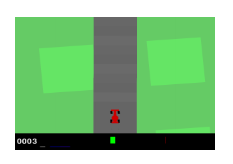

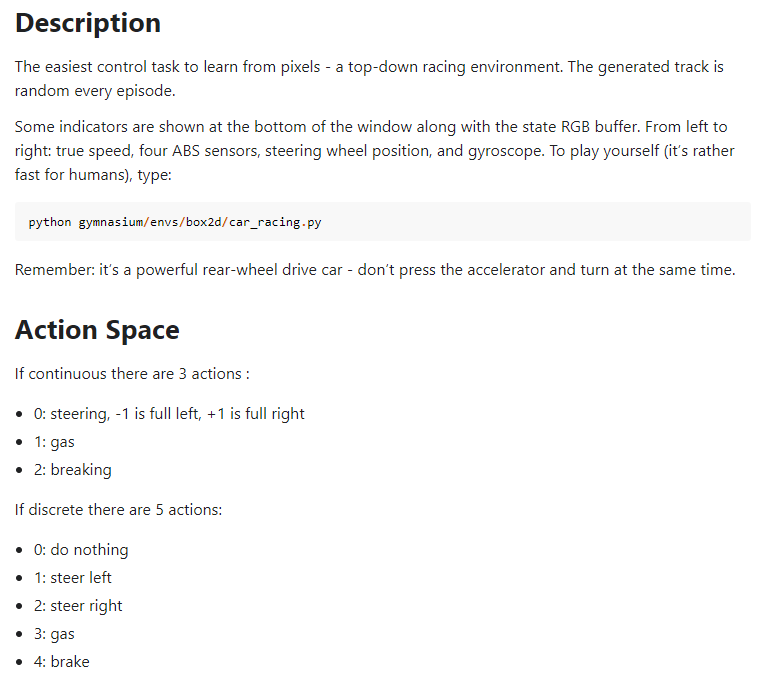

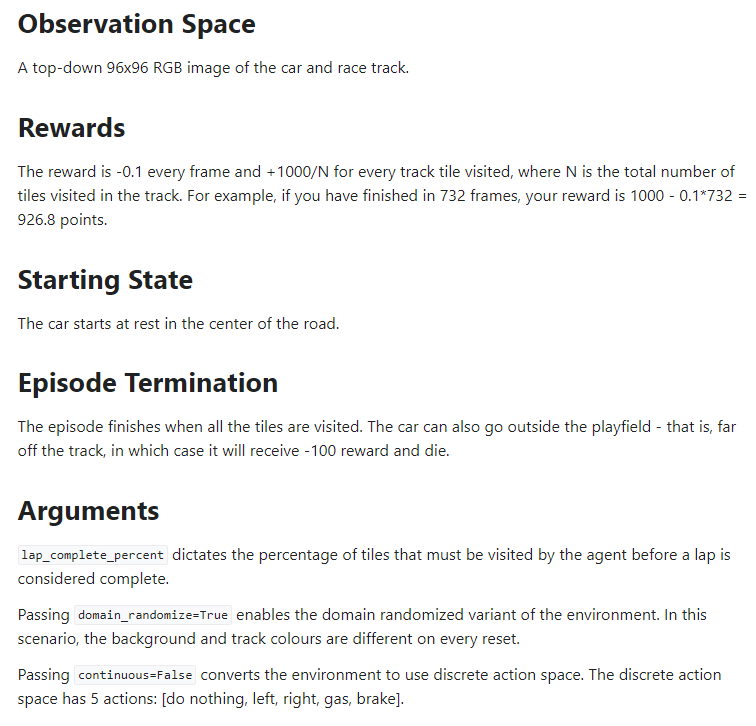

In [4]:
!pip install swig
!pip install gymnasium
!pip install gymnasium[box2d]
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output

In [5]:
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


## Check the Video

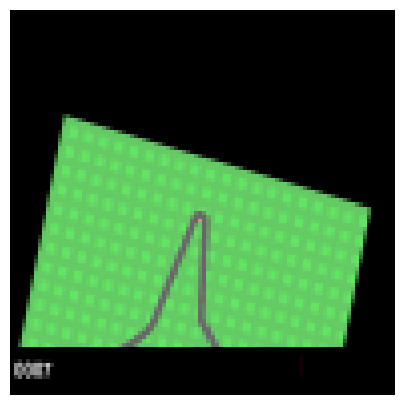

In [6]:
env.reset()
frames = []
# 50 frame은 도입부라서 학습에 사용되지 않음 > PASS
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0-th action is no_op action
    frames.append(s)

# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Preprocess the Image

In [7]:
# Every frme always contains a black area at the bottom of the frame, so we had better cut this black area.
# Also, Color imformation is not directly related to car racing. So we will use gray image for computation efficiency.
# 학습에 불필요한 부분은 CROP 후에 사용함 (Grayscale로 변환)
def preprocess(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Manual Environment

In [9]:
class ImageEnv(gym.Wrapper):

# skip_frame: 한번 action을 수행하면 4frame동안 진행함
# stack_frame: 4프레임을 모아서 한번의 입력으로 제공함
# initial_no_op: 최초 skip 프레임 수

    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    # 처음으로 돌아감

    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
            if terminated or truncated:
                s, info = self.env.reset()

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # The initial observation is simply a copy of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # [4, 84, 84]
        return self.stacked_state, info

    def step(self, action):
        # We take an action for self.skip_frames steps
        # terminated: 완료 / truncated: 실패
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

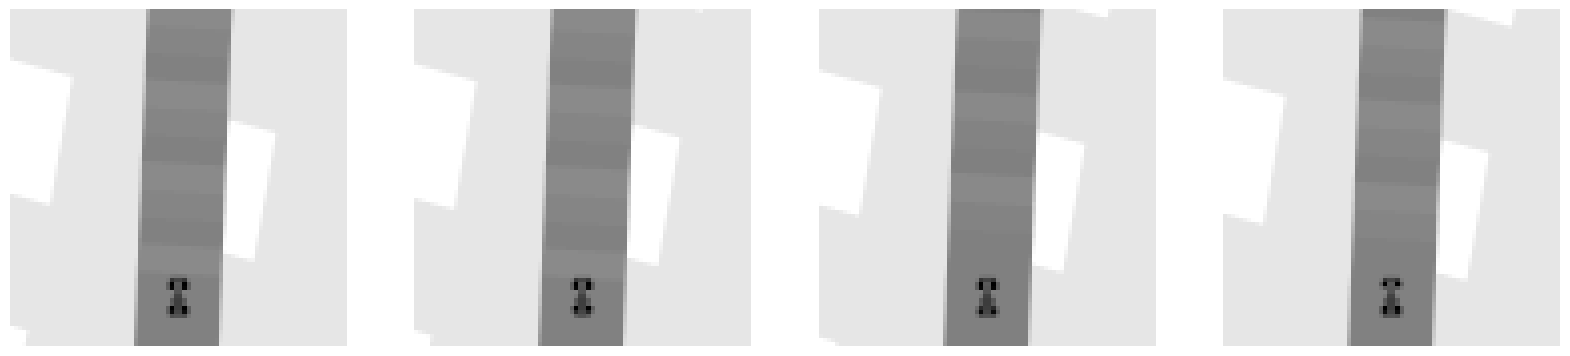

In [10]:
"""
0: do nothing
1: steer left
2: steer right
3: steer gas
4: brake
"""
# 하나의 action이 4개의 frame에 적용되는 예시

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

env.reset()
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # #3 action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Network

### ouput tensor size of Convolution layer

- $O$ : Size(width) of output image
- $I$: Size(width) of input image
- $K$: Size(width) of kernels used in the Conv layer
- $N$: Number of kernels
- $S$: Stride of the convolution operation
- $P$: Padding size

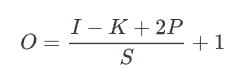

In [59]:
class Actor(nn.Module):
  def __init__(self,state_dim,action_dim):
    super(Actor,self).__init__()

    self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
    self.in_features=32*9*9
    self.fc1=nn.Linear(self.in_features,256)
    self.actor=nn.Linear(256,action_dim)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    #print(f"Shape after conv1: {x.shape}")
    x=F.relu(self.conv2(x))
    #print(f"Shape after conv layers: {x.shape}")
    x = x.view(x.size(0),-1)  # 텐서를 2D로 변환: [N, 32, 9, 9] -> [N, 32*9*9]
    #print(f"Shape after flatten: {x.shape}")
    x=F.relu(self.fc1(x))
    #print(f"Shape after fc1: {x.shape}")
    policy = F.softmax(self.actor(x), dim=-1)
    #print(f"Shape after actor: {policy.shape}")
    return policy


class Critic(nn.Module):
  def __init__(self,state_dim):
    super(Critic,self).__init__()

    self.conv1=nn.Conv2d(state_dim[0],16,kernel_size=8,stride=4) #[N,4,84,84] -> [N,16,20,20]
    self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 20, 20] -> [N, 32, 9, 9]
    self.in_features=32*9*9
    self.fc1=nn.Linear(self.in_features,256)
    self.critic=nn.Linear(256,1)

  def forward(self,x):

    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x = x.view(x.size(0),-1)
    x=F.relu(self.fc1(x))
    value = F.softmax(self.critic(x), dim=-1)

    return value

#A2C

In [60]:
import torch.optim as optim

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

state = env.reset()

print(state[0].shape)

max_steps = int(1e6)
eval_interval = 10000
state_dim = (4, 84, 84)
action_dim = env.action_space.n

actor = Actor(state_dim, action_dim)
critic= Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr = 0.0005)
critic_optimizer=optim.Adam(critic.parameters(),lr=0.0005)

(4, 84, 84)


In [69]:
import torch
import torch.nn.functional as F
import numpy as np

def train(env, actor, critic, actor_optimizer, critic_optimizer, gamma, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    actor.train().to(device)
    critic.train().to(device)

    state, _ = env.reset()
    done = False
    episode_reward = 0

    state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []

    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # 배치 차원 추가
        #print(f"State tensor shape: {state_tensor.shape}")
        action_probs = actor(state_tensor).detach().cpu().numpy().flatten()
        action = np.random.choice(len(action_probs), p=action_probs)

        next_state, reward, done, _, _ = env.step(action)

        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)
        next_state_list.append(next_state)
        done_list.append(done)

        episode_reward += reward



        # 조기 종료 조건
        if episode_reward < -250:
            done = True


        if len(state_list) >= batch_size:
          #array 변환
          state_list = np.array(state_list)
          next_state_list = np.array(next_state_list)
          action_list = np.array(action_list)
          reward_list = np.array(reward_list)
          done_list = np.array(done_list)

          #tensor 변환
          state_t = torch.FloatTensor(state_list).to(device)
          next_state_t = torch.FloatTensor(next_state_list).to(device)
          action_t = torch.LongTensor(action_list).view(-1, 1).to(device)
          reward_t = torch.FloatTensor(reward_list).view(-1, 1).to(device)
          done_t = torch.FloatTensor(done_list).view(-1, 1).to(device)

          #print(f"State tensor batch shape: {state_t.shape}")

          action_probs = actor(state_t).gather(1, action_t)
          log_action_probs = torch.log(action_probs)

          critic_t = critic(state_t).view(-1, 1)
          #print(f"Critic tensor shape: {critic_t.shape}")
          critic_td_t = reward_t + (1 - done_t) * gamma * critic(next_state_t).view(-1, 1)
          #print(f"Critic target tensor shape: {critic_td_t.shape}")
          advantage_t = critic_td_t - critic_t

          actor_loss = -torch.mean(advantage_t.detach() * log_action_probs)
          actor_optimizer.zero_grad()
          actor_loss.backward()
          actor_optimizer.step()

          critic_loss = F.smooth_l1_loss(critic_t, critic_td_t.detach())
          critic_optimizer.zero_grad()
          critic_loss.backward()
          critic_optimizer.step()

          # 다음 배치를 위해 리스트 초기화
          state_list, action_list, reward_list, next_state_list, done_list = [], [], [], [], []

        #print(f"Next state shape: {next_state.shape}")
        state = next_state

    return episode_reward

In [70]:
    def plot_rewards(rewards, episode):
      plt.figure(figsize=(10, 5))
      plt.plot(rewards, label='Episode Reward')
      plt.xlabel('Episode{}'.format(episode))
      plt.ylabel('Reward')
      plt.title('Rewards per Episode')
      plt.legend()
      plt.show()

In [71]:
def evaluate(n_evals=1):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)

    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            state_tensor = torch.FloatTensor(s).unsqueeze(0).to(device)  # 배치 차원 추가
            action_probs = actor(state_tensor).detach().cpu().numpy().flatten()
            a = np.random.choice(len(action_probs), p=action_probs)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

# Training

Episode 10	Average Score: -17.49


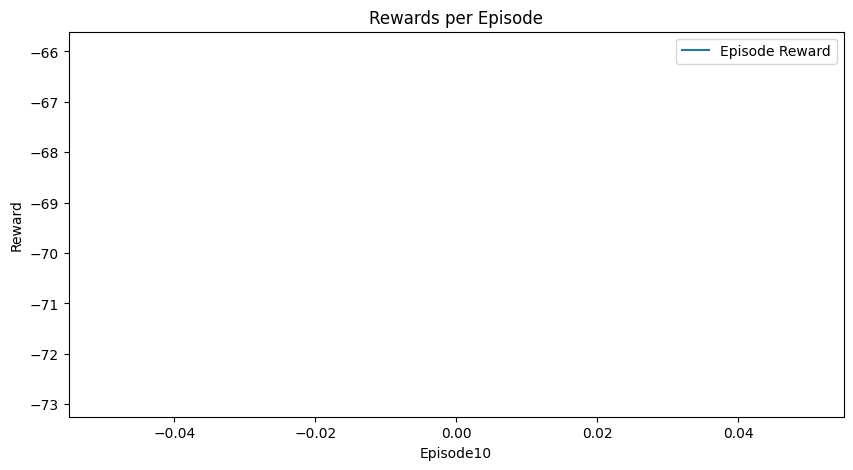

Episode 20	Average Score: -58.93


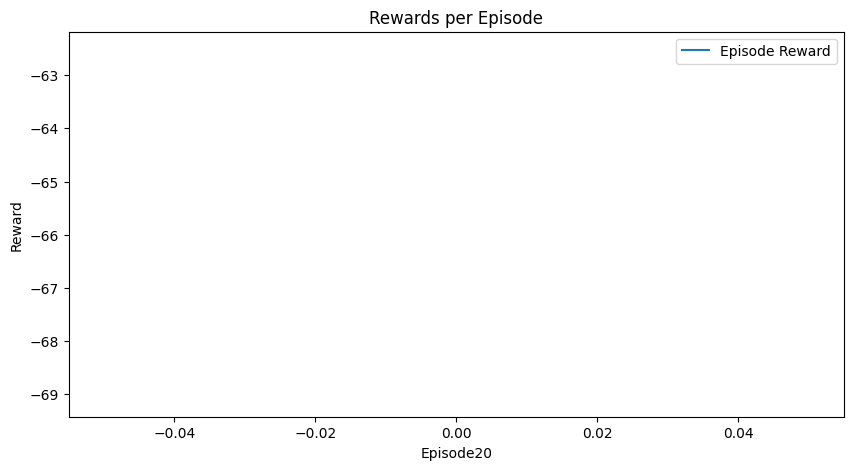

Episode 30	Average Score: -53.54


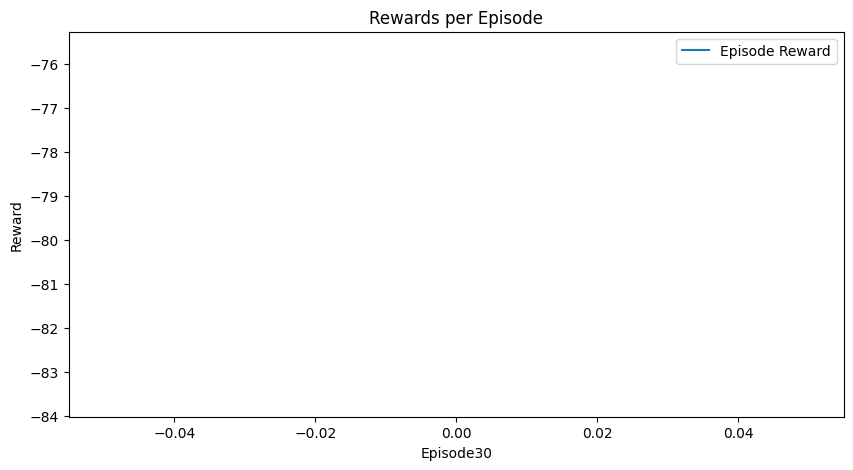

Episode 40	Average Score: -51.93


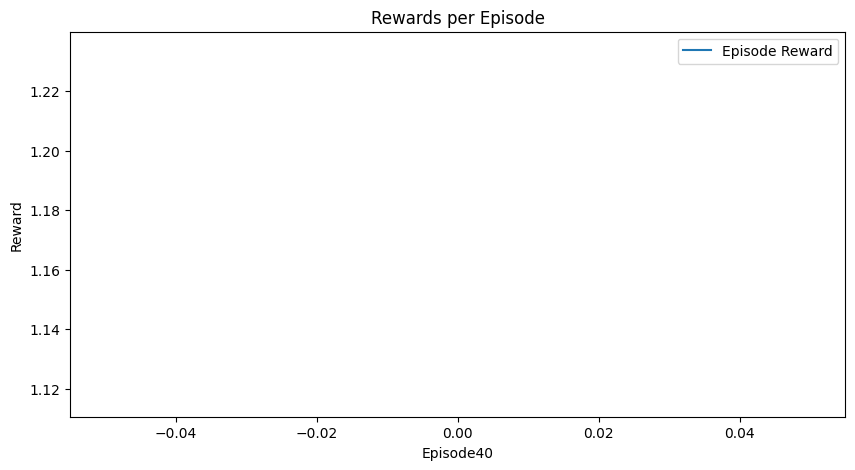

Episode 50	Average Score: -45.04


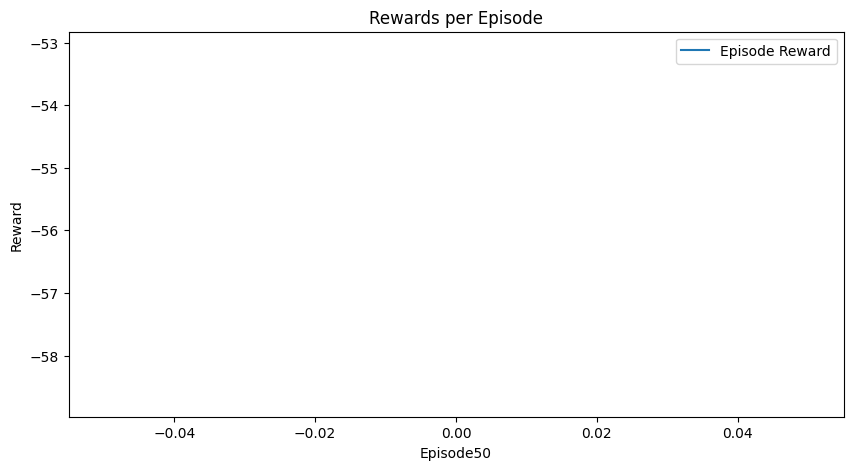

Episode 60	Average Score: -44.48


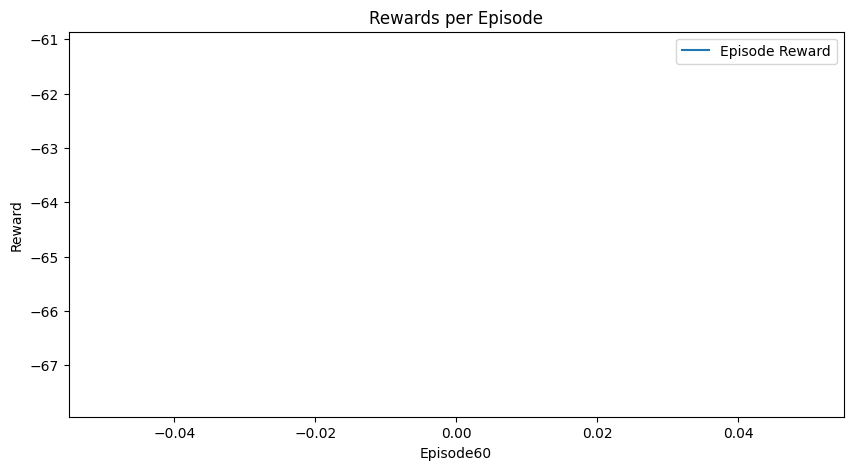

Episode 70	Average Score: -49.75


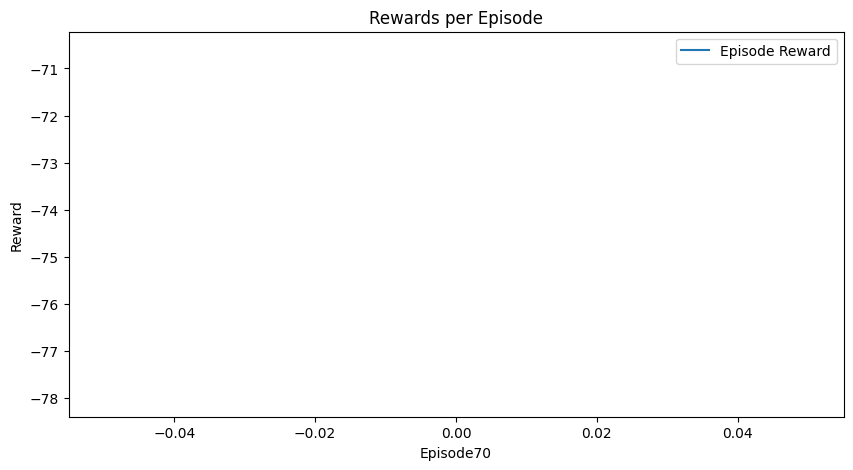

Episode 80	Average Score: -40.92


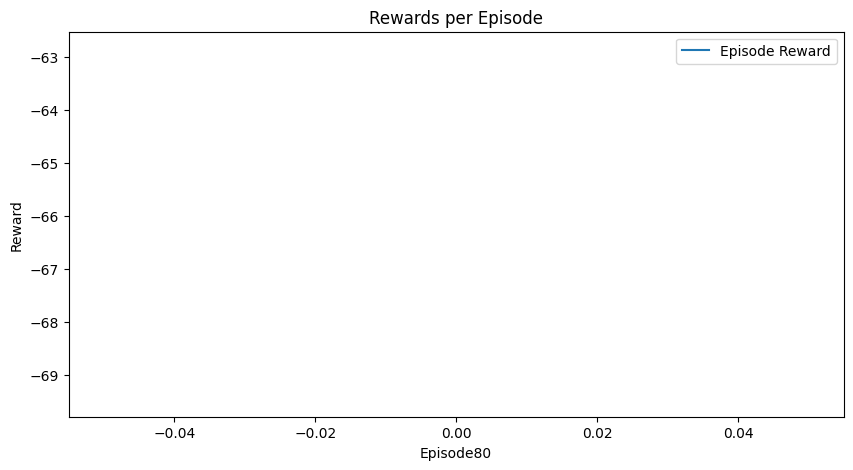

Episode 90	Average Score: -53.77


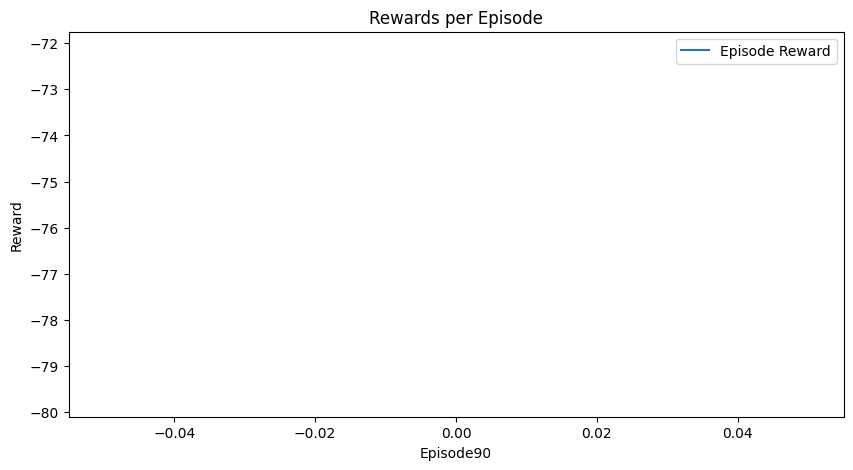

Episode 100	Average Score: -47.22


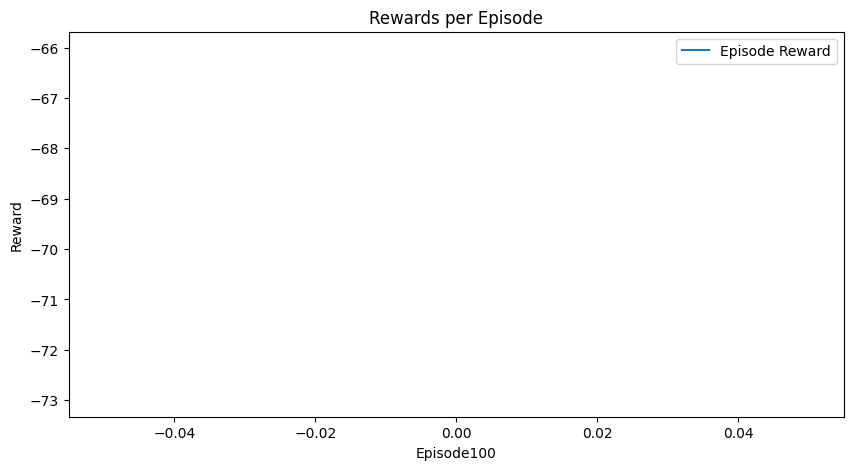

Episode 110	Average Score: -39.68


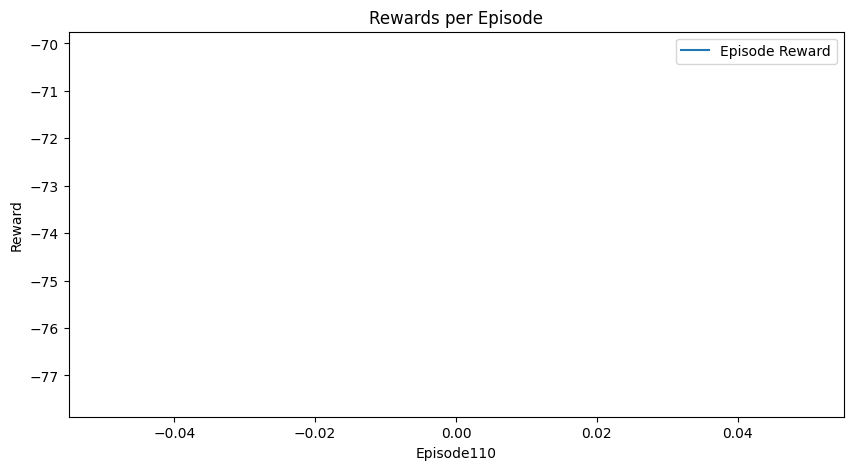

Episode 120	Average Score: -72.90


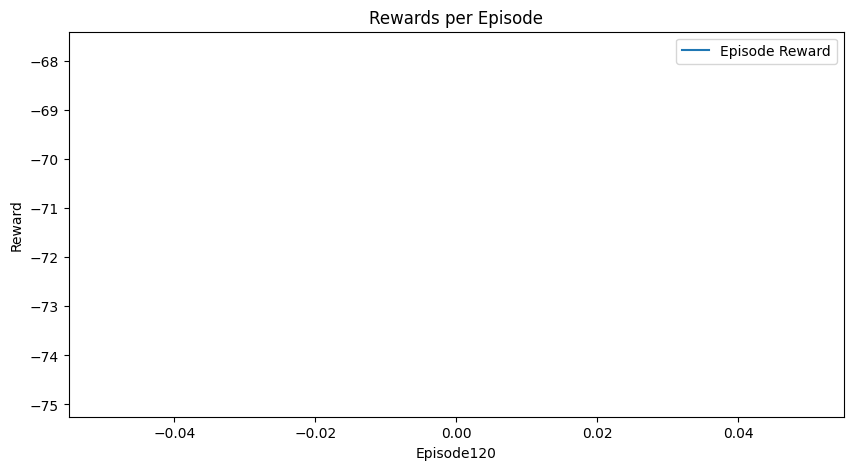

Episode 130	Average Score: -42.24


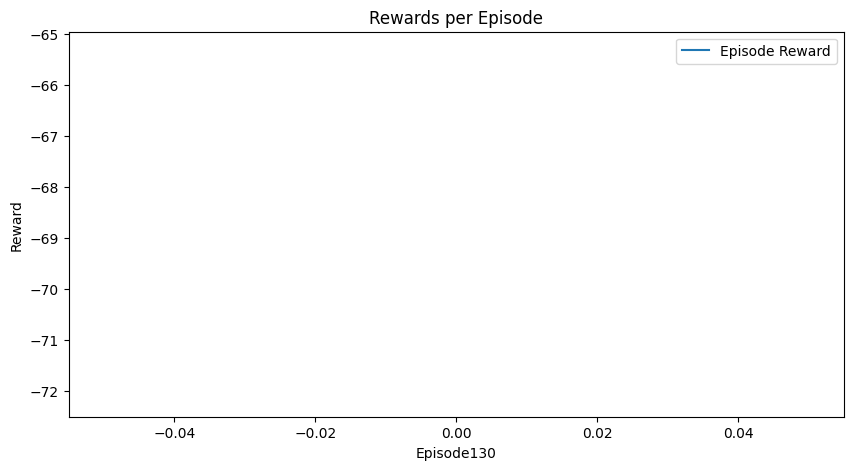

Episode 140	Average Score: -54.97


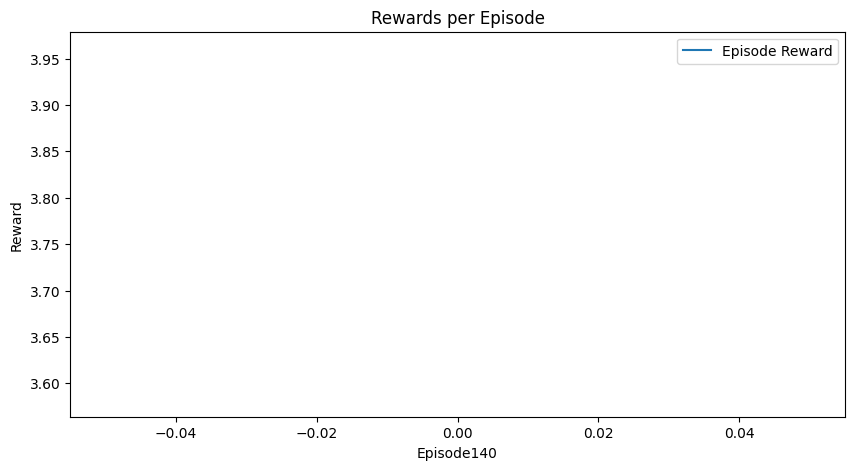

Episode 150	Average Score: -49.84


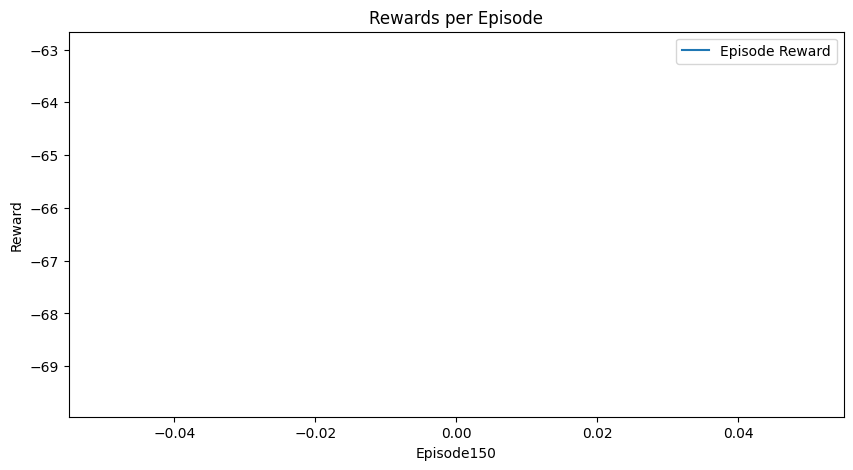

Episode 160	Average Score: -57.96


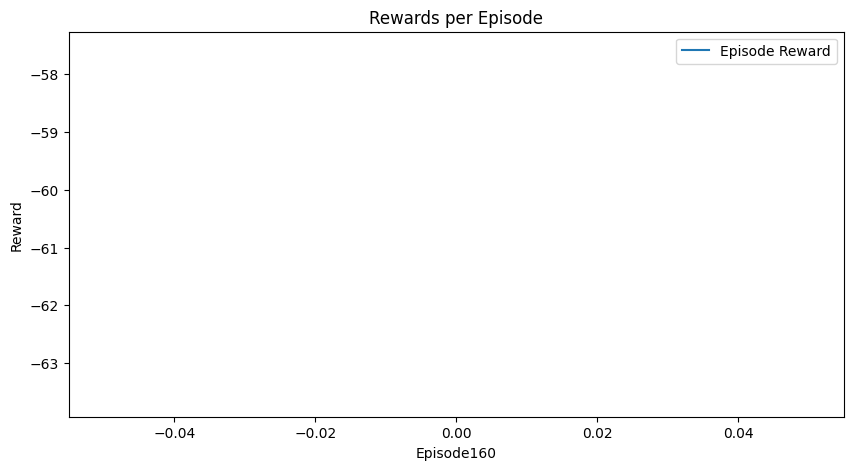

Episode 170	Average Score: -46.89


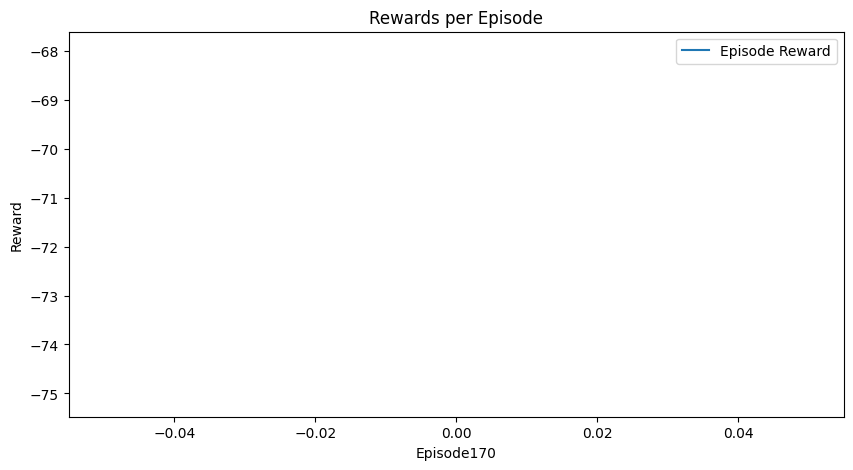

Episode 180	Average Score: -31.11


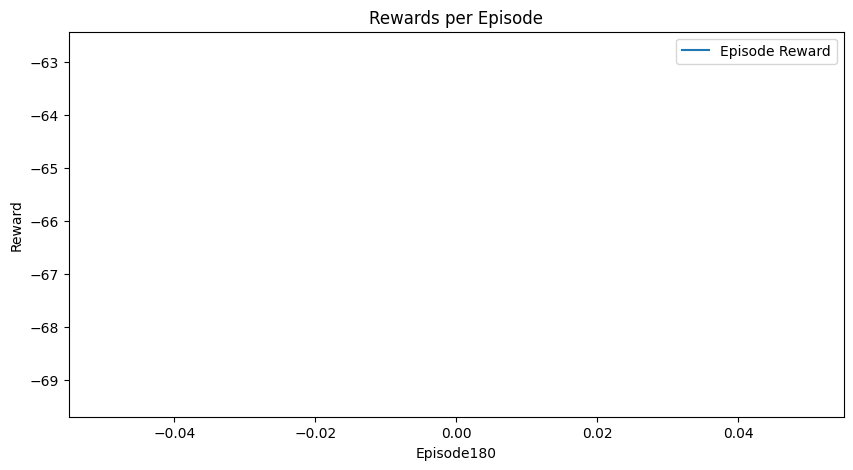

Episode 190	Average Score: -50.99


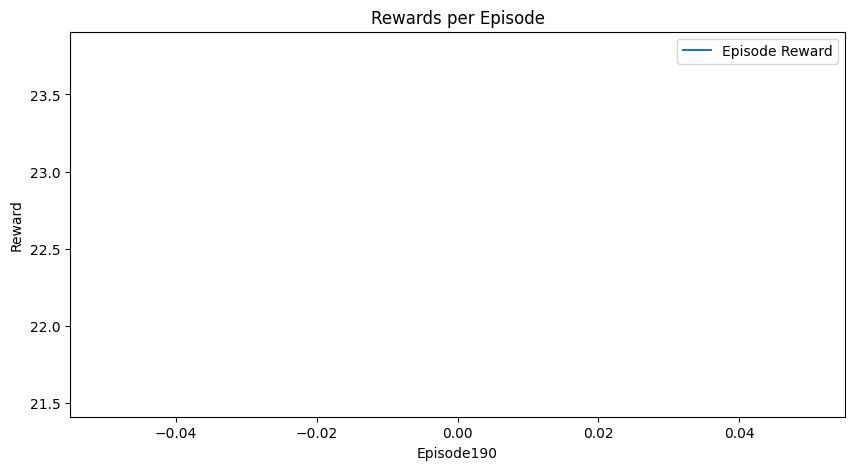

Episode 200	Average Score: -44.77


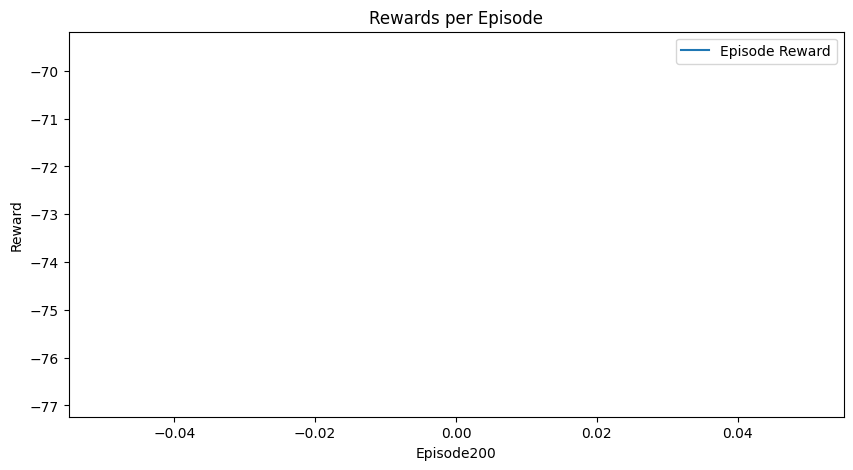

Episode 210	Average Score: -71.49


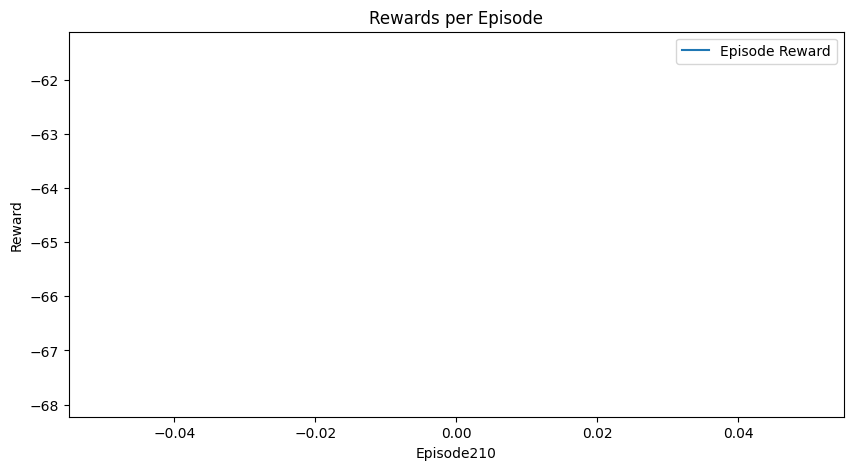

Episode 220	Average Score: -17.21


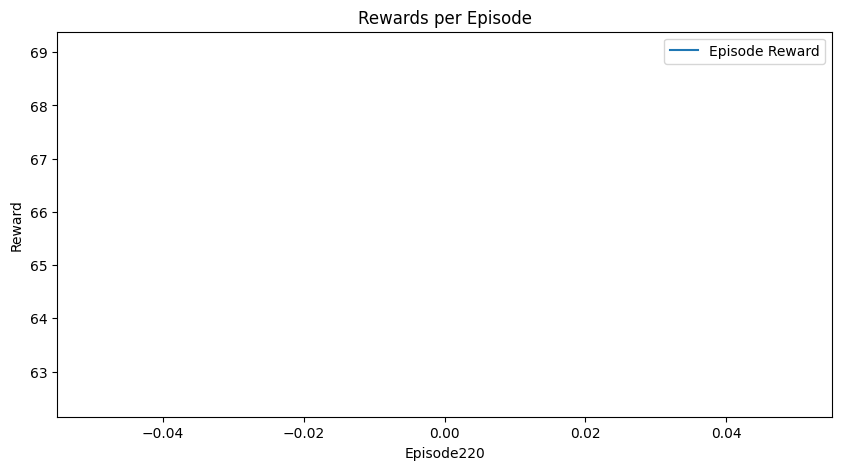

Episode 230	Average Score: -66.69


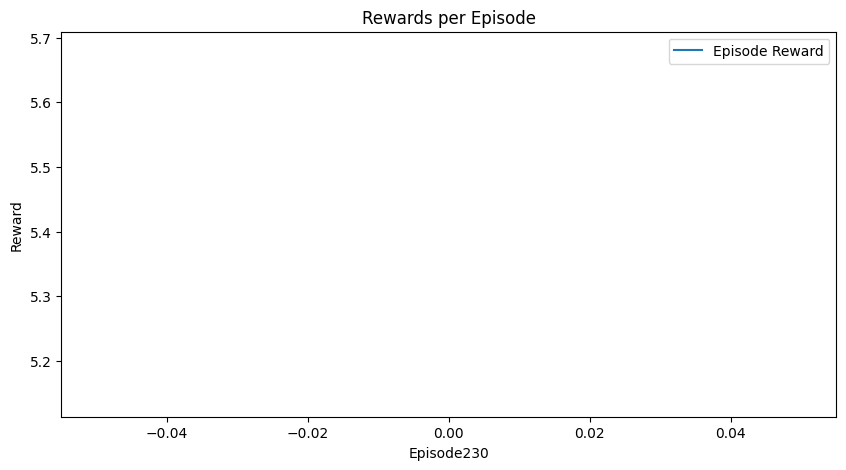

Episode 240	Average Score: -52.36


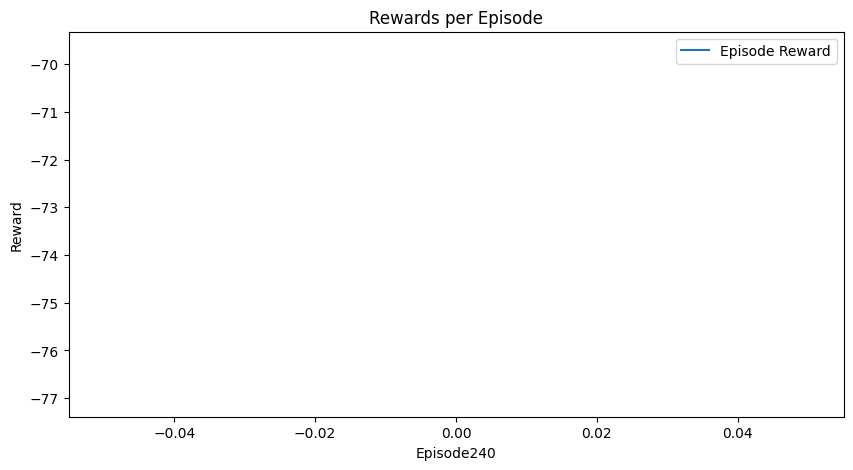

Episode 250	Average Score: -237.65


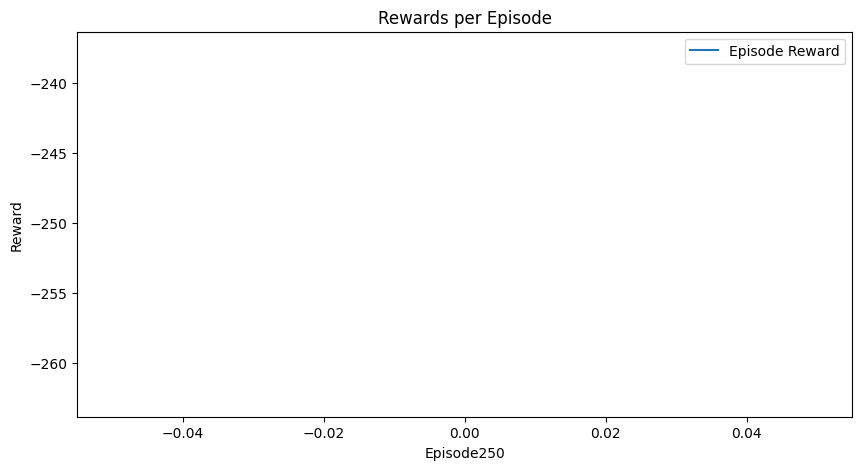

Episode 260	Average Score: -250.04


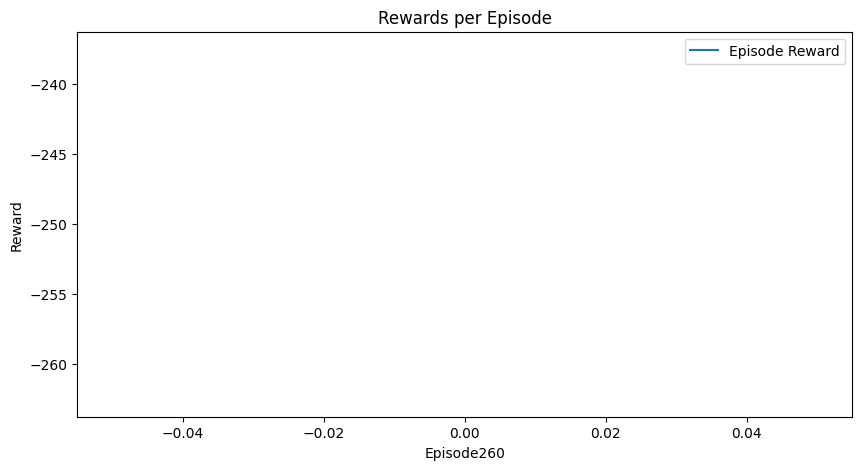

Episode 270	Average Score: -187.88


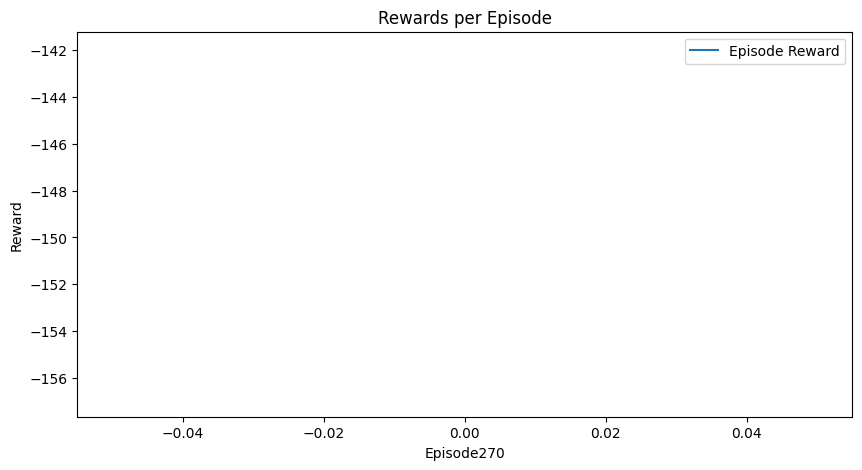

Episode 280	Average Score: -227.62


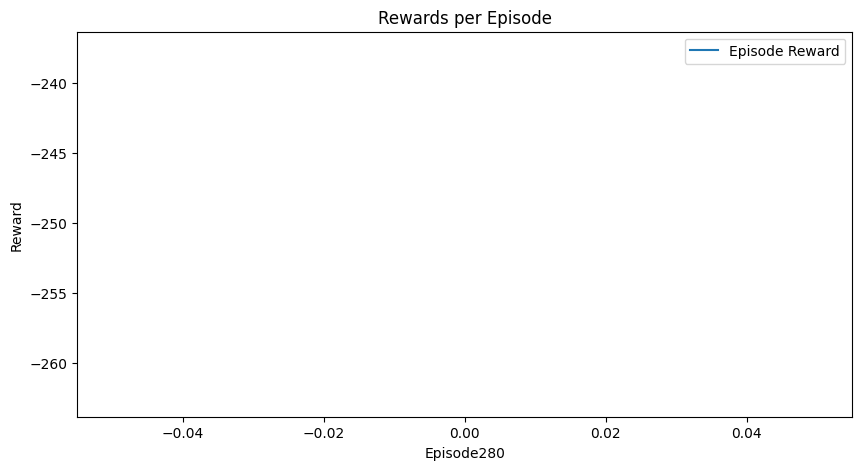

Episode 290	Average Score: -250.05


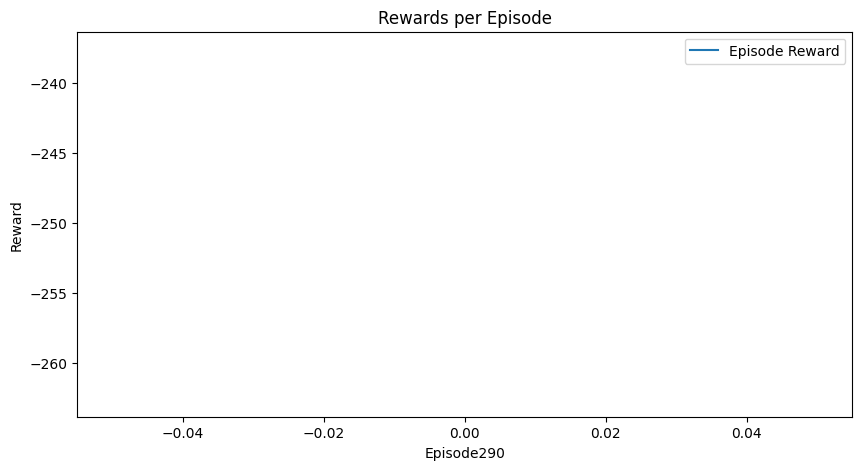

Episode 300	Average Score: -154.28


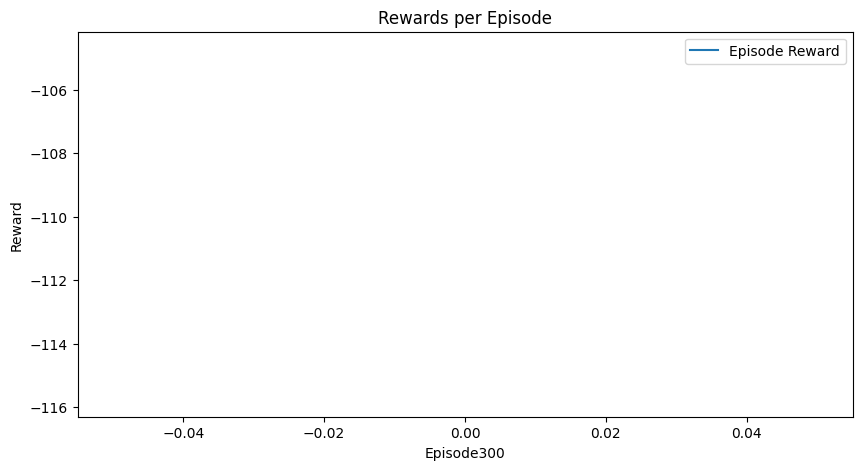

Episode 310	Average Score: -135.83


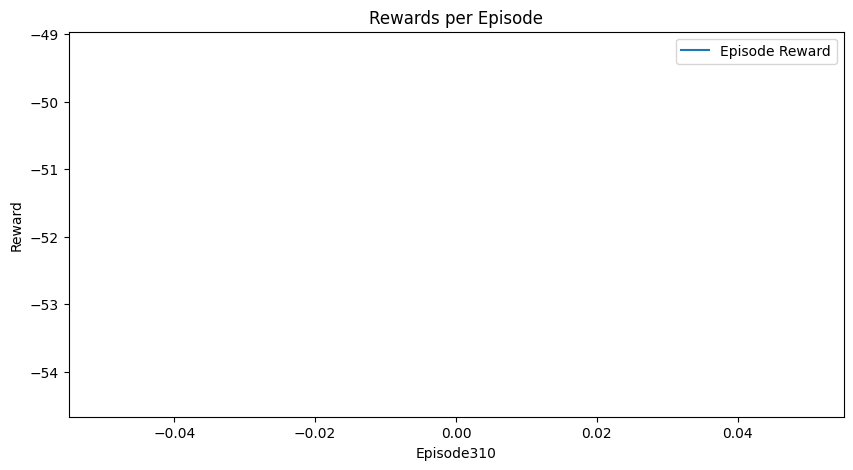

Episode 320	Average Score: -84.43


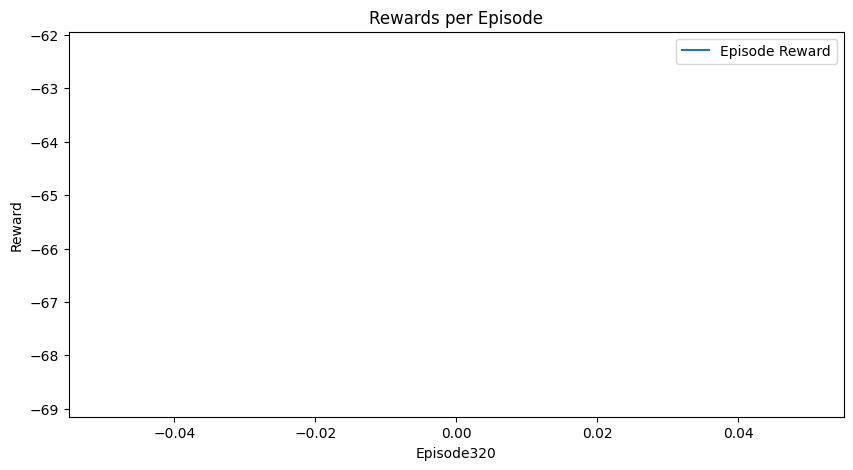

Episode 330	Average Score: -83.53


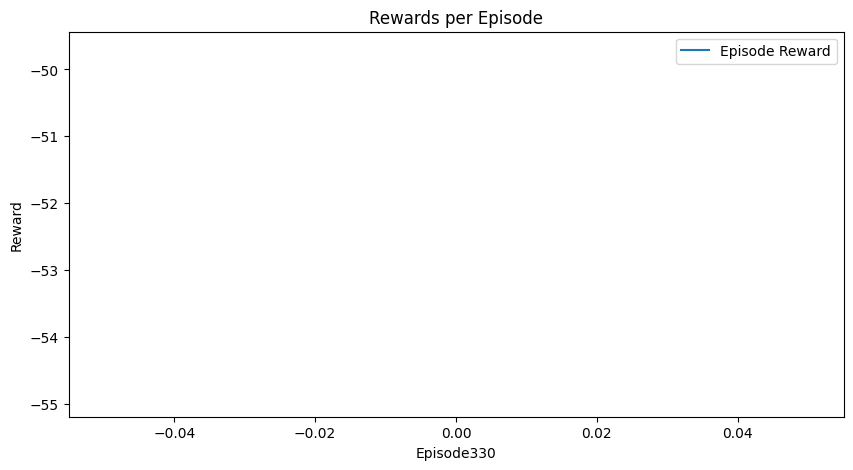

Episode 340	Average Score: -81.84


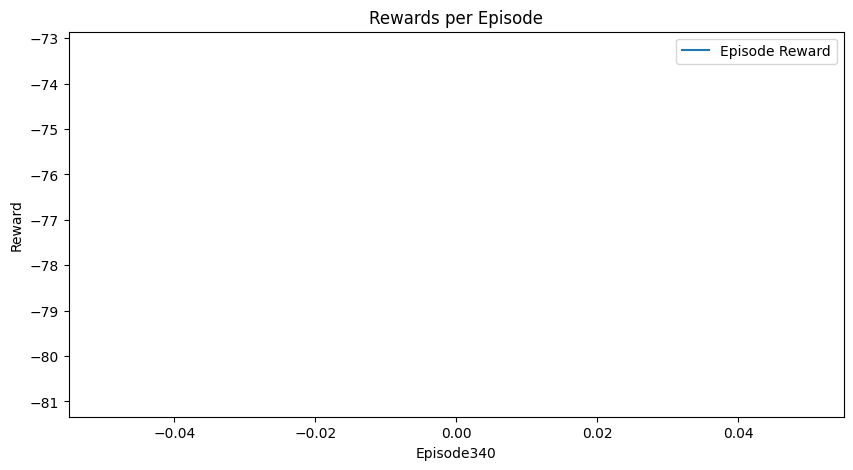

Episode 350	Average Score: -86.61


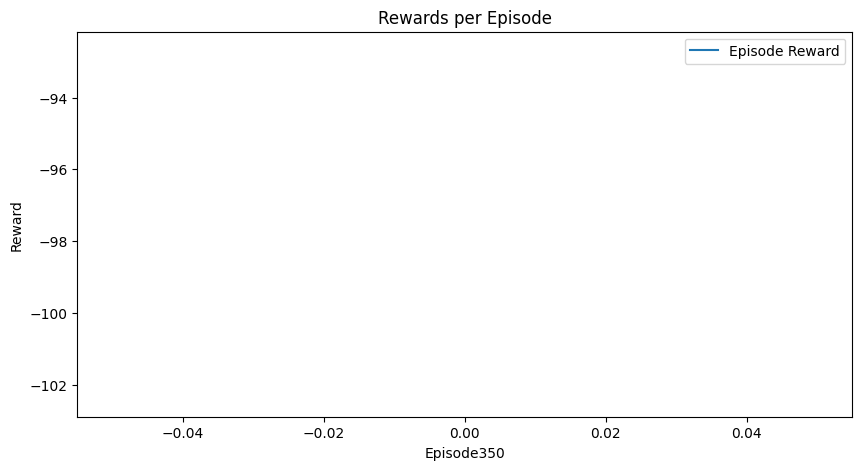

Episode 360	Average Score: -73.89


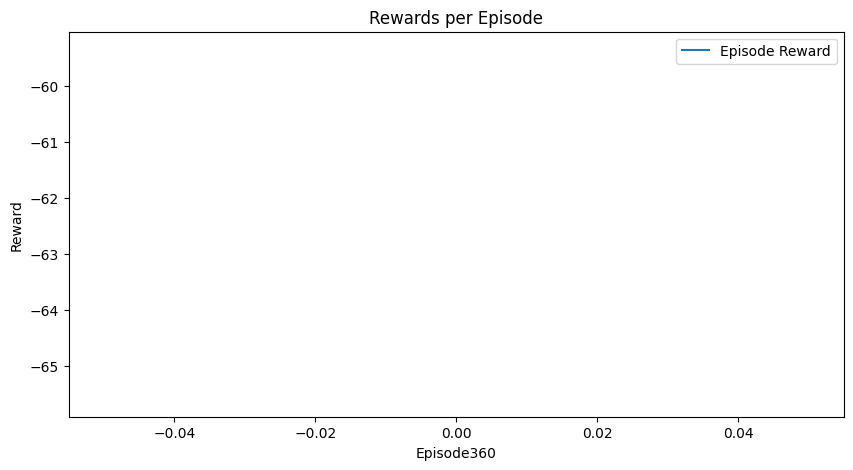

Episode 370	Average Score: -52.34


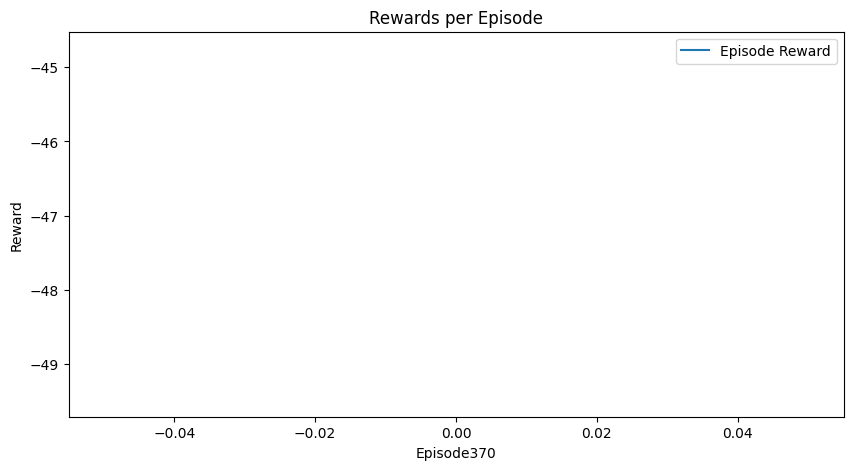

Episode 380	Average Score: -58.00


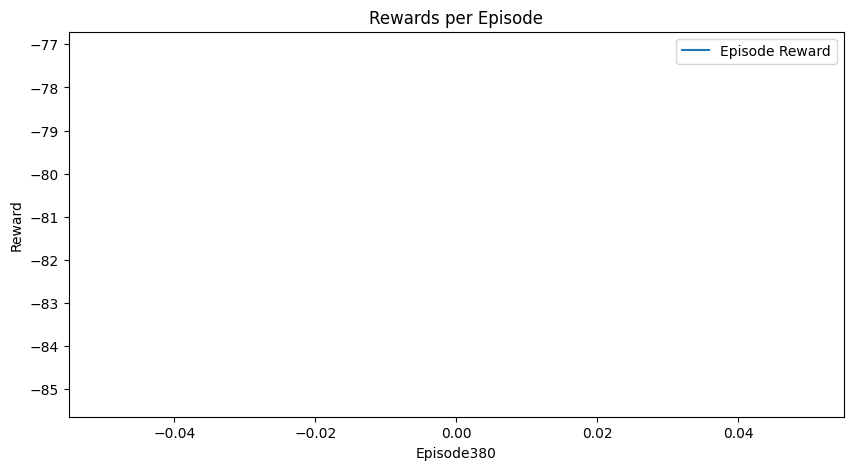

Episode 390	Average Score: -74.85


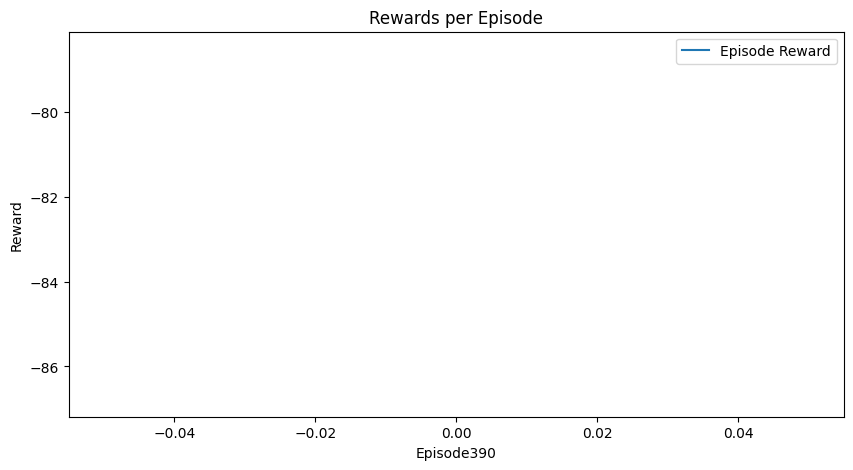

Episode 400	Average Score: -81.44


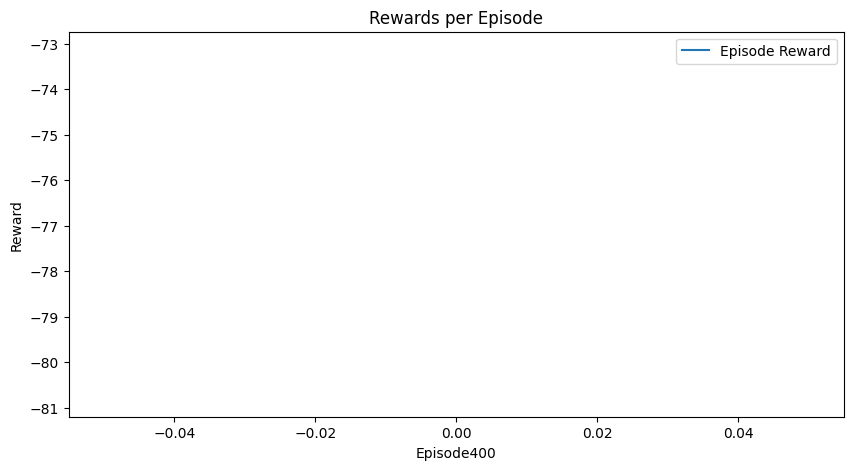

Episode 410	Average Score: -70.61


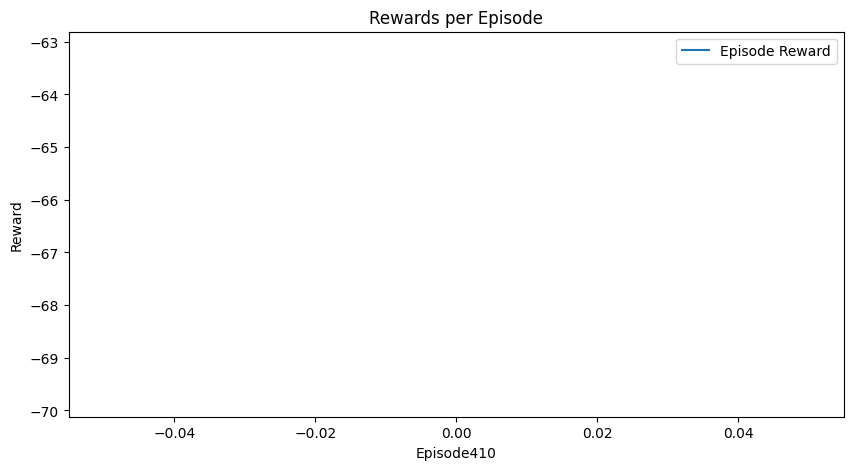

Episode 420	Average Score: -52.47


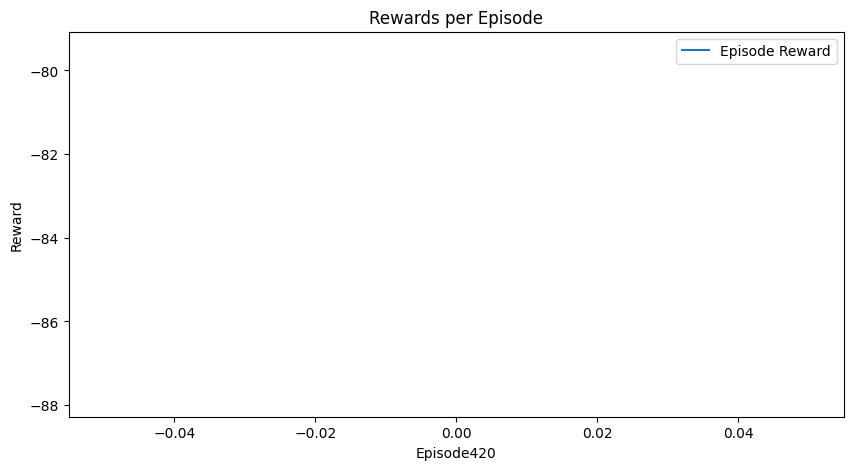

Episode 430	Average Score: -63.49


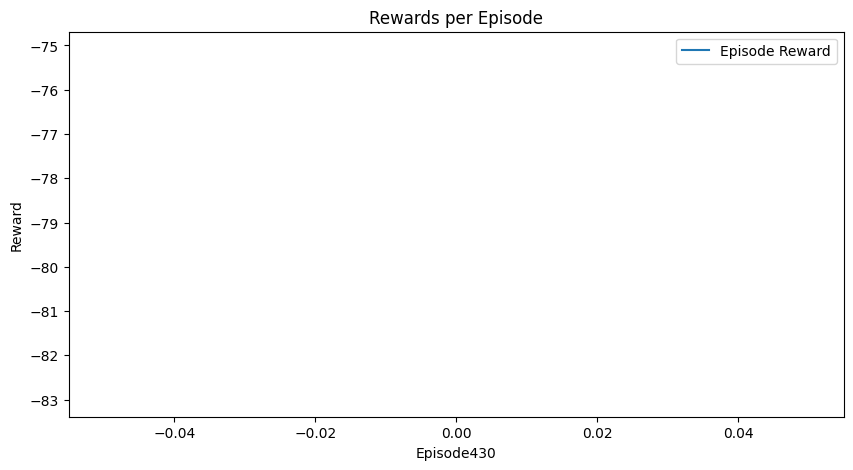

Episode 440	Average Score: -56.02


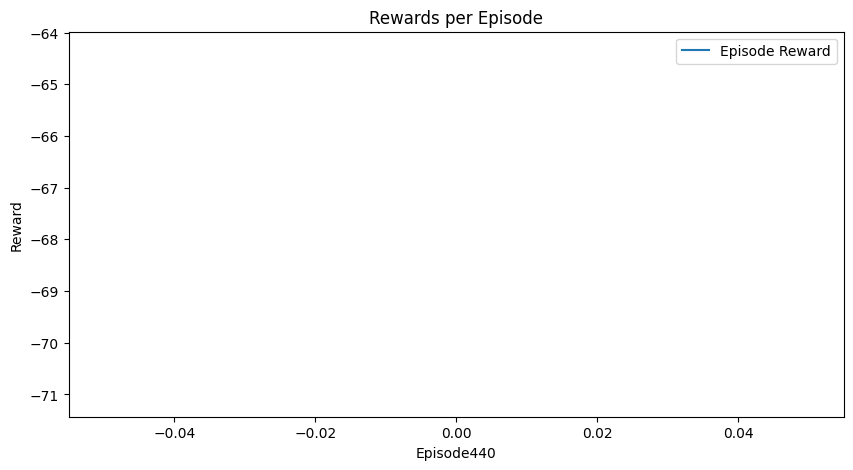

Episode 450	Average Score: -71.35


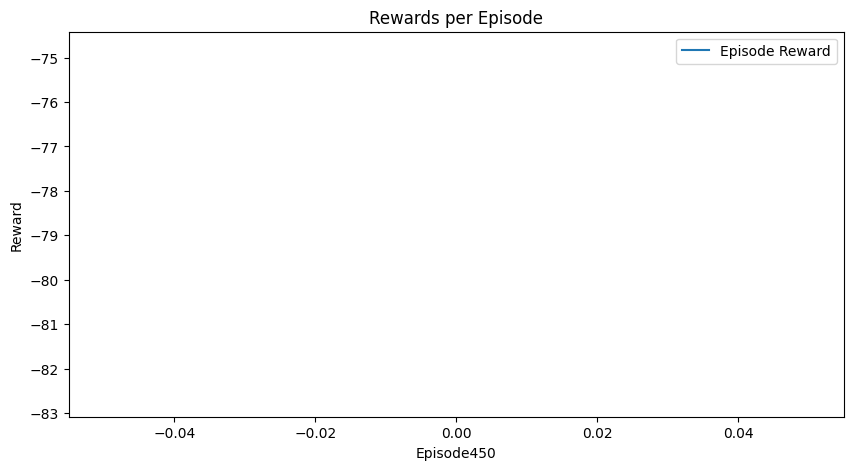

Episode 460	Average Score: -33.02


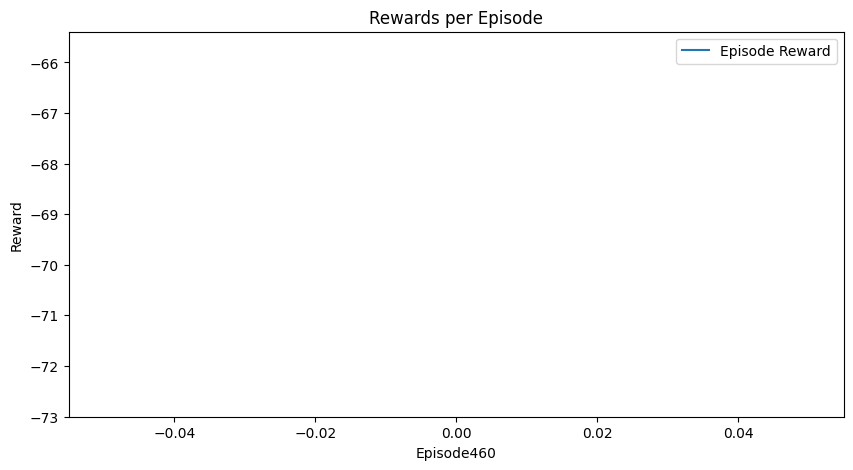

Episode 470	Average Score: -47.09


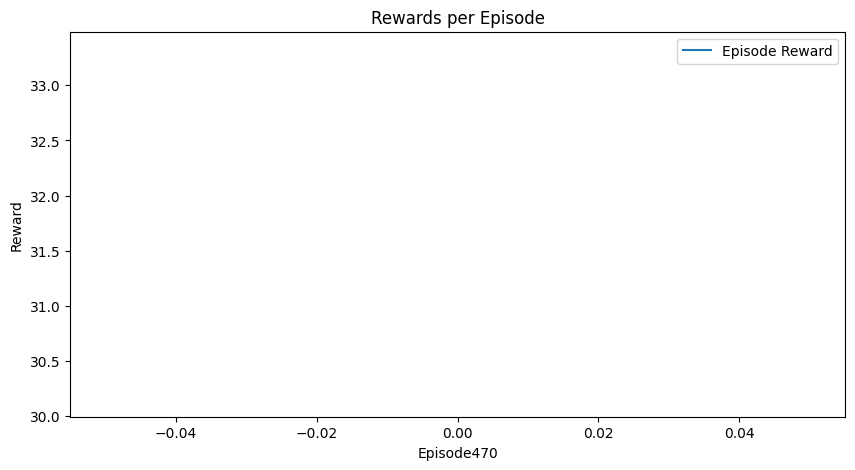

Episode 480	Average Score: -38.45


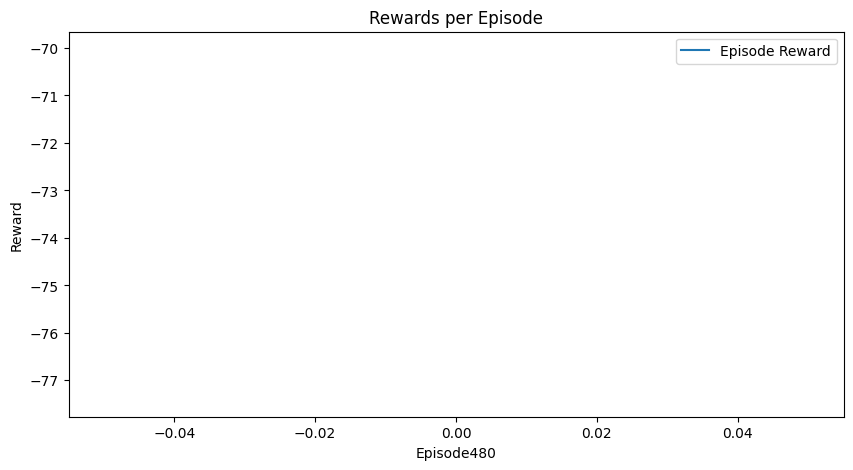

Episode 490	Average Score: -58.37


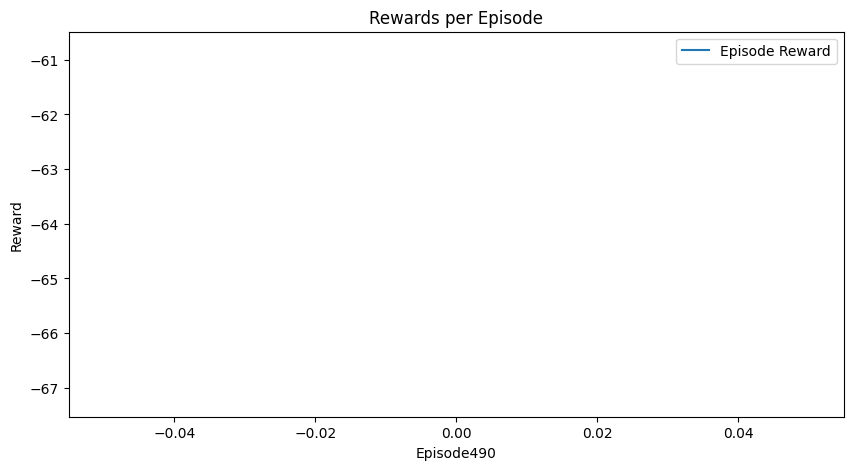

Episode 500	Average Score: -46.71


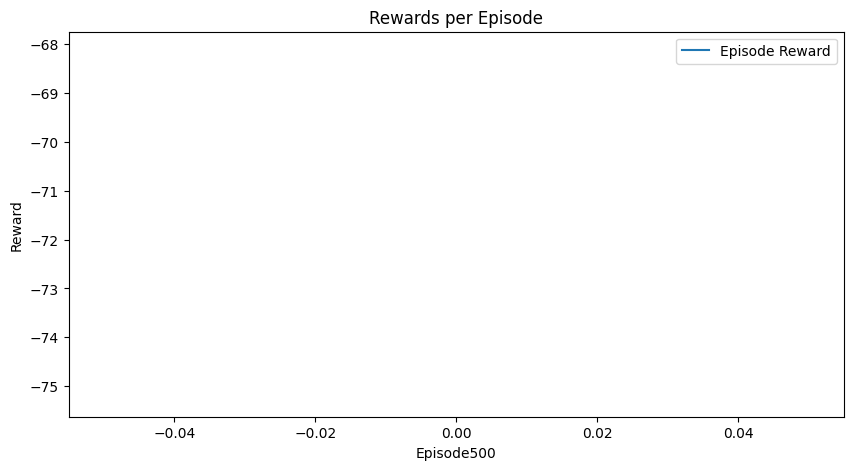

Episode 510	Average Score: -68.65


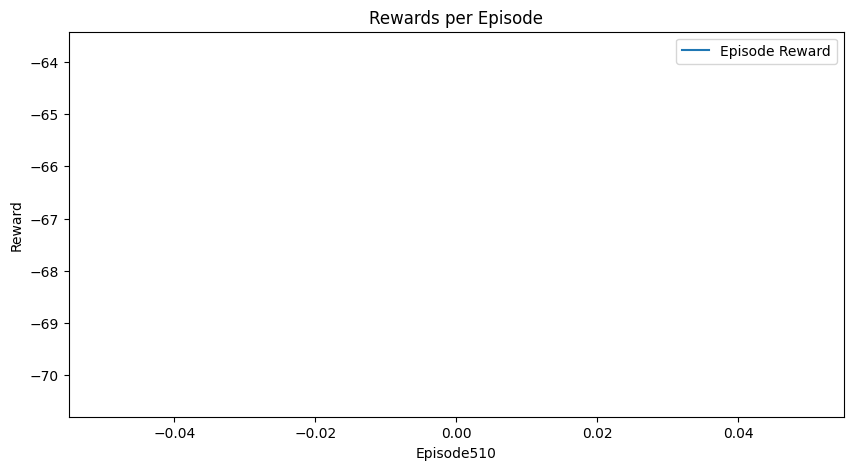

Episode 520	Average Score: -44.74


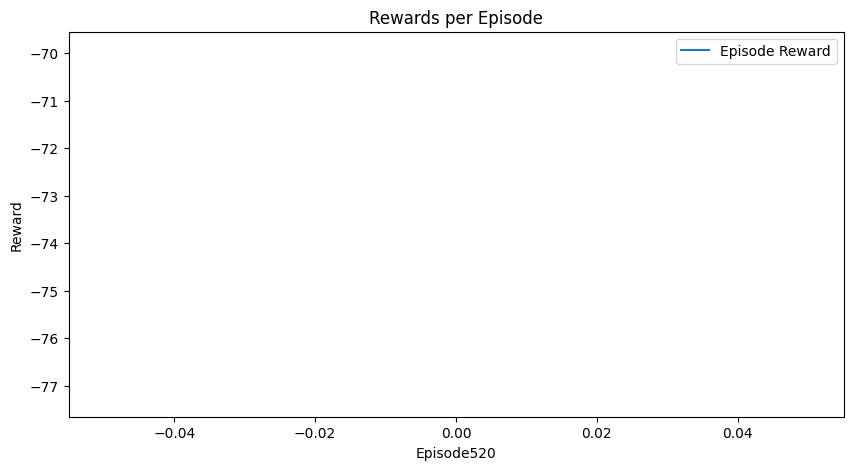

Episode 530	Average Score: -62.31


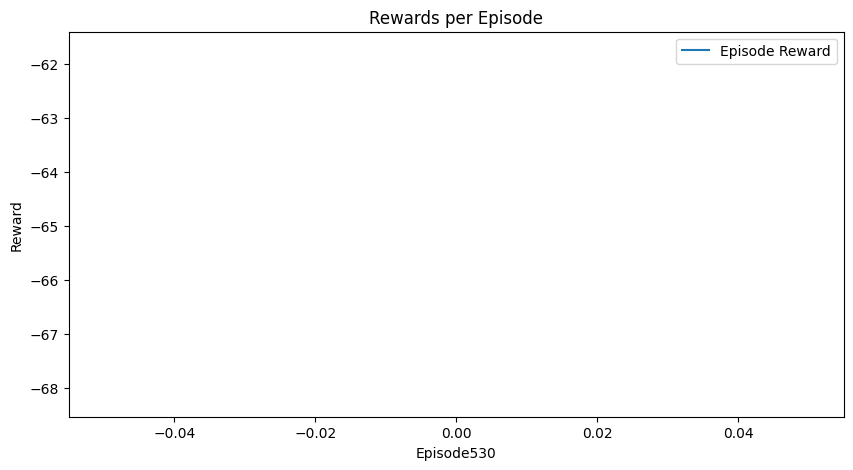

Episode 540	Average Score: -41.88


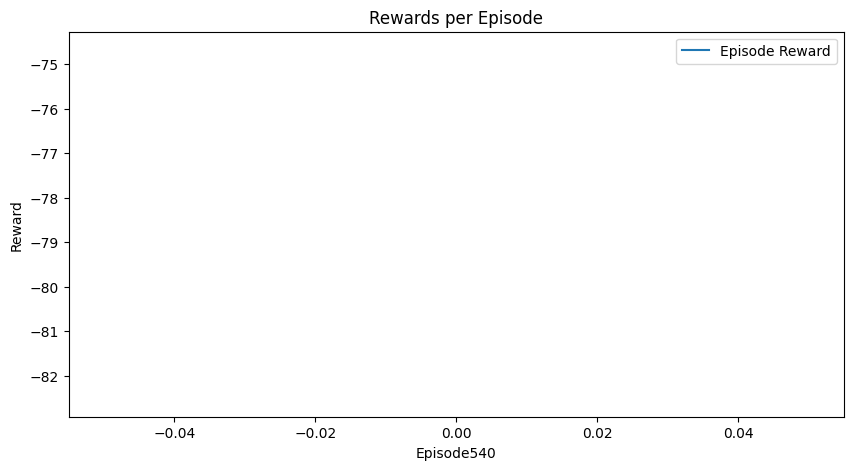

Episode 550	Average Score: -65.12


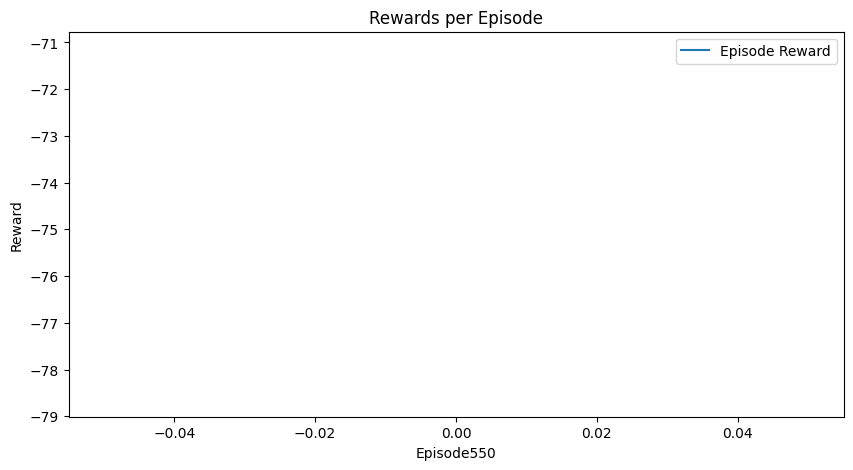

Episode 560	Average Score: -49.56


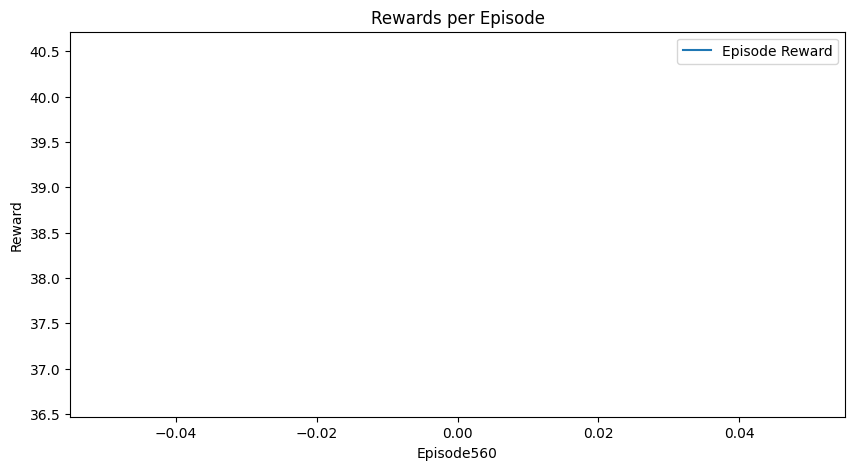

Episode 570	Average Score: -47.52


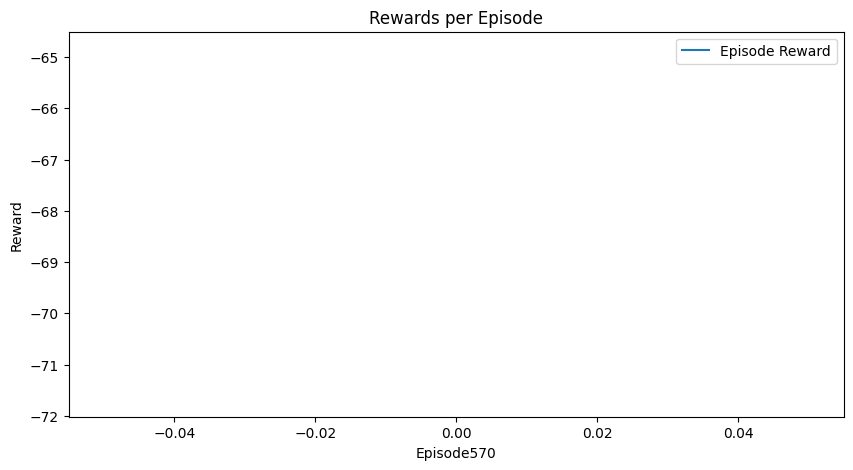

Episode 580	Average Score: -34.88


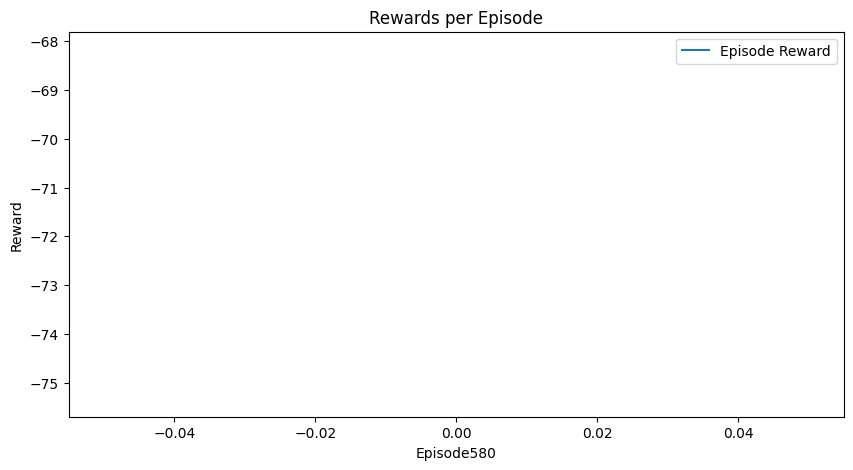

Episode 590	Average Score: -68.10


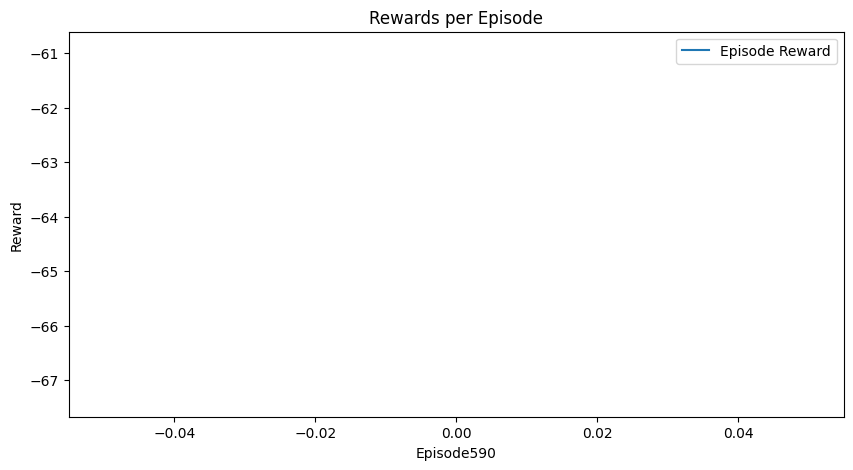

Episode 600	Average Score: -58.82


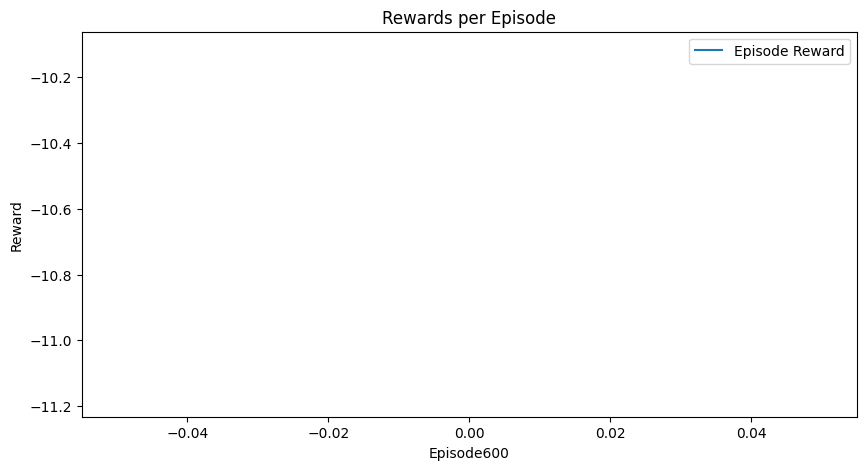

Episode 610	Average Score: -74.10


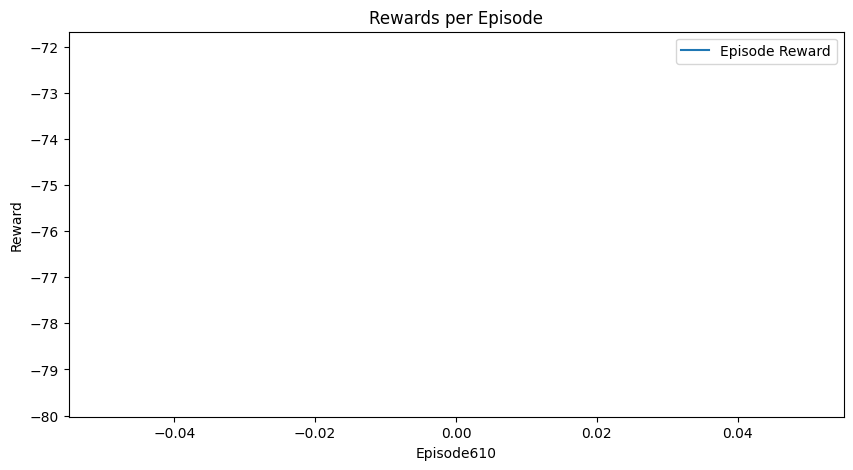

Episode 620	Average Score: -48.75


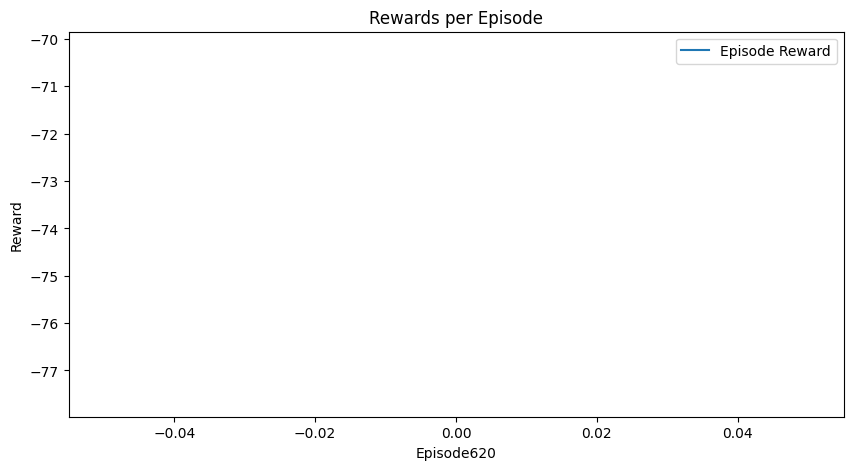

Episode 630	Average Score: -67.07


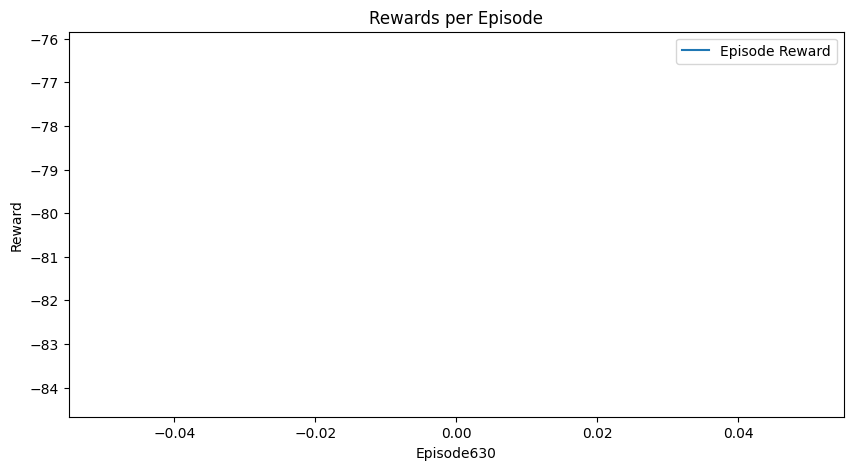

Episode 640	Average Score: -56.43


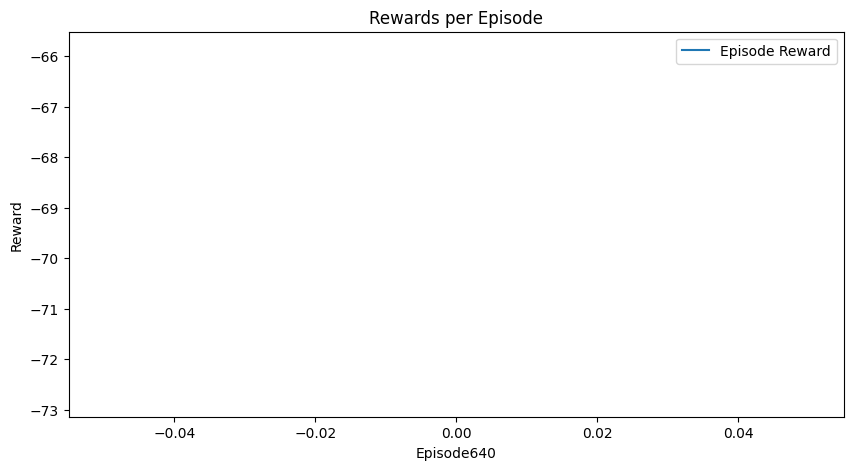

Episode 650	Average Score: -69.81


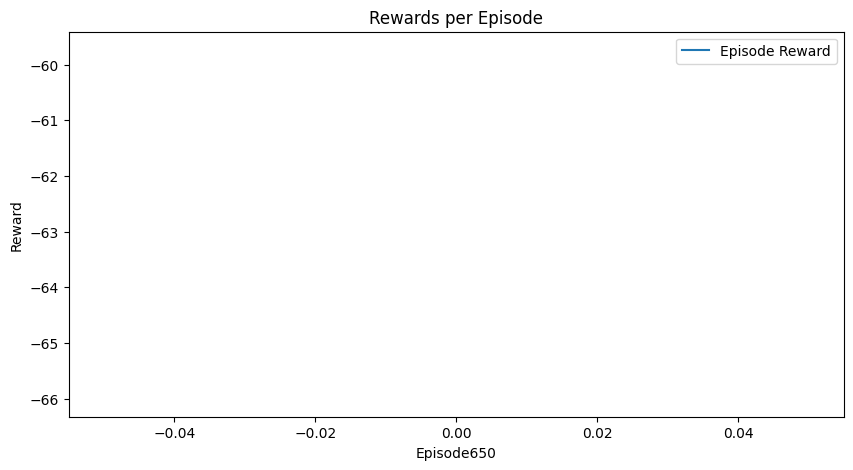

Episode 660	Average Score: -52.39


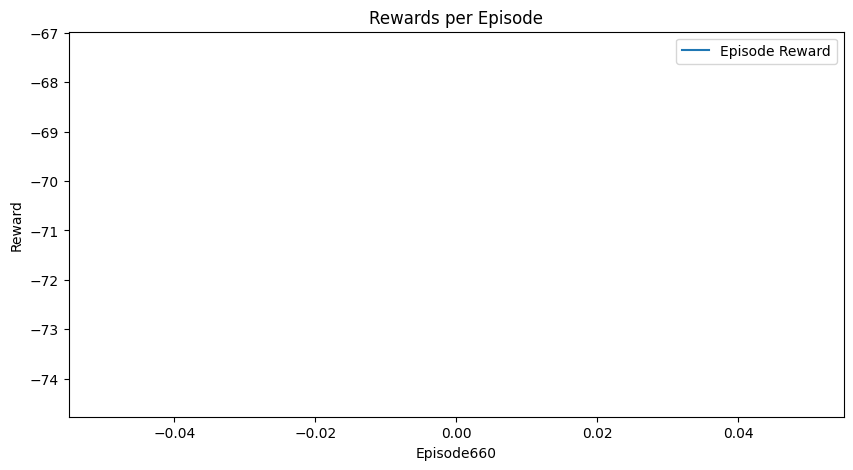

Episode 670	Average Score: -66.43


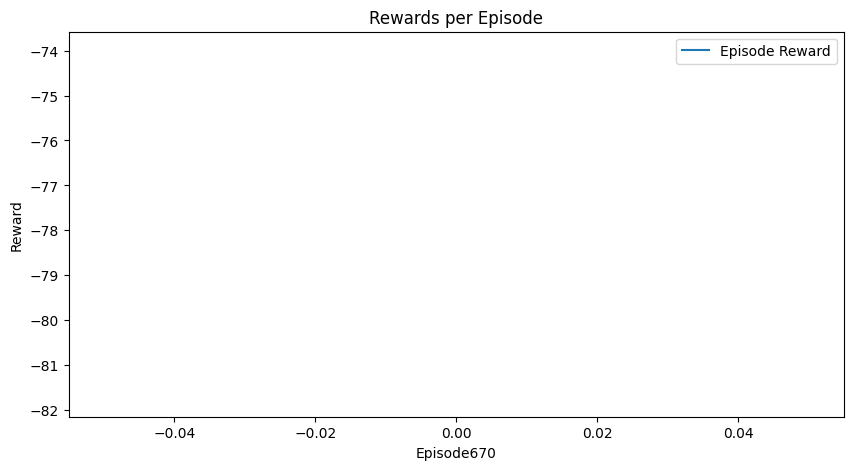

Episode 680	Average Score: -61.35


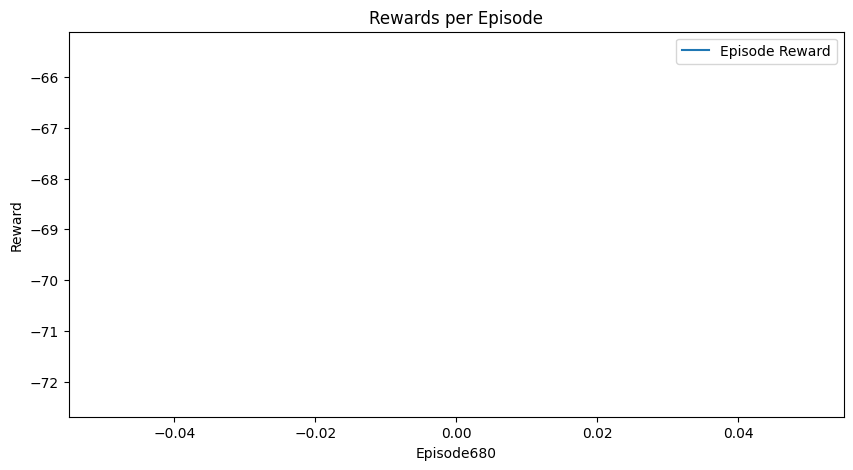

Episode 690	Average Score: -49.67


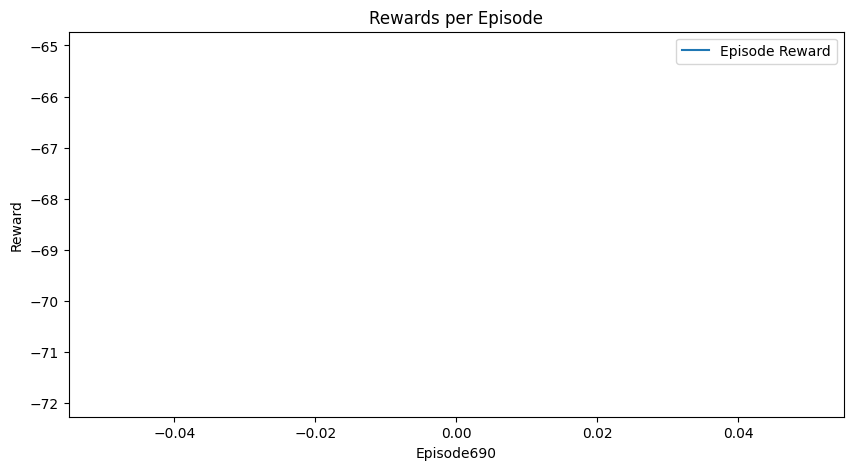

Episode 700	Average Score: -62.90


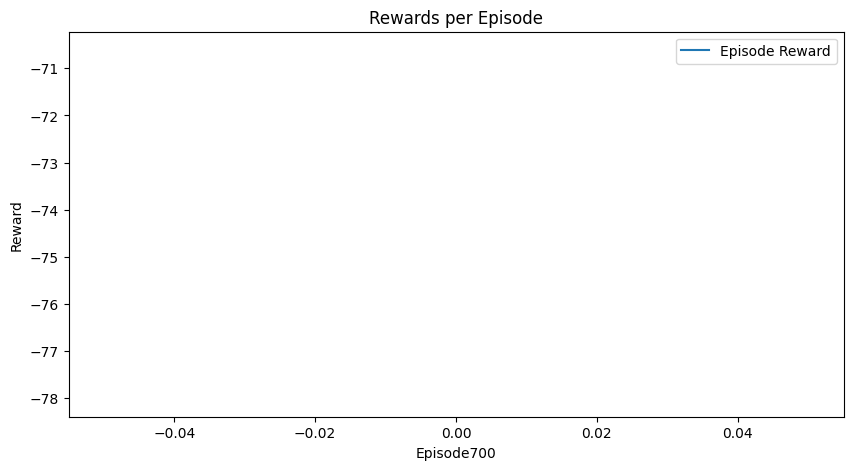

Episode 710	Average Score: -54.15


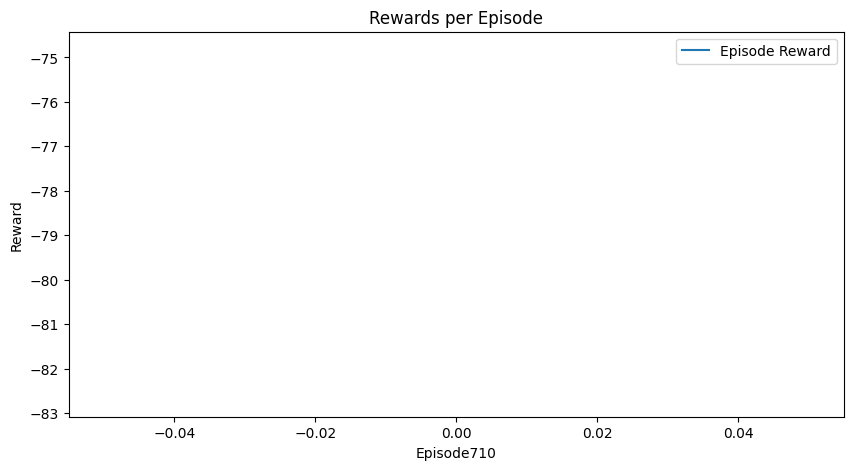

Episode 720	Average Score: -38.82


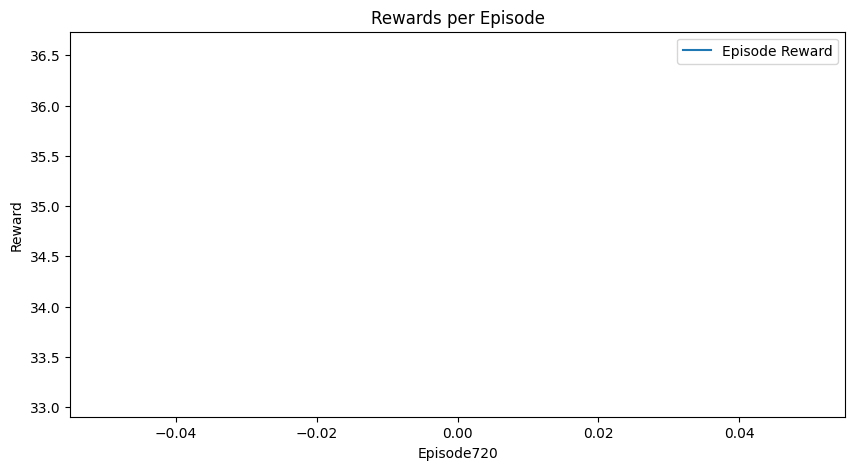

Episode 730	Average Score: -70.68


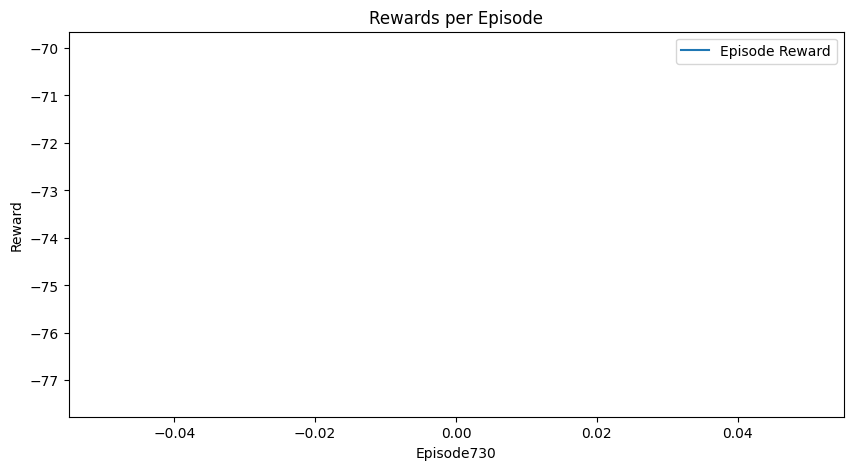

Episode 740	Average Score: -46.14


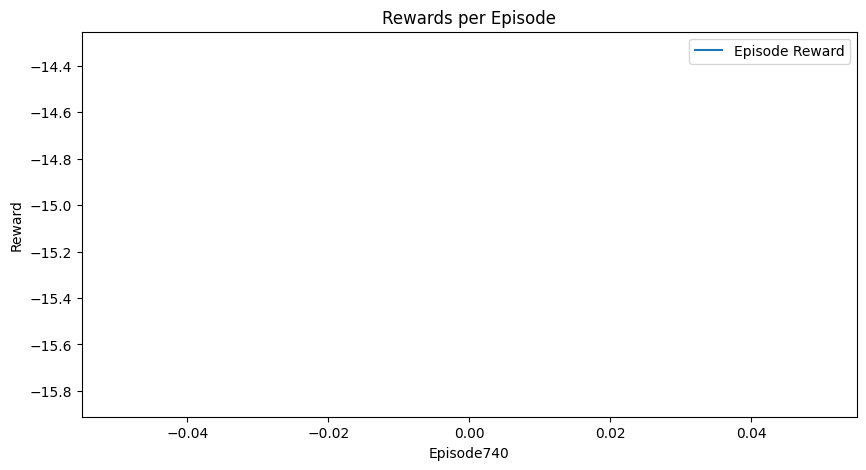

Episode 750	Average Score: -61.48


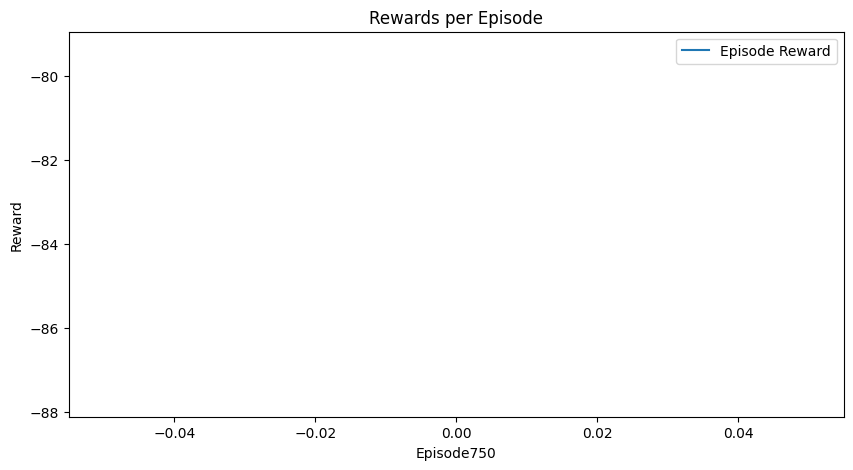

Episode 760	Average Score: -40.26


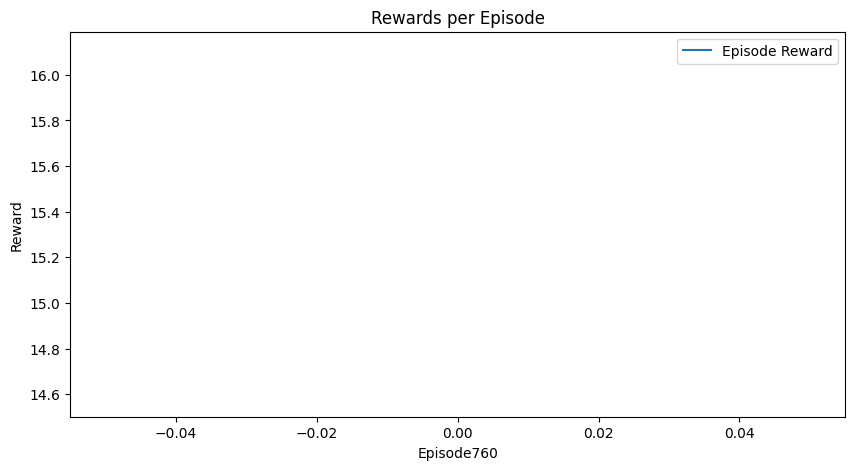

Episode 770	Average Score: -48.85


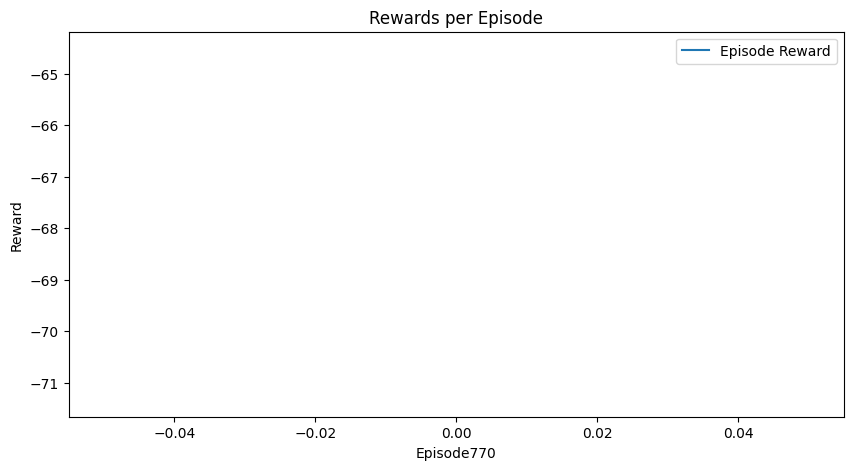

Episode 780	Average Score: -19.40


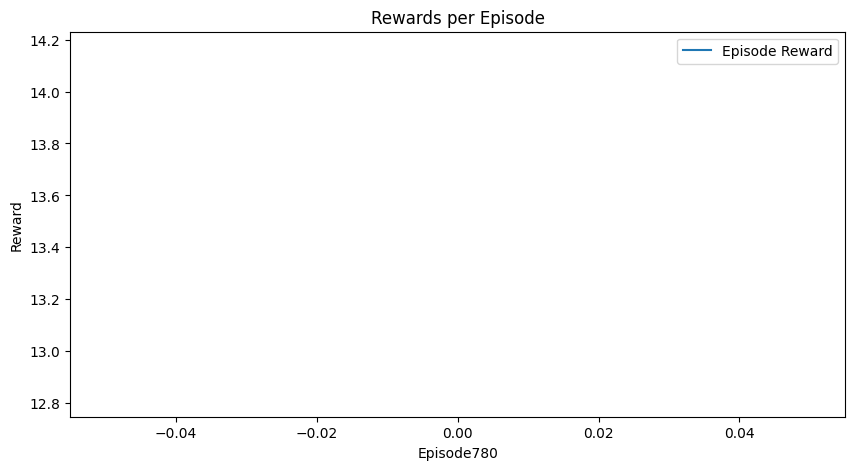

Episode 790	Average Score: -58.22


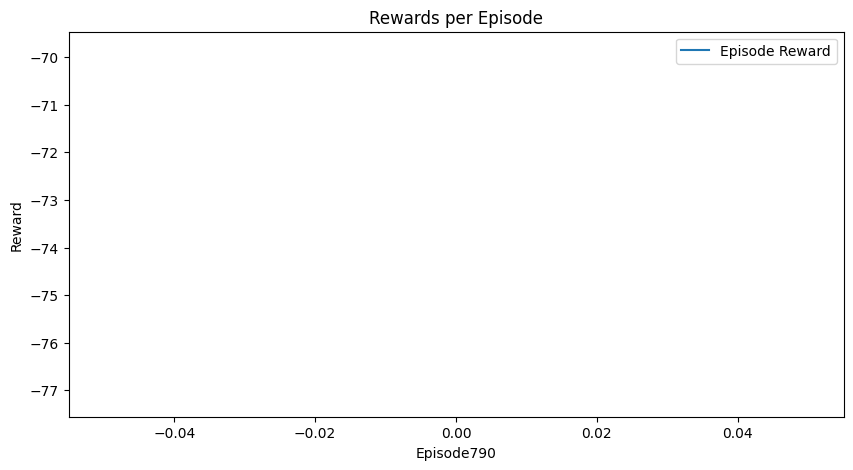

Episode 800	Average Score: -35.67


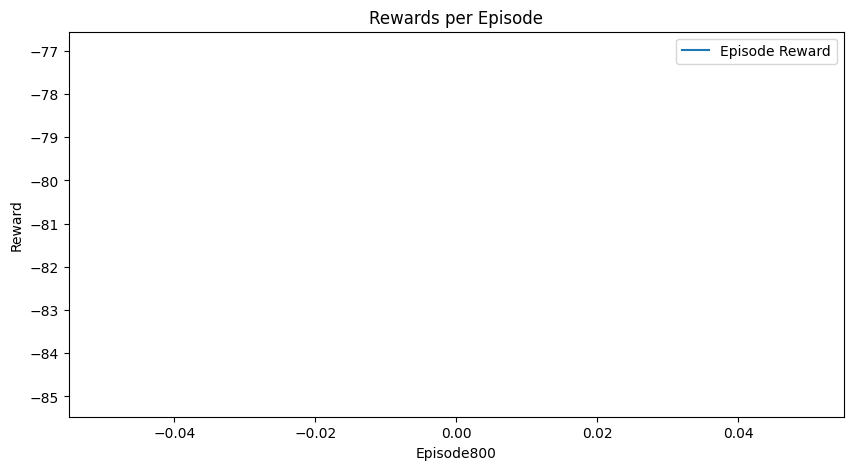

Episode 810	Average Score: -69.34


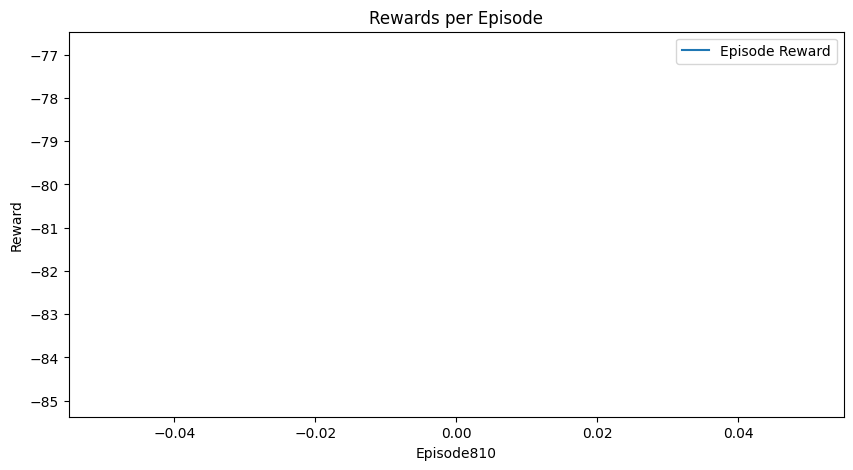

Episode 820	Average Score: -4.85


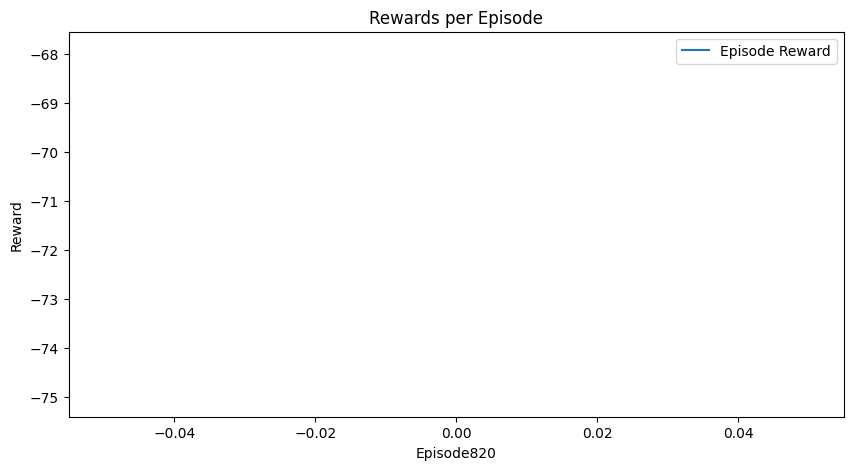

Episode 830	Average Score: -52.76


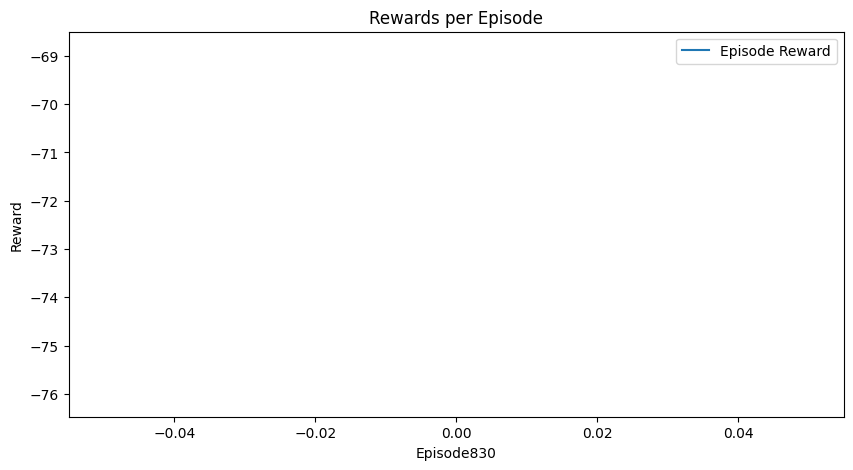

Episode 840	Average Score: -21.71


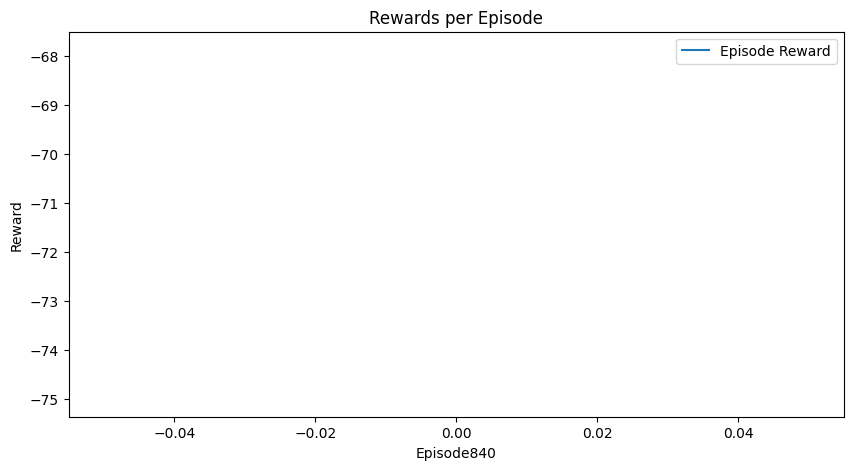

Episode 850	Average Score: -54.67


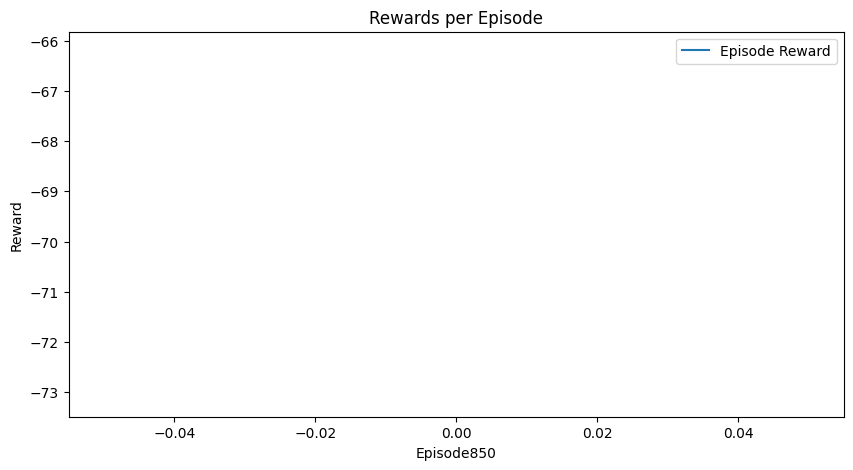

Episode 860	Average Score: -65.96


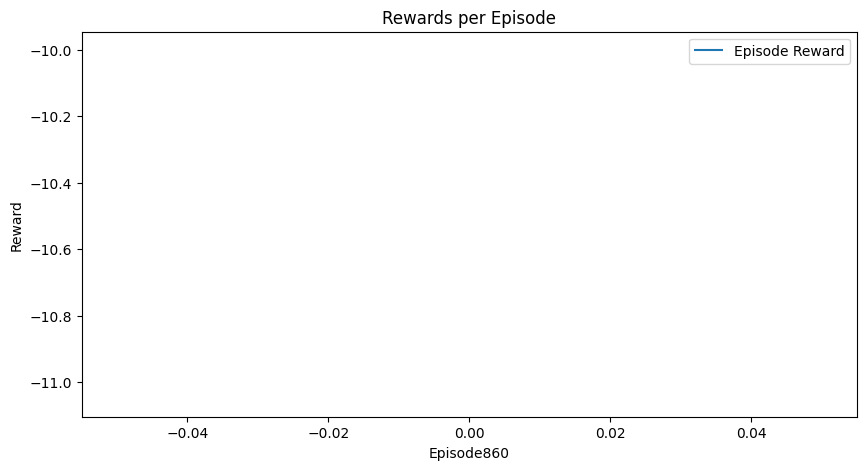

Episode 870	Average Score: -55.03


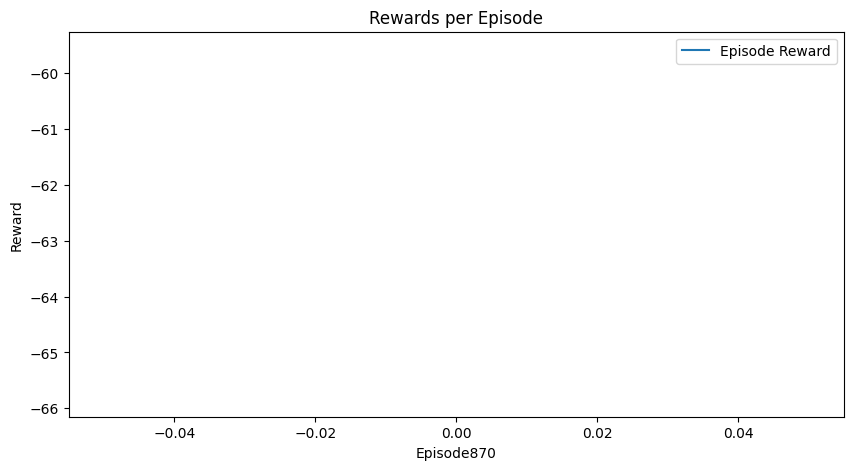

Episode 880	Average Score: -40.87


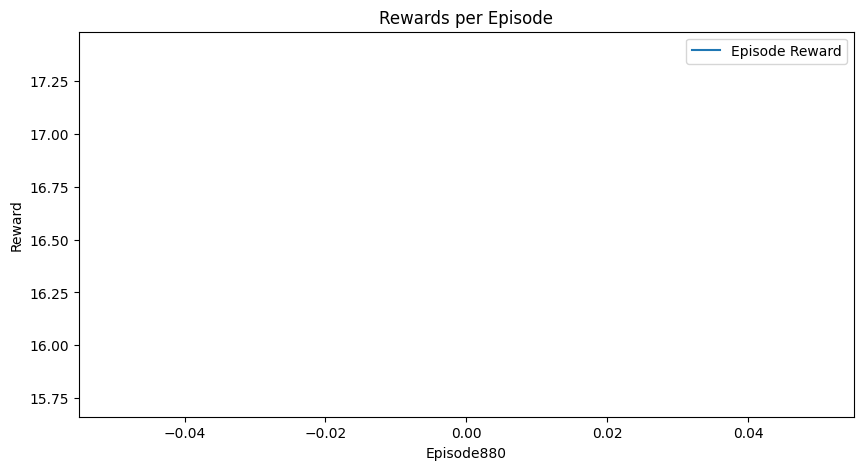

Episode 890	Average Score: -36.48


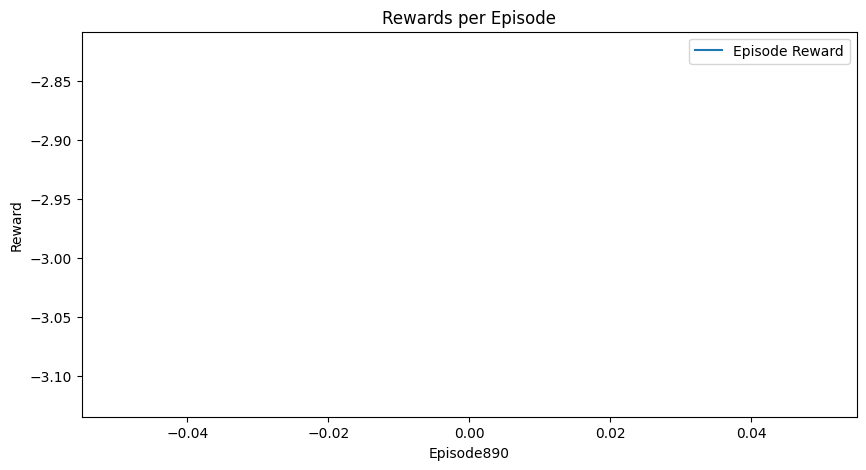

Episode 900	Average Score: -59.23


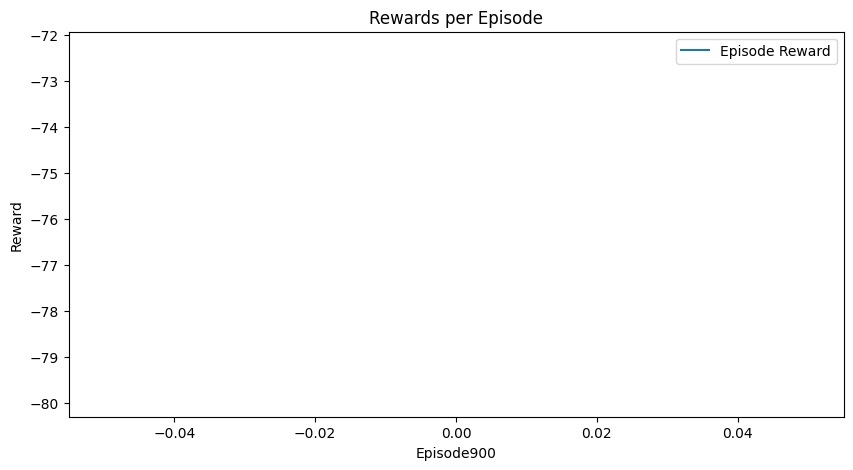

Episode 910	Average Score: -48.01


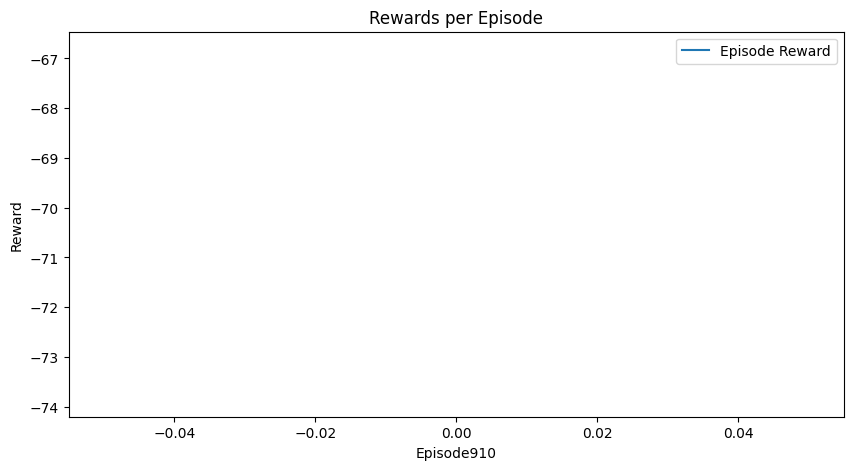

Episode 920	Average Score: -33.51


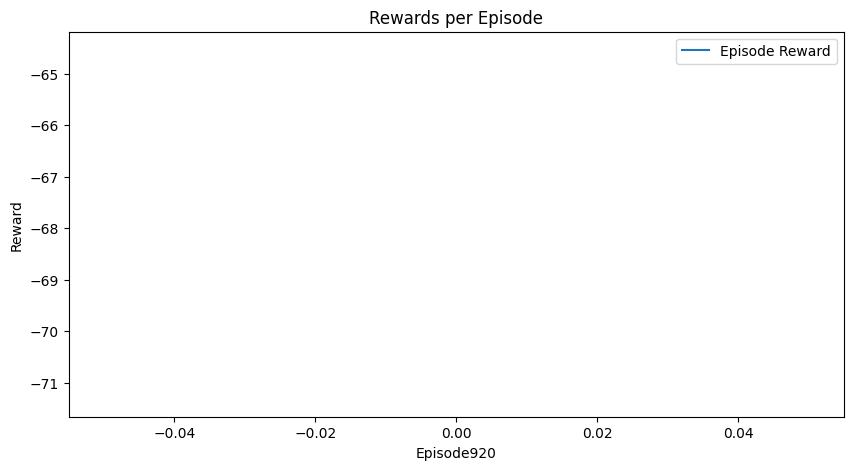

Episode 930	Average Score: -63.64


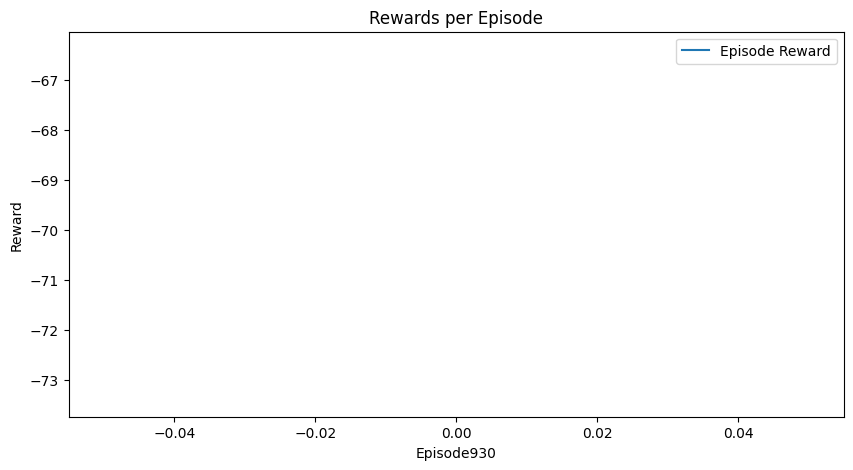

Episode 940	Average Score: -60.68


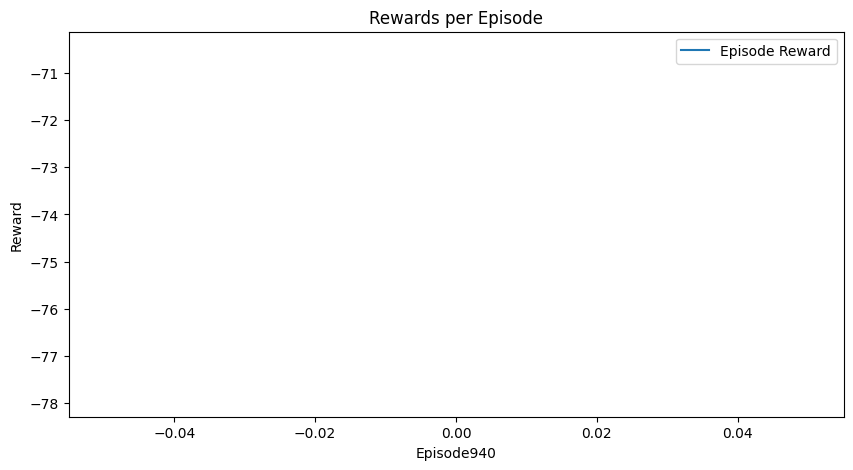

Episode 950	Average Score: -62.09


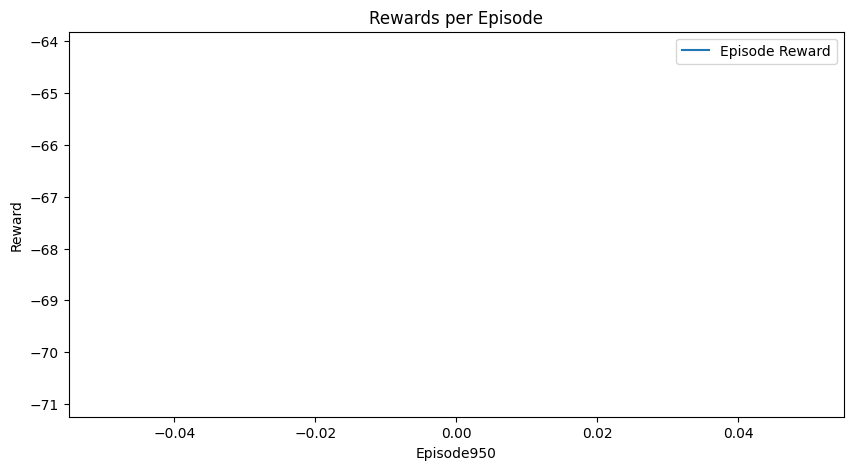

Episode 960	Average Score: -53.40


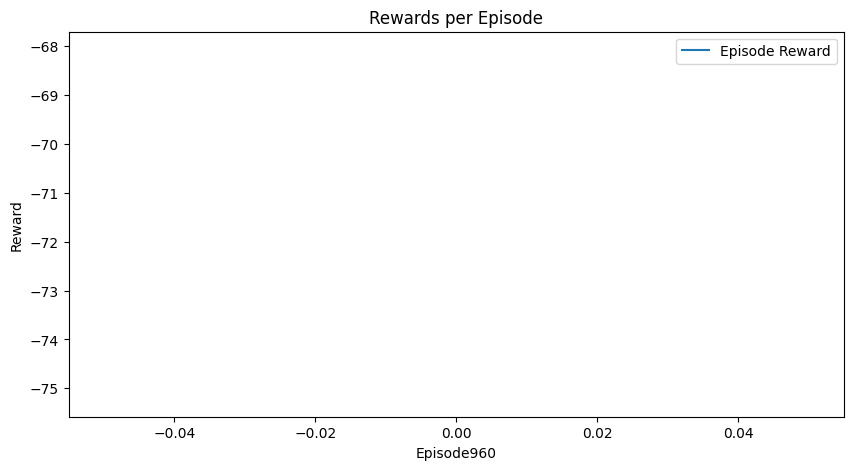

Episode 970	Average Score: -55.19


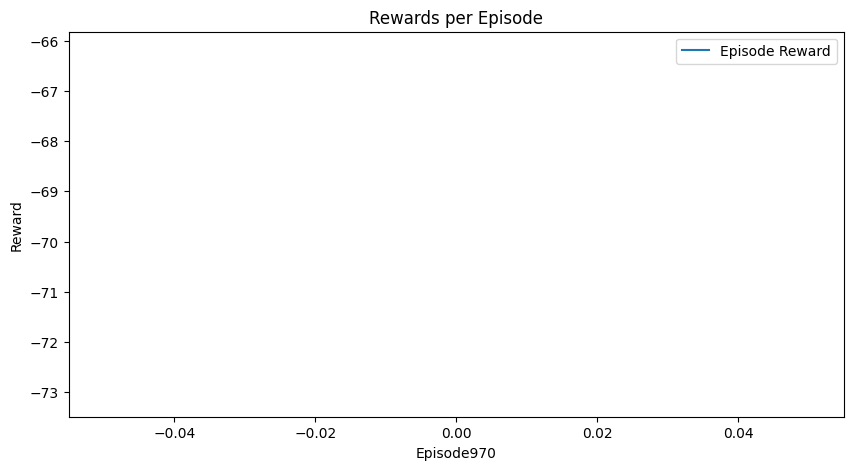

Episode 980	Average Score: -58.81


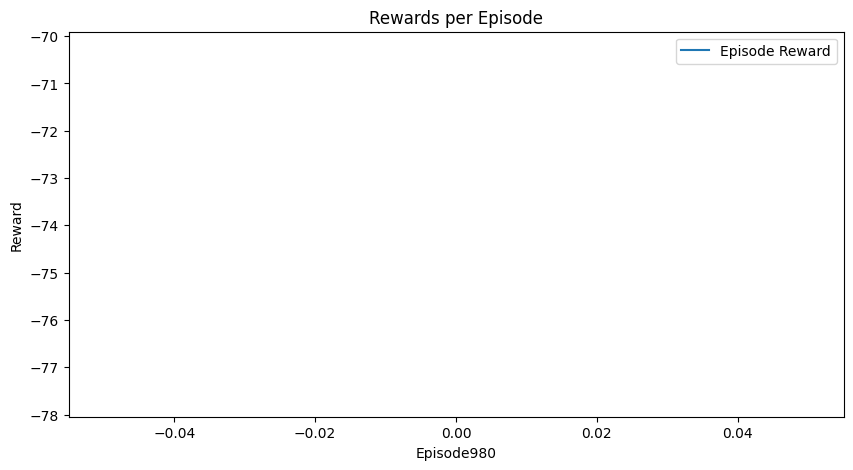

Episode 990	Average Score: -69.95


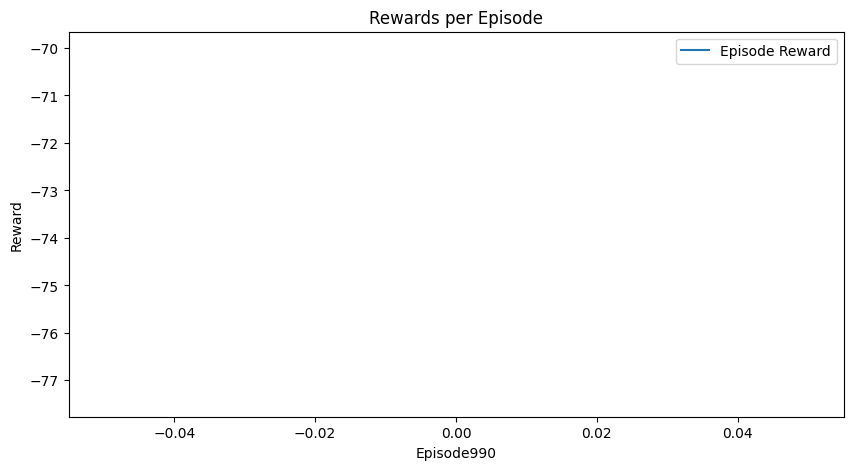

Episode 1000	Average Score: -61.32


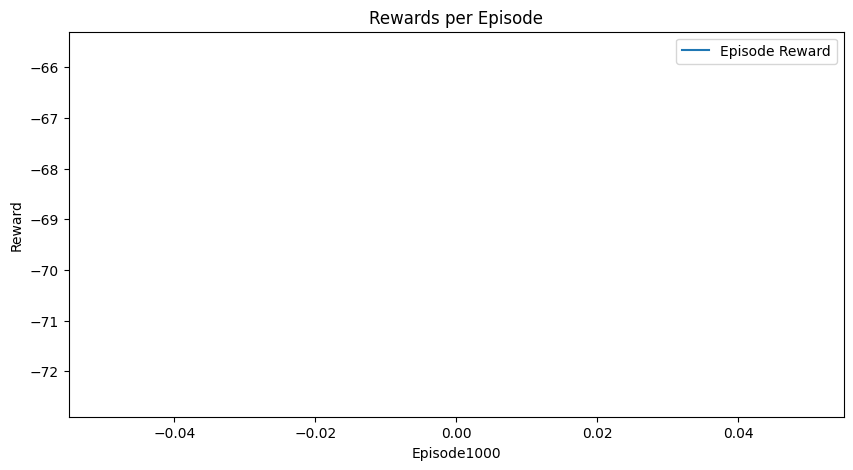

Episode 1010	Average Score: -54.19


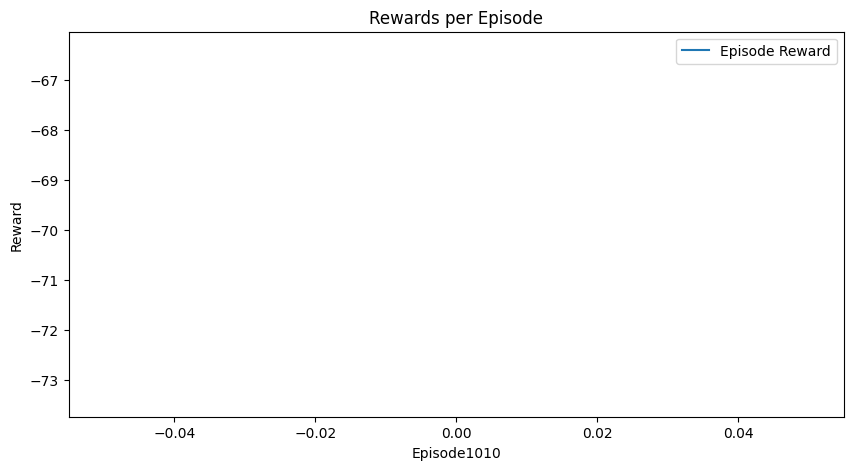

Episode 1020	Average Score: -43.20


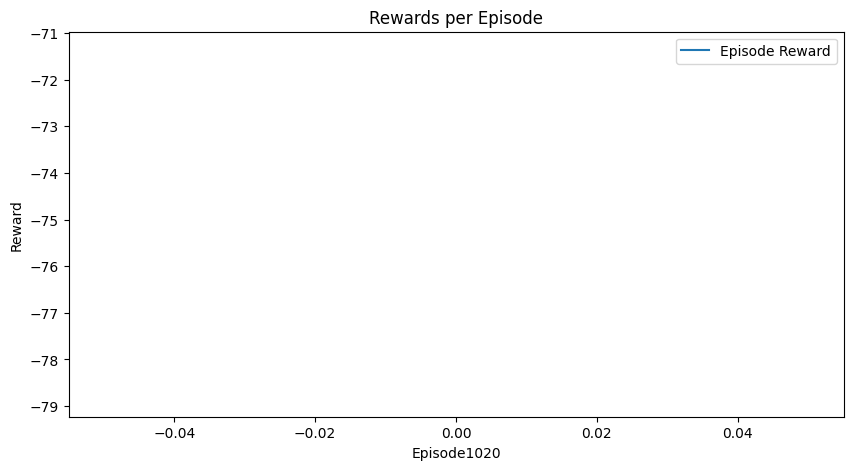

Episode 1030	Average Score: -31.96


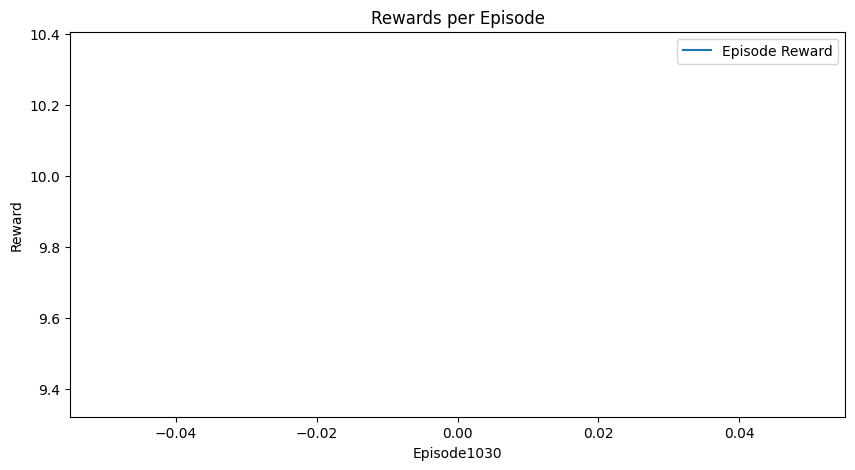

Episode 1040	Average Score: -62.84


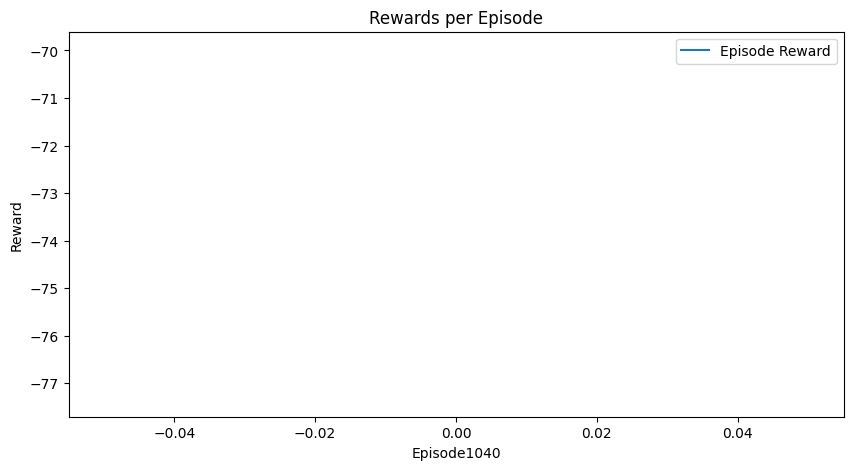

Episode 1050	Average Score: -32.76


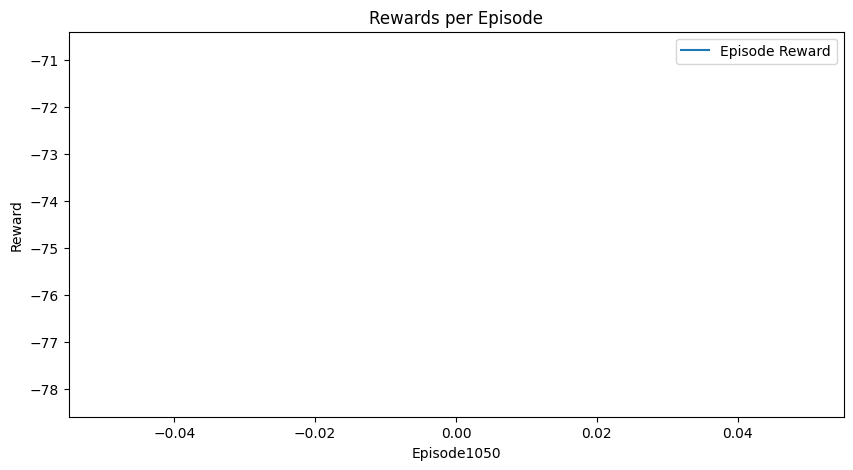

Episode 1060	Average Score: -58.01


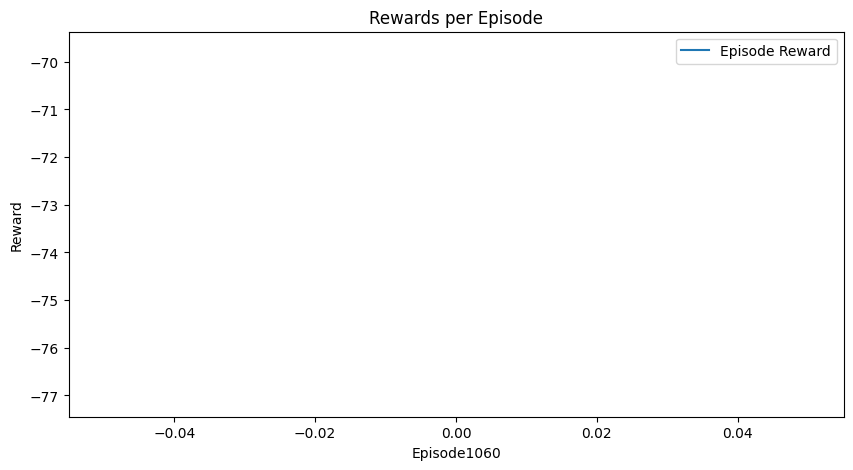

Episode 1070	Average Score: -42.34


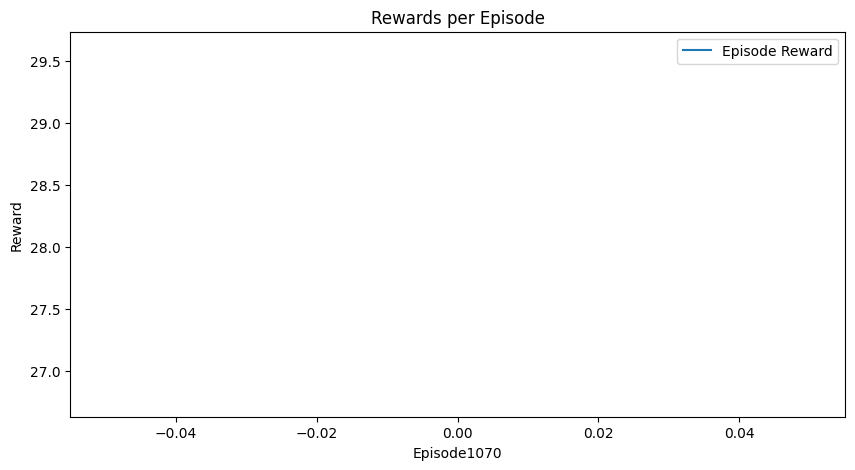

Episode 1080	Average Score: -72.51


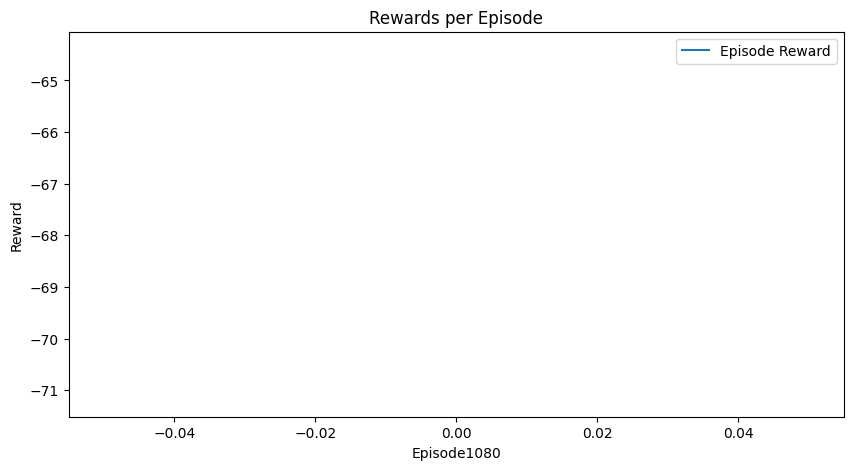

Episode 1090	Average Score: -11.87


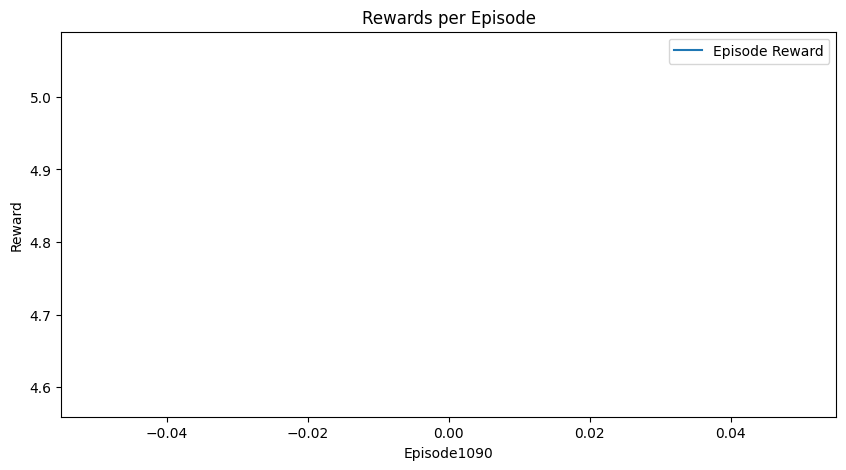

Episode 1100	Average Score: -64.56


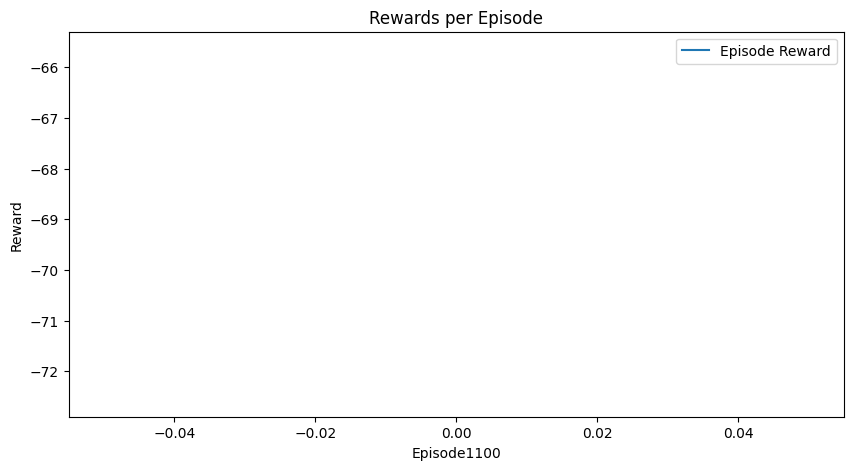

Episode 1110	Average Score: -70.45


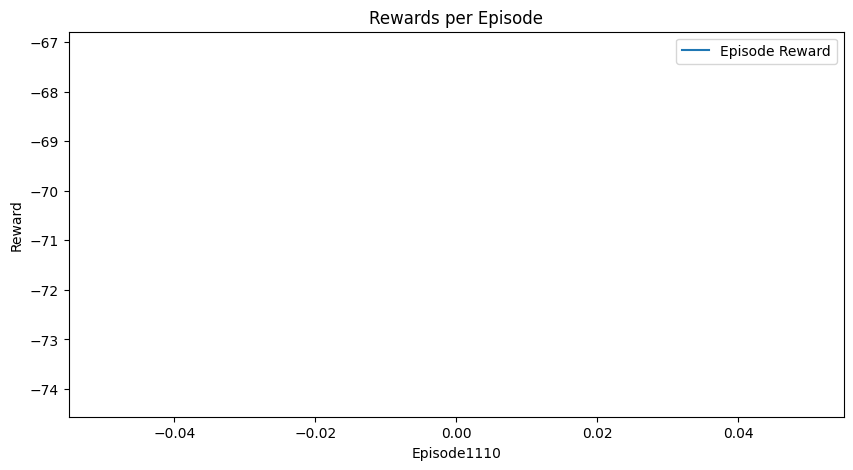

Episode 1120	Average Score: -50.61


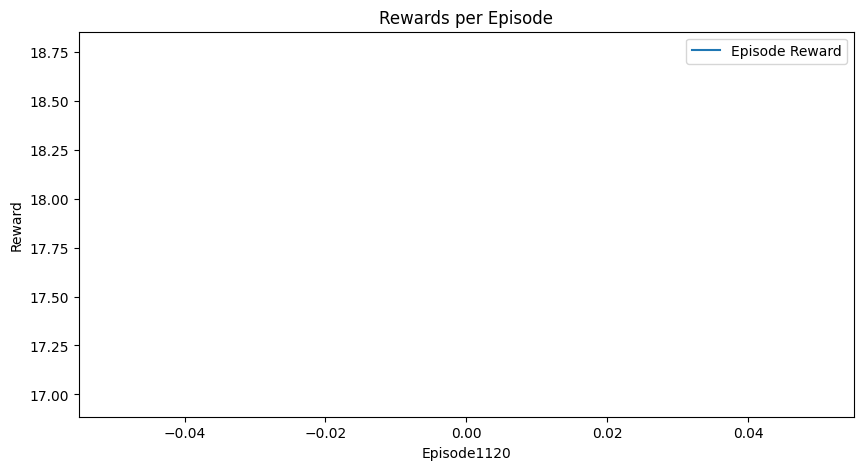

Episode 1130	Average Score: -64.13


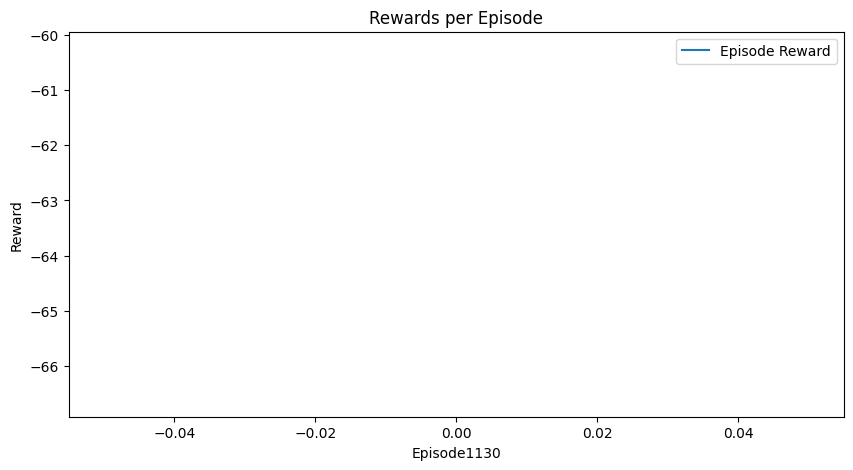

Episode 1140	Average Score: -58.47


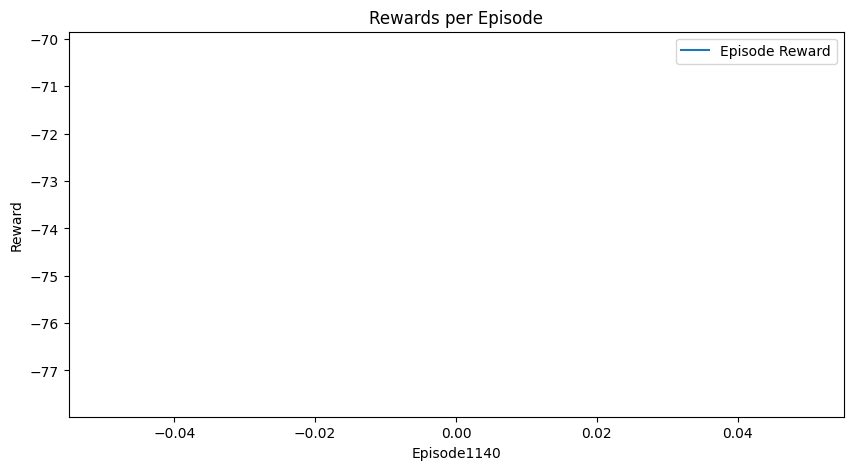

Episode 1150	Average Score: -32.42


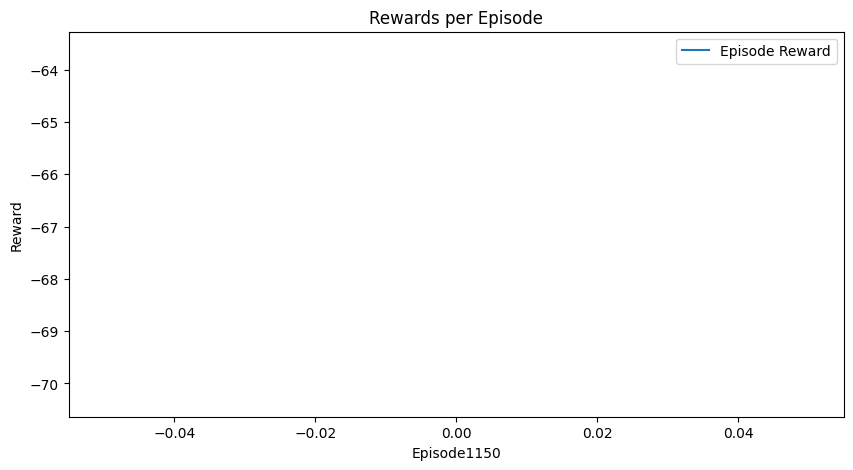

Episode 1160	Average Score: -53.79


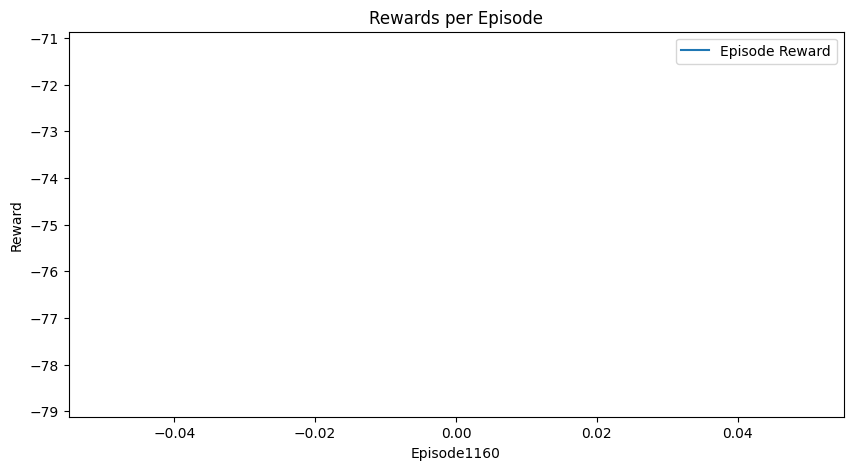

Episode 1170	Average Score: -32.52


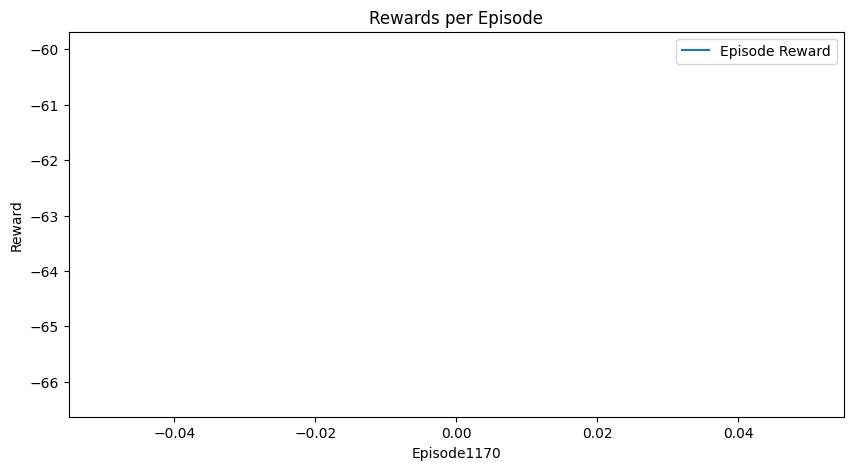

Episode 1180	Average Score: -49.66


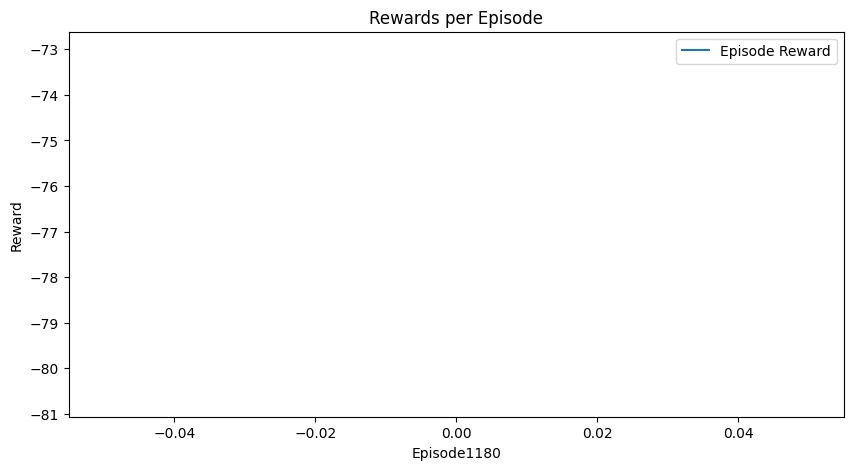

Episode 1190	Average Score: -41.96


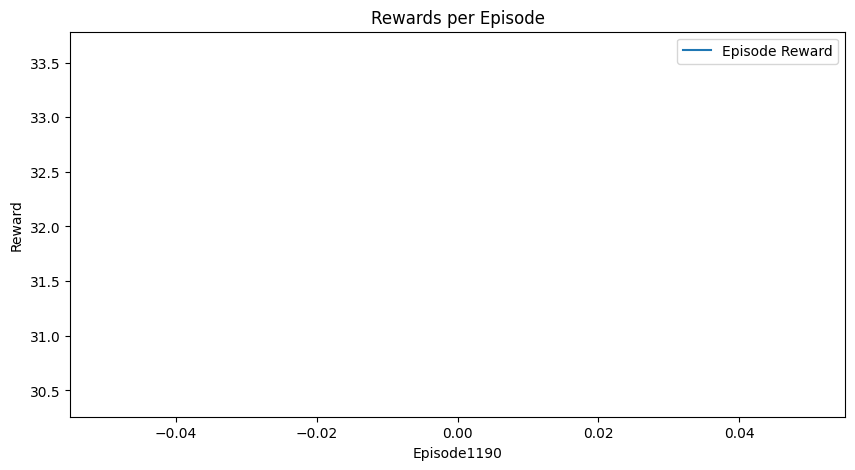

Episode 1200	Average Score: -29.44


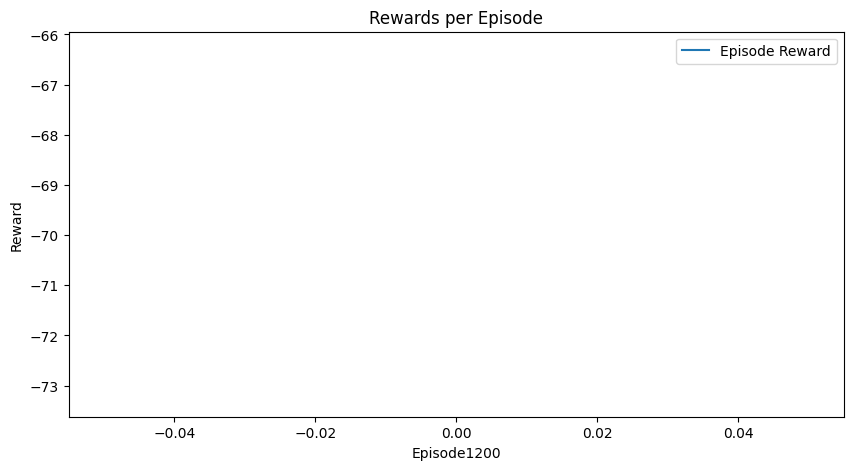

Episode 1210	Average Score: -49.71


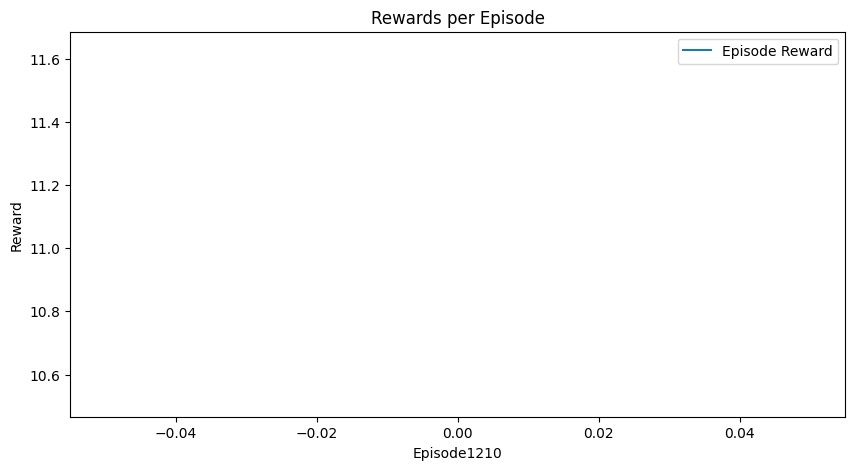

Episode 1220	Average Score: -52.95


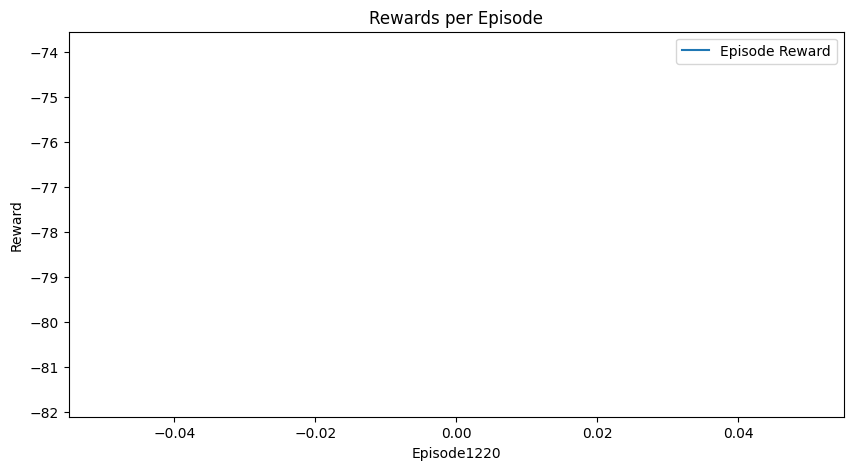

Episode 1230	Average Score: -48.20


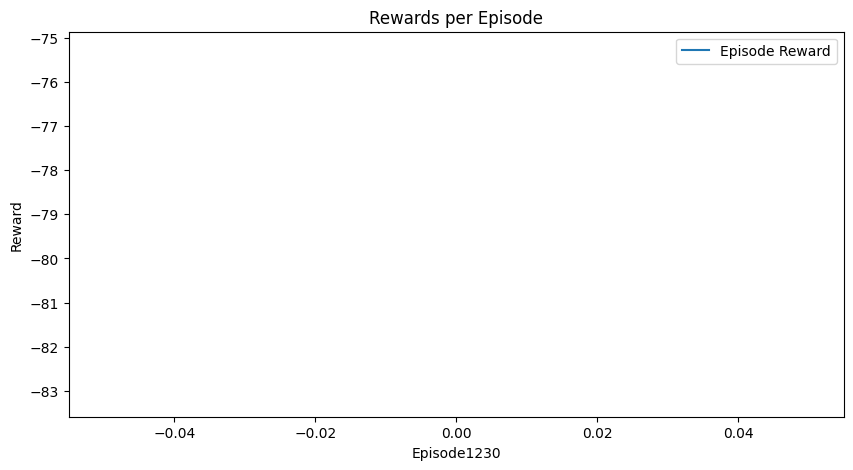

Episode 1240	Average Score: -42.91


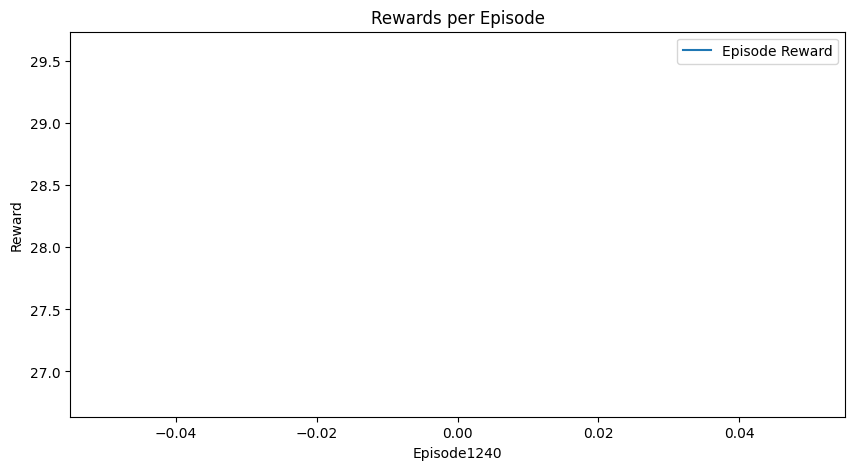

Episode 1250	Average Score: -61.70


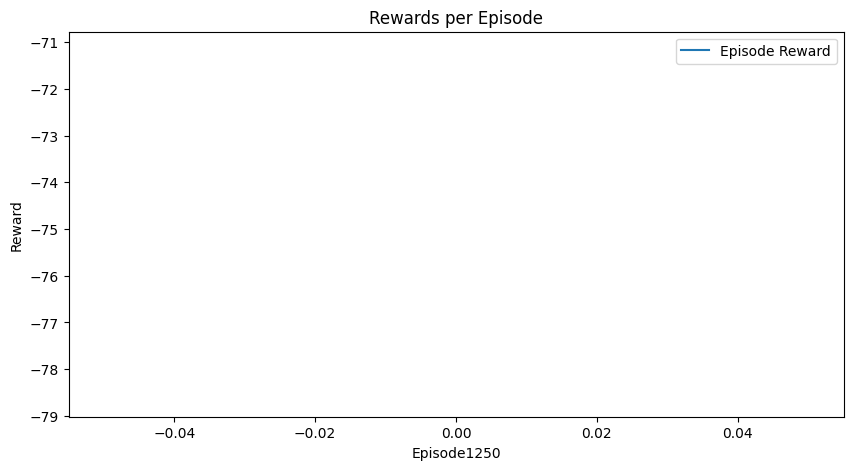

Episode 1260	Average Score: -42.57


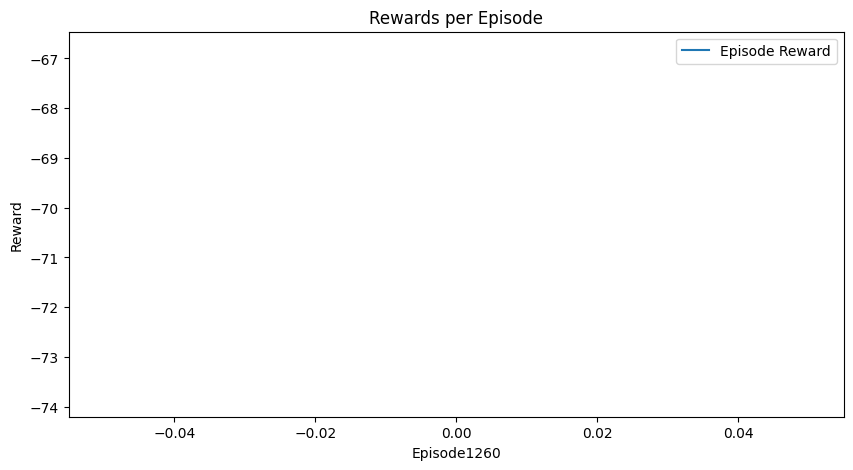

Episode 1270	Average Score: -47.34


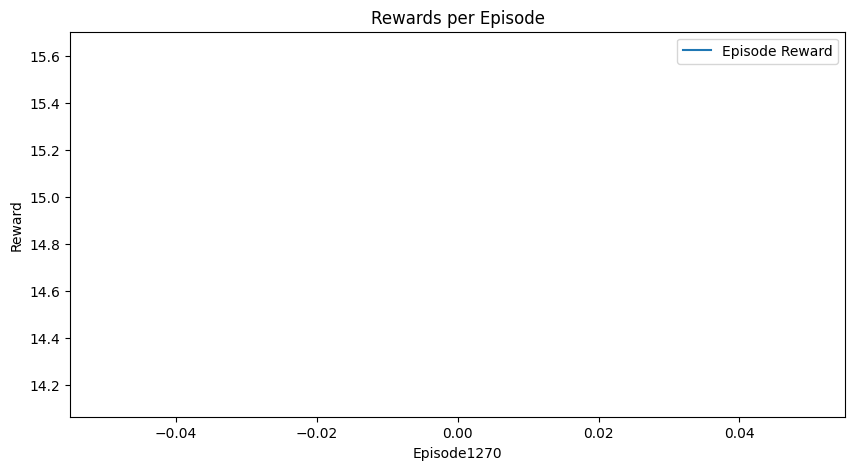

Episode 1280	Average Score: -70.89


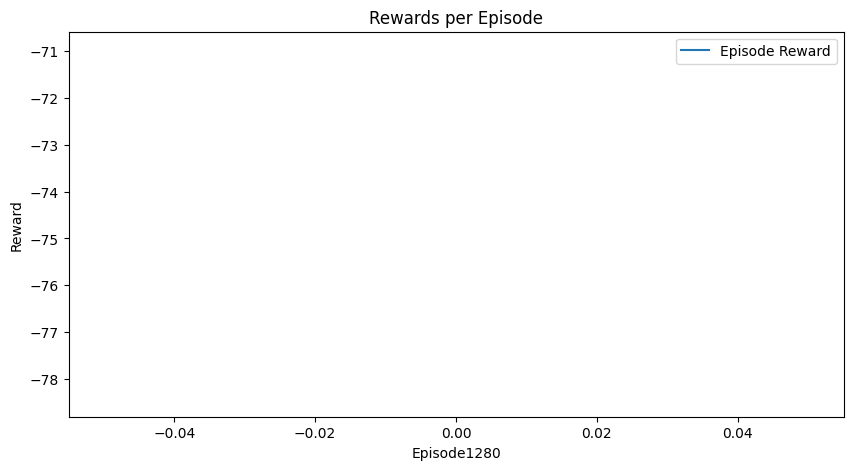

Episode 1290	Average Score: -51.73


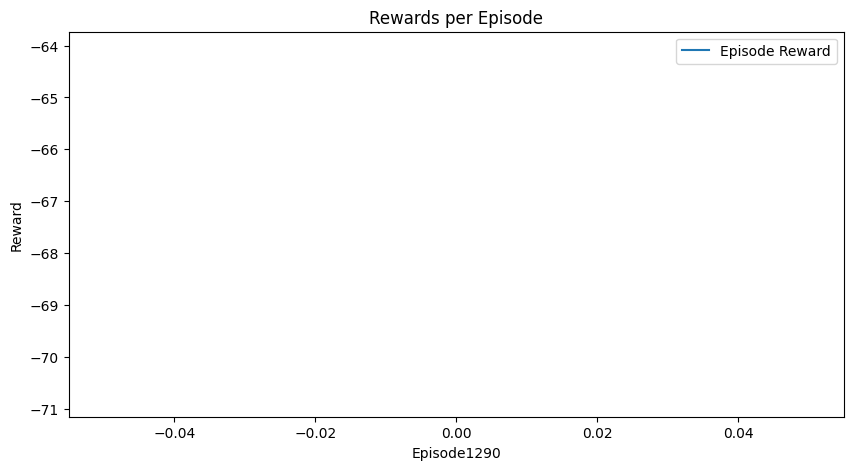

Episode 1300	Average Score: -62.86


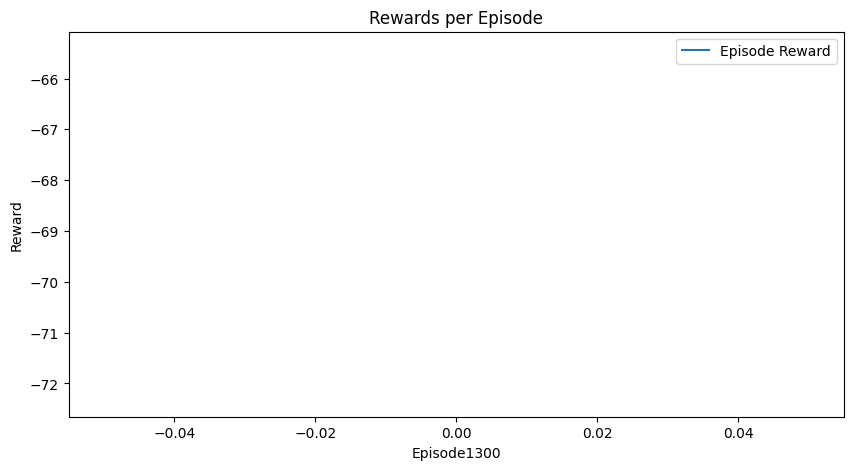

Episode 1310	Average Score: -52.00


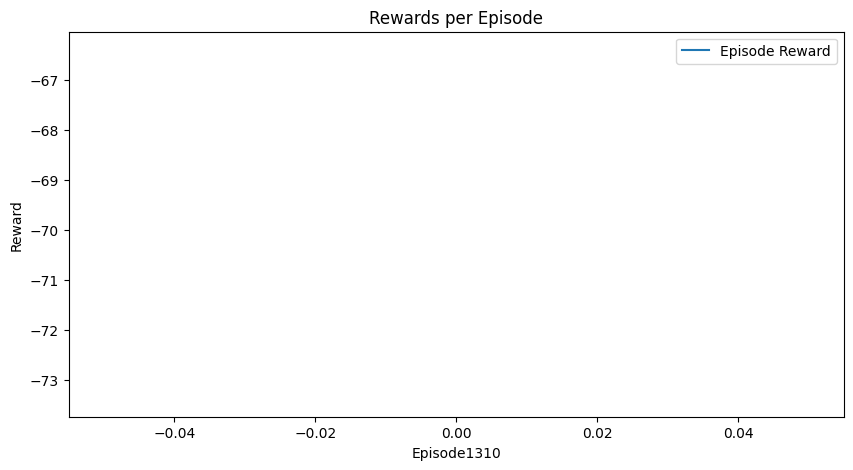

Episode 1320	Average Score: -41.77


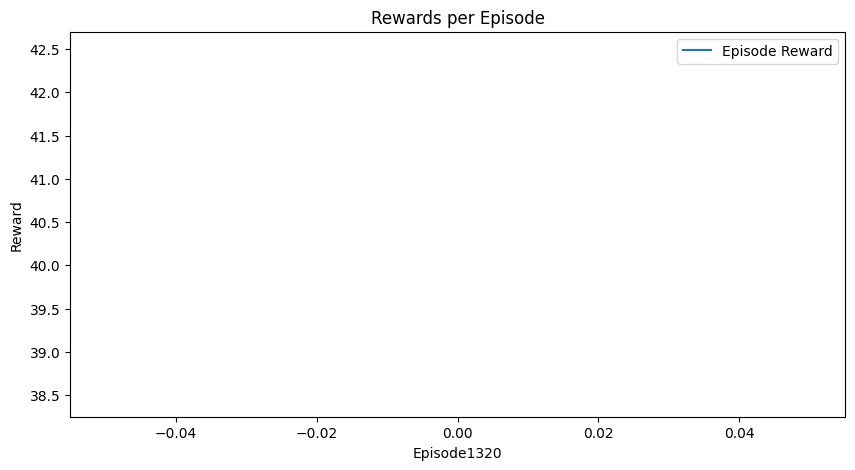

Episode 1330	Average Score: -63.81


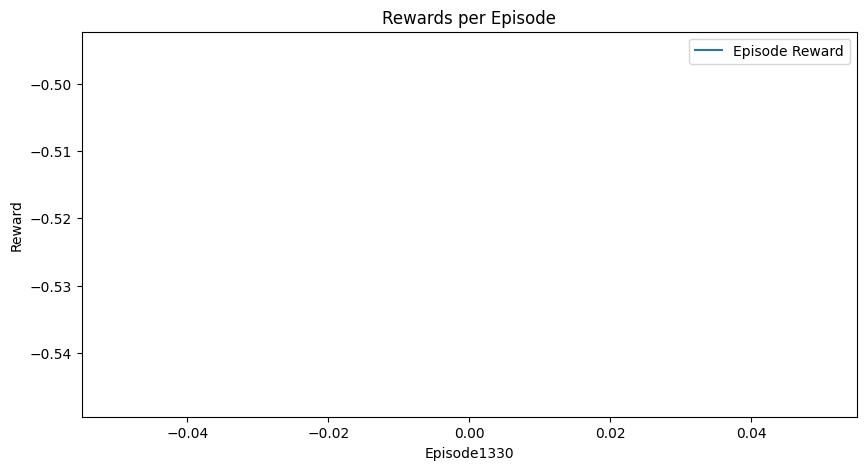

Episode 1340	Average Score: -53.04


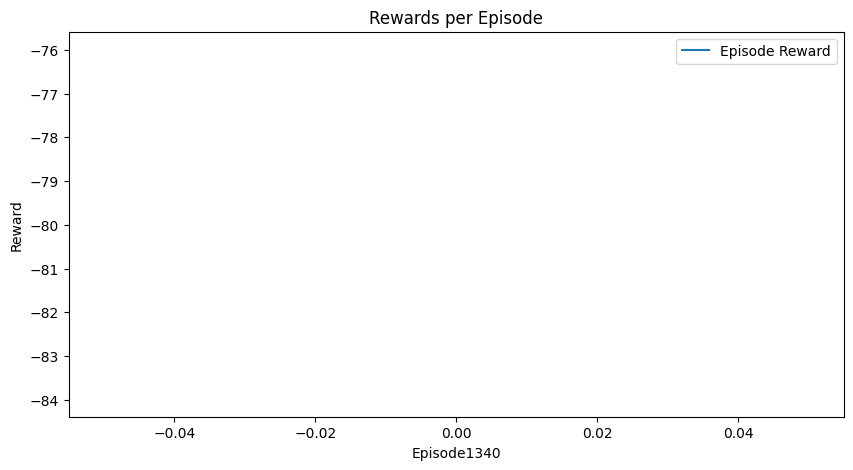

Episode 1350	Average Score: -36.07


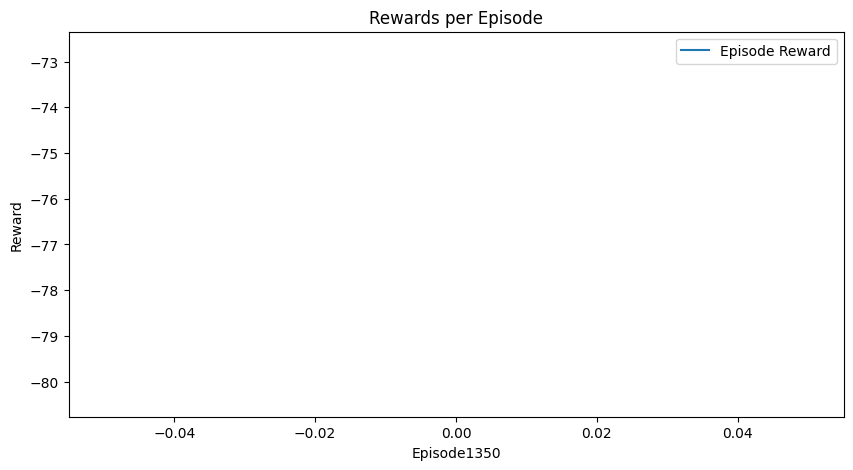

Episode 1360	Average Score: -61.87


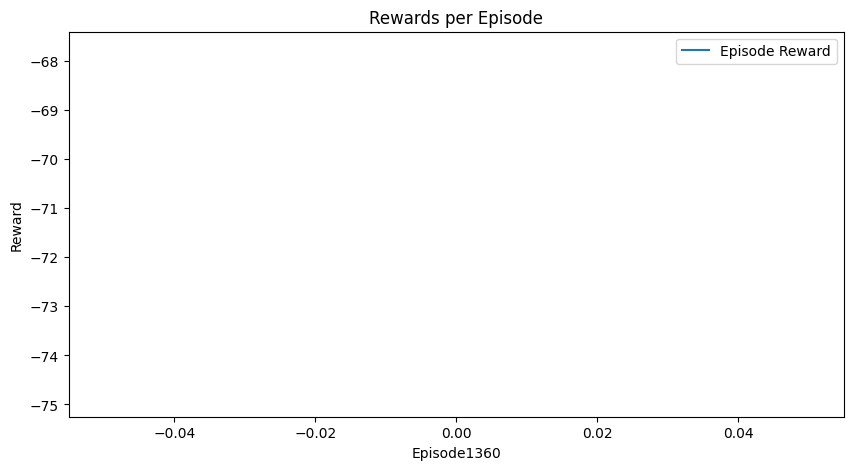

Episode 1370	Average Score: -58.44


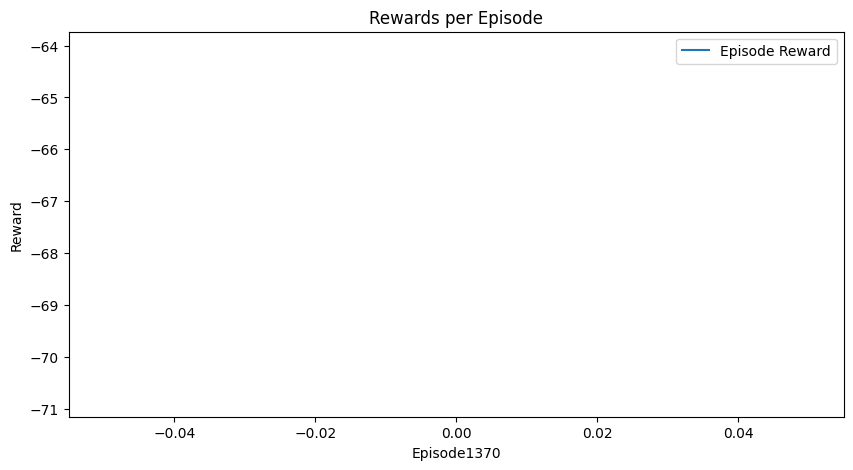

Episode 1380	Average Score: -65.18


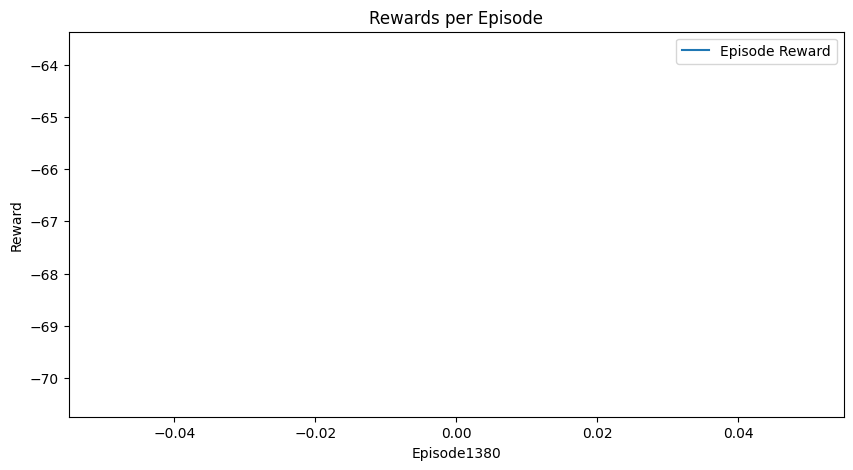

Episode 1390	Average Score: -47.70


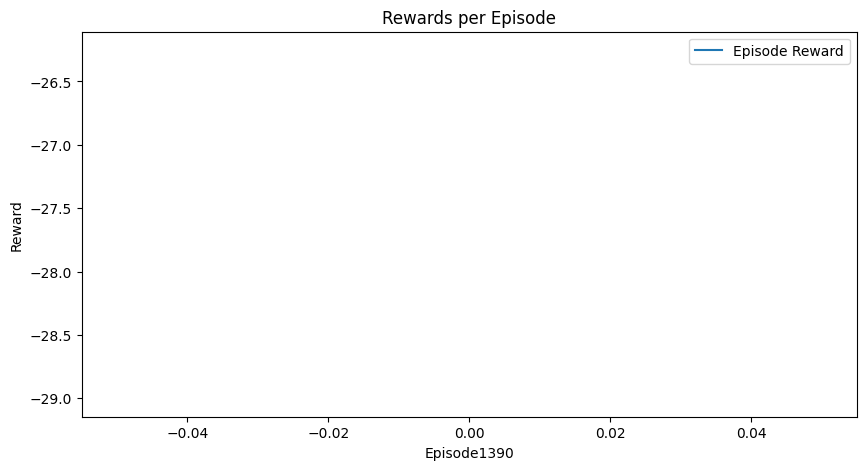

Episode 1400	Average Score: -62.06


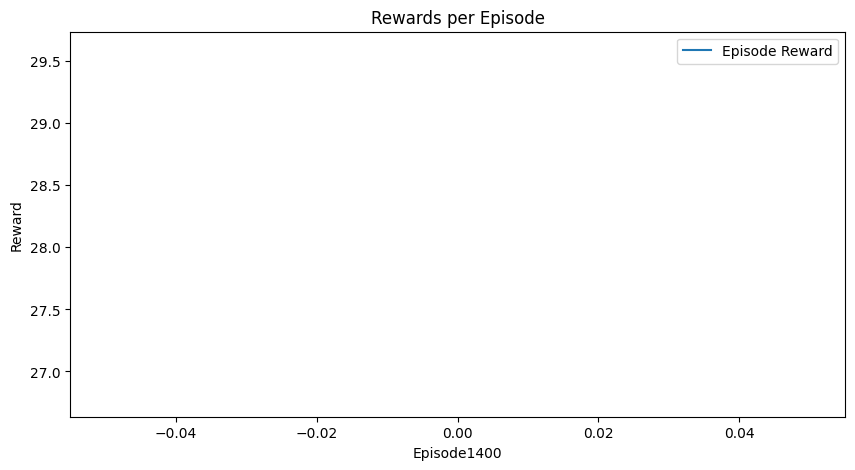

Episode 1410	Average Score: -71.07


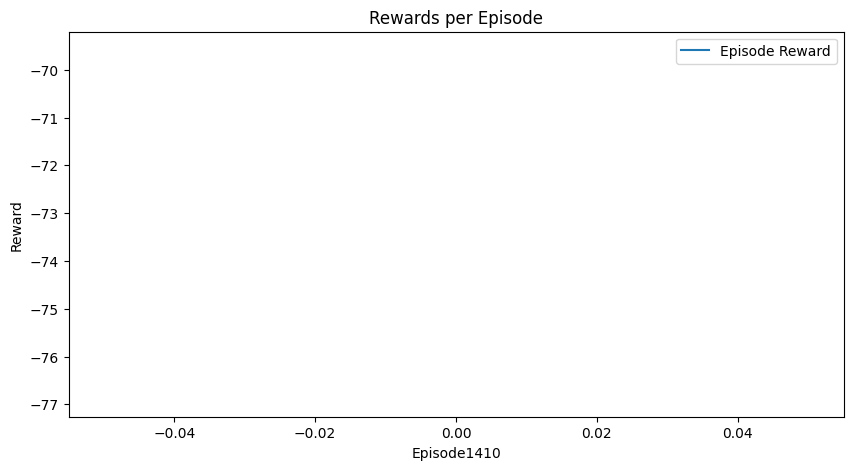

Episode 1420	Average Score: -72.73


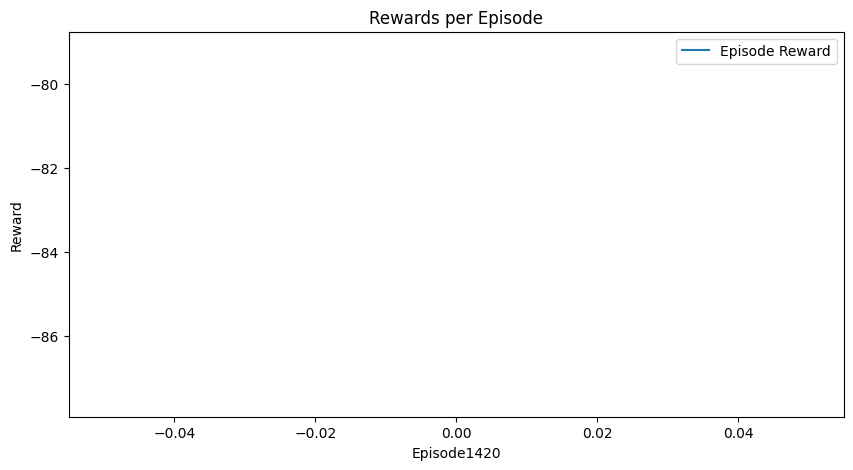

Episode 1430	Average Score: -45.27


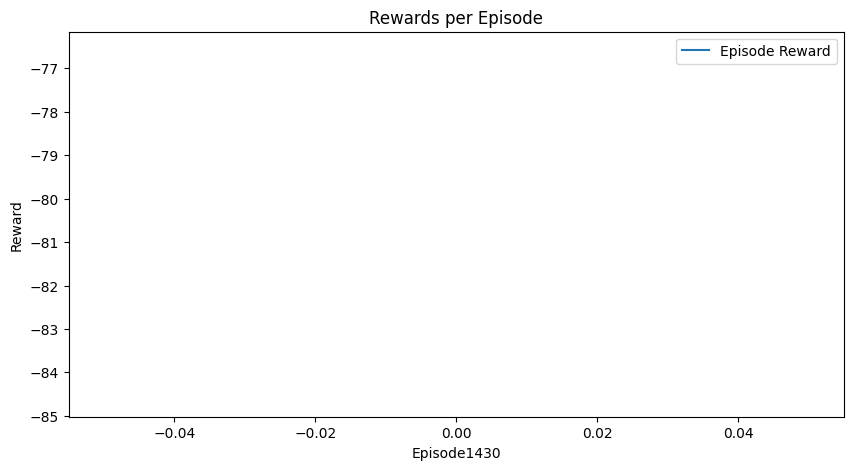

Episode 1440	Average Score: -37.18


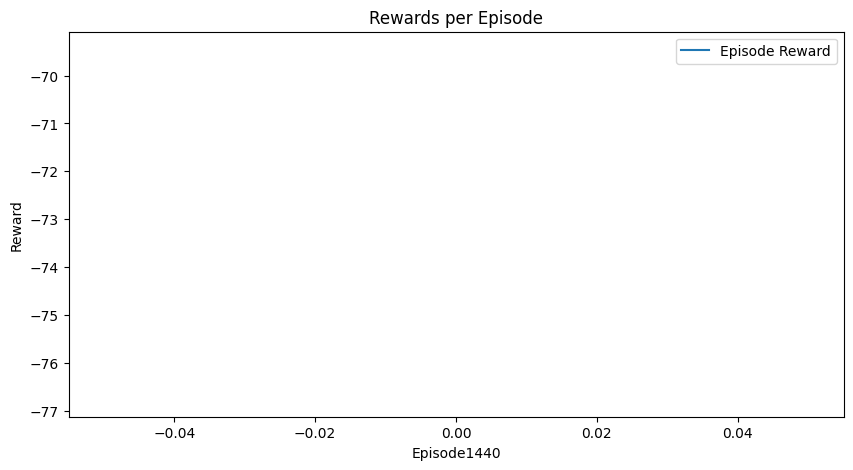

Episode 1450	Average Score: -59.44


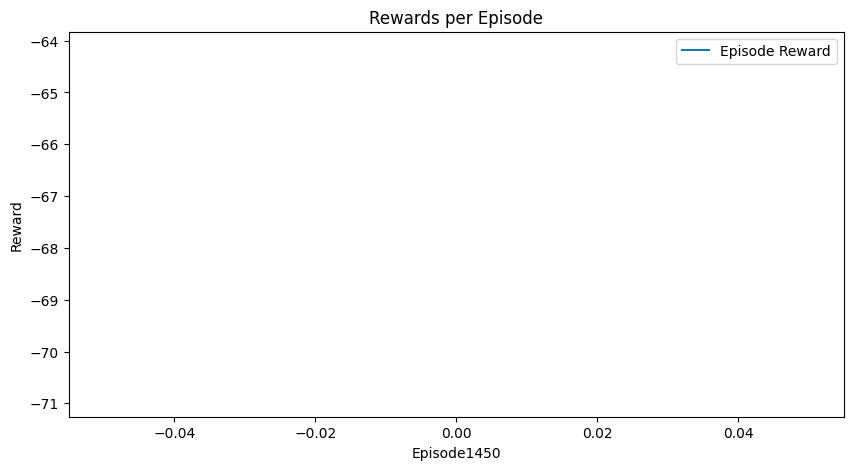

Episode 1460	Average Score: -49.18


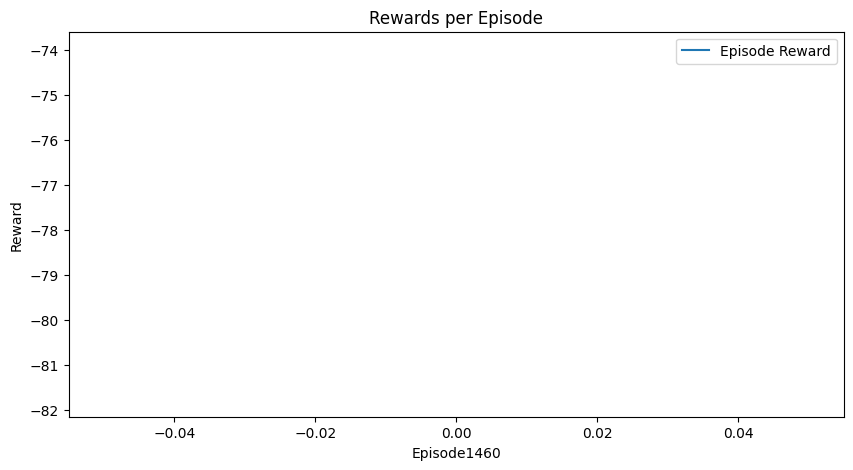

Episode 1470	Average Score: -53.84


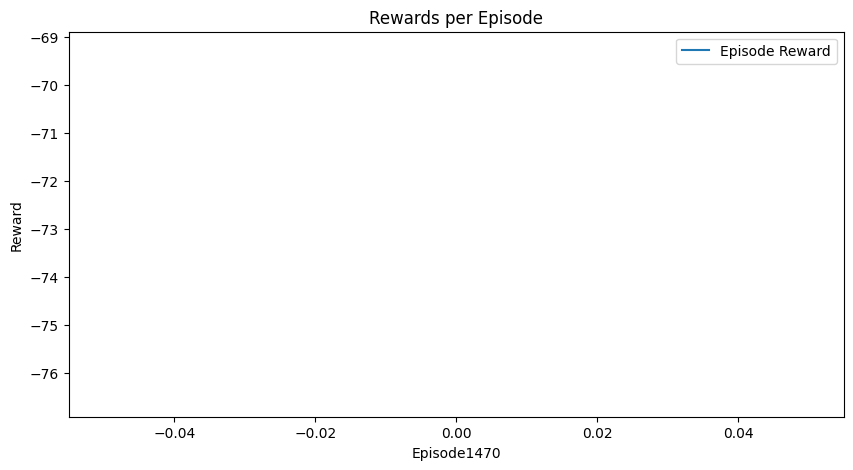

Episode 1480	Average Score: -59.26


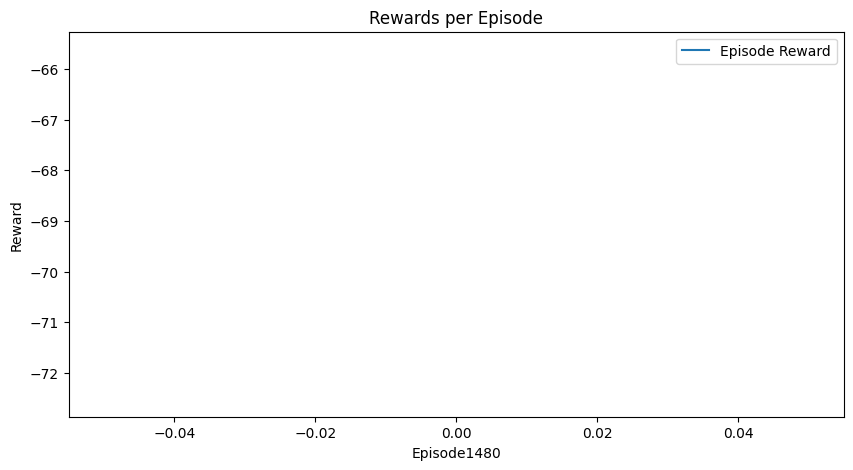

Episode 1490	Average Score: -65.75


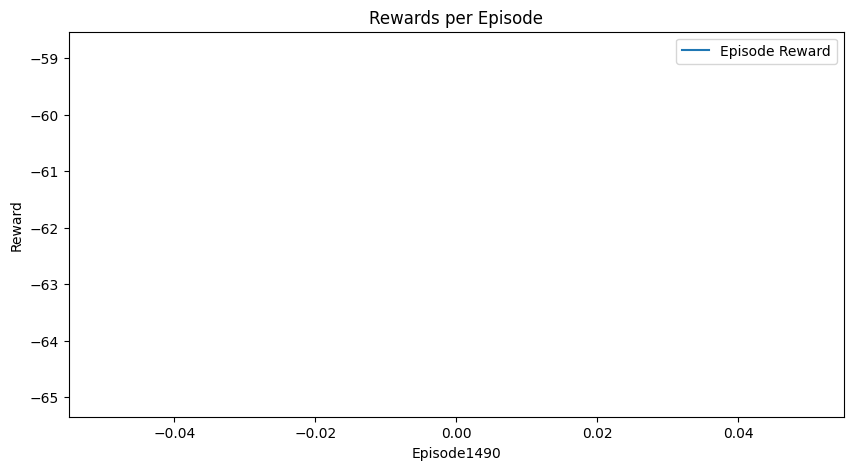

Episode 1500	Average Score: -50.73


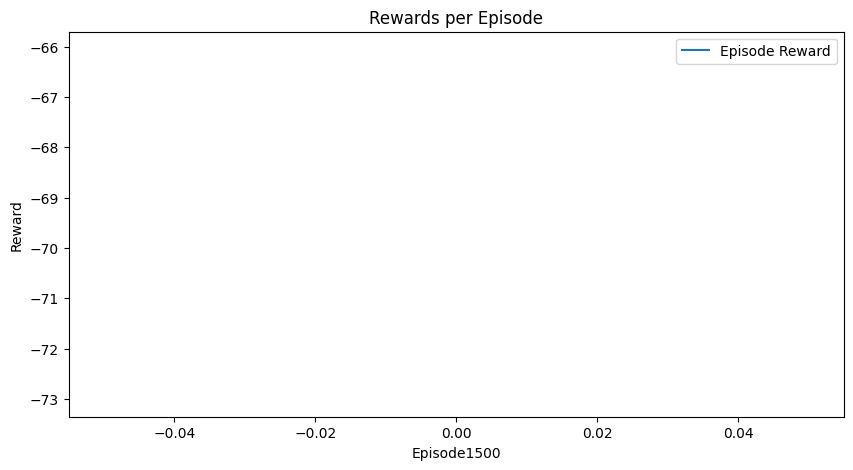

Episode 1510	Average Score: -59.95


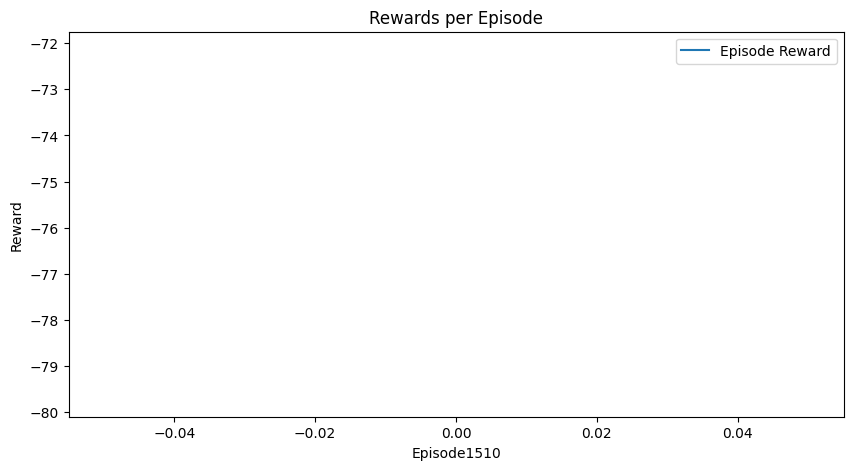

Episode 1520	Average Score: -50.37


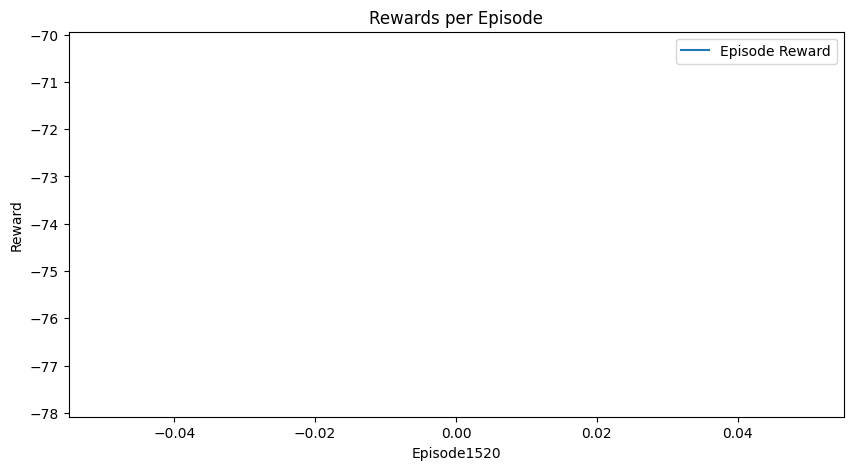

Episode 1530	Average Score: -39.13


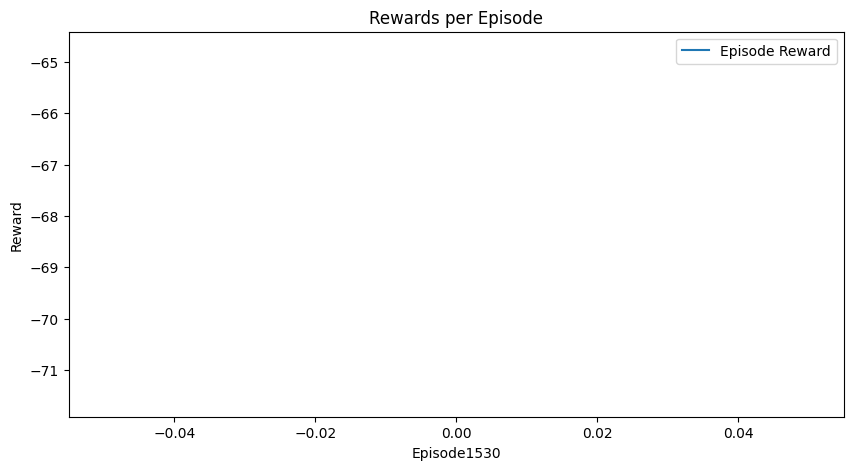

Episode 1540	Average Score: -57.43


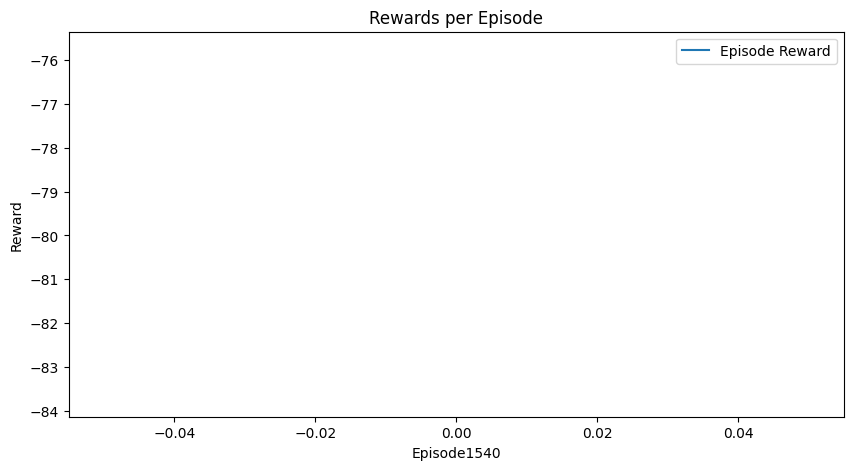

Episode 1550	Average Score: -47.26


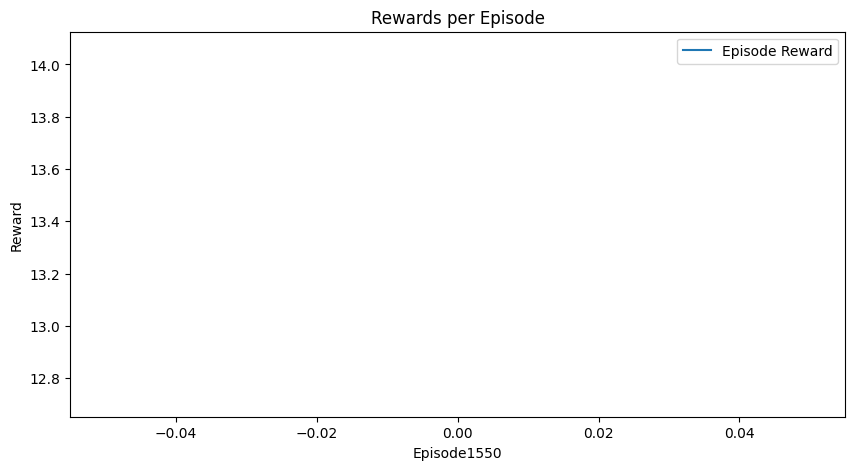

Episode 1560	Average Score: -38.90


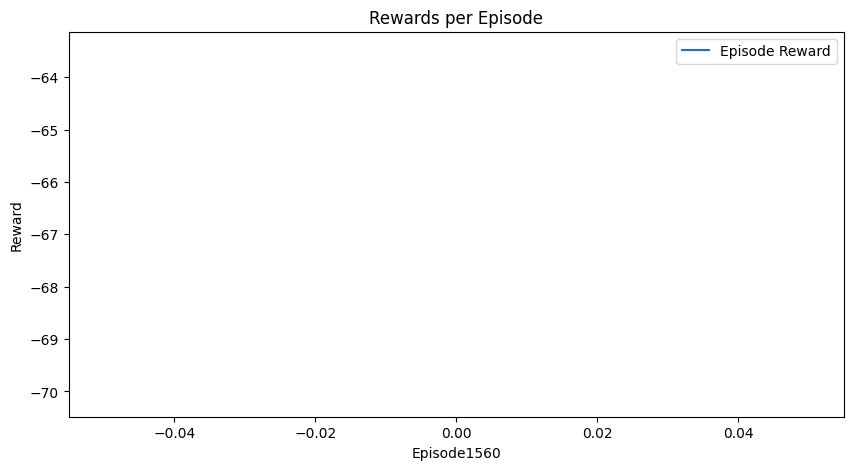

Episode 1570	Average Score: -34.97


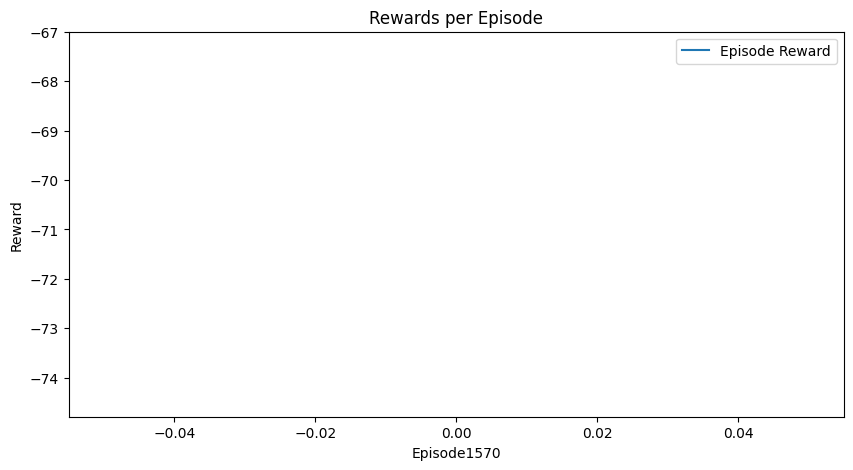

Episode 1580	Average Score: -71.78


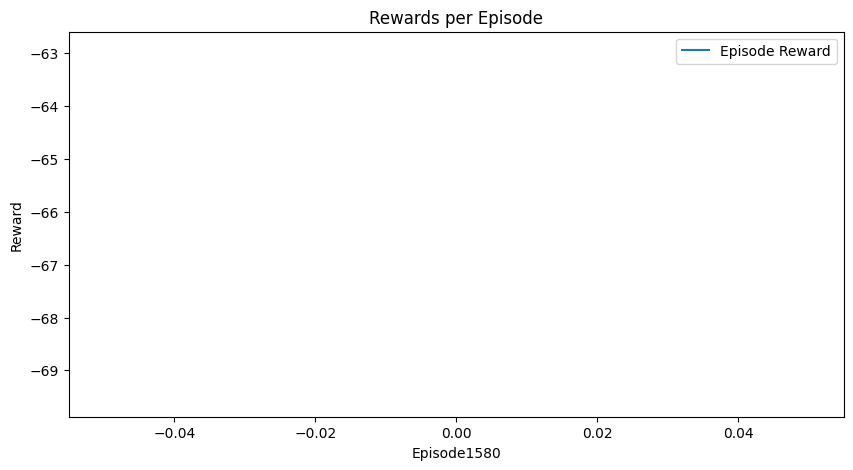

Episode 1590	Average Score: -26.65


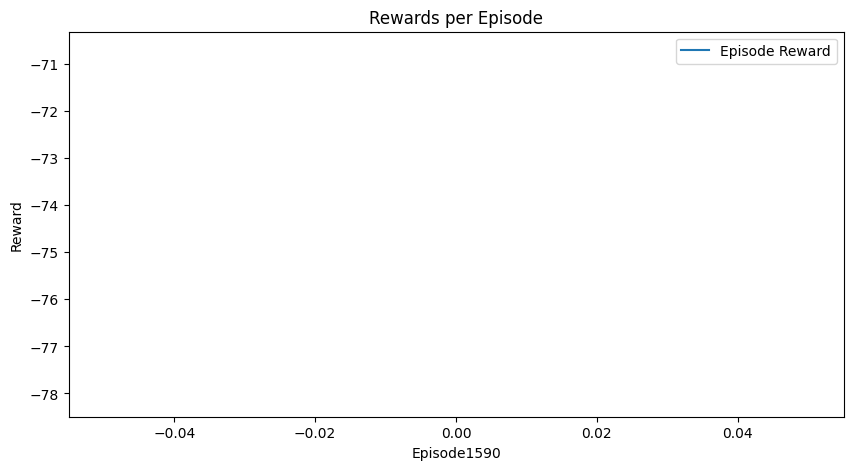

Episode 1600	Average Score: -45.49


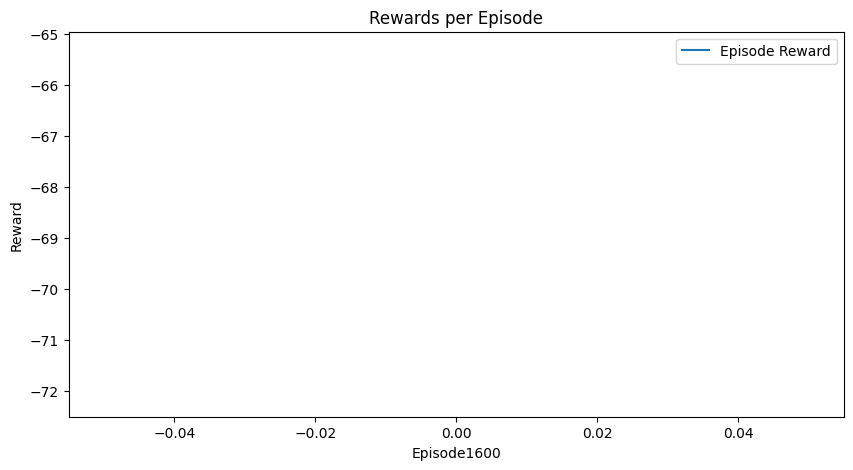

Episode 1610	Average Score: -25.85


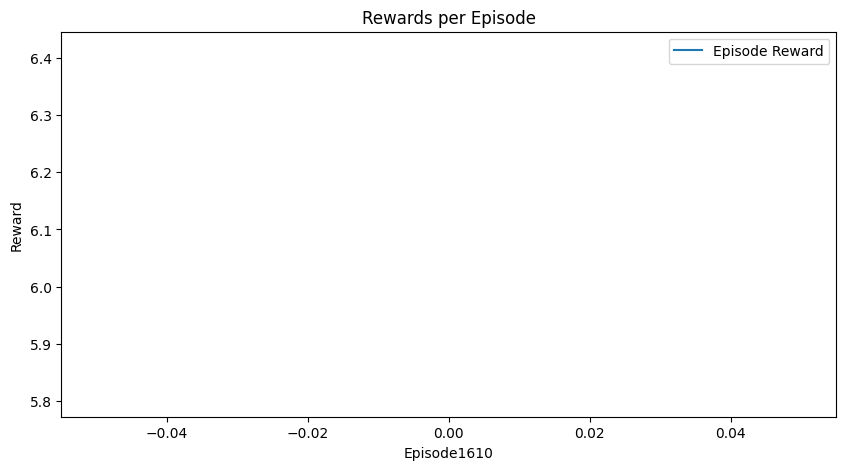

Episode 1620	Average Score: -52.44


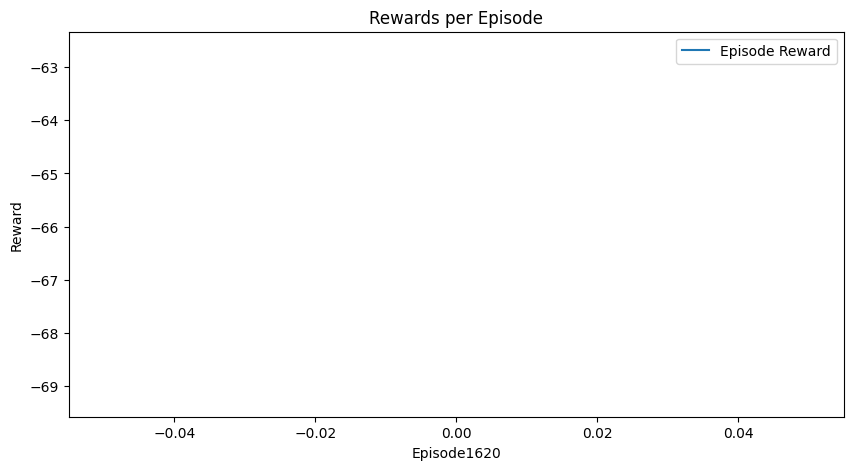

Episode 1630	Average Score: -65.29


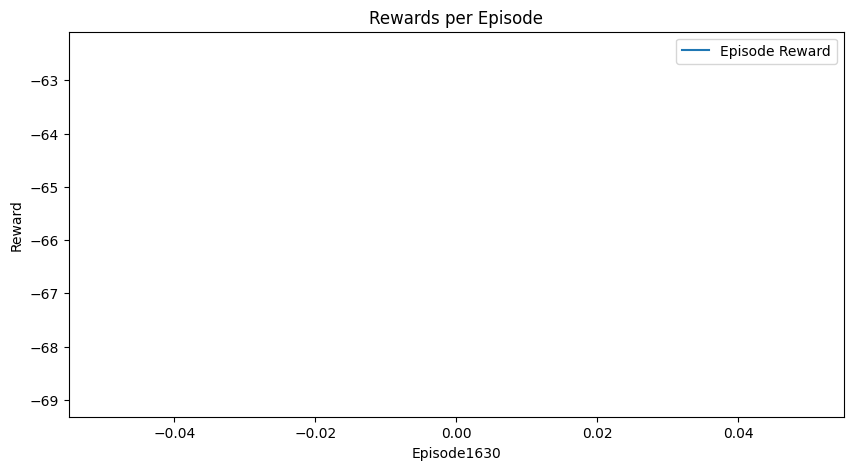

Episode 1640	Average Score: -59.64


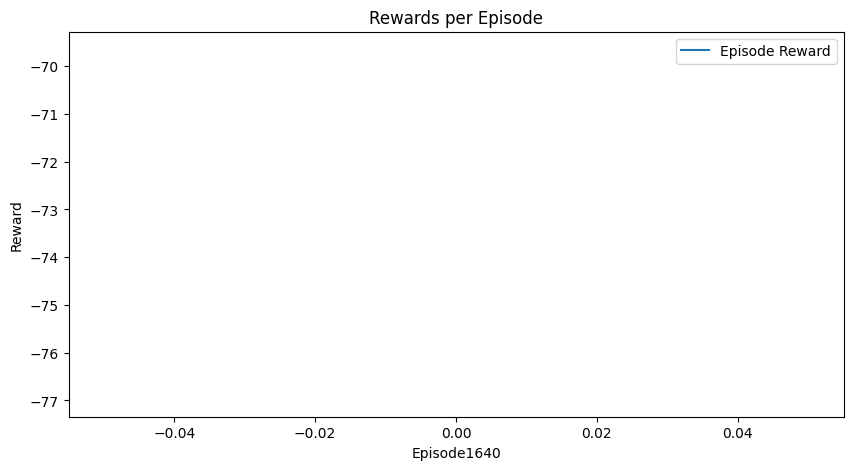

Episode 1650	Average Score: -50.59


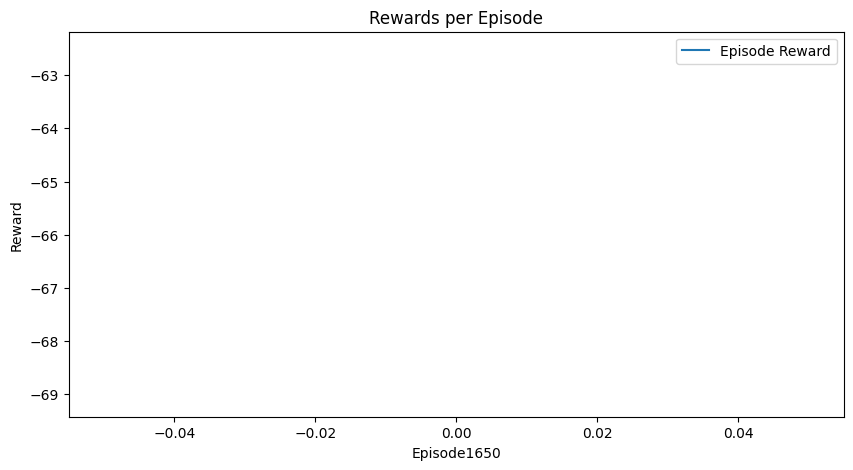

Episode 1660	Average Score: -61.56


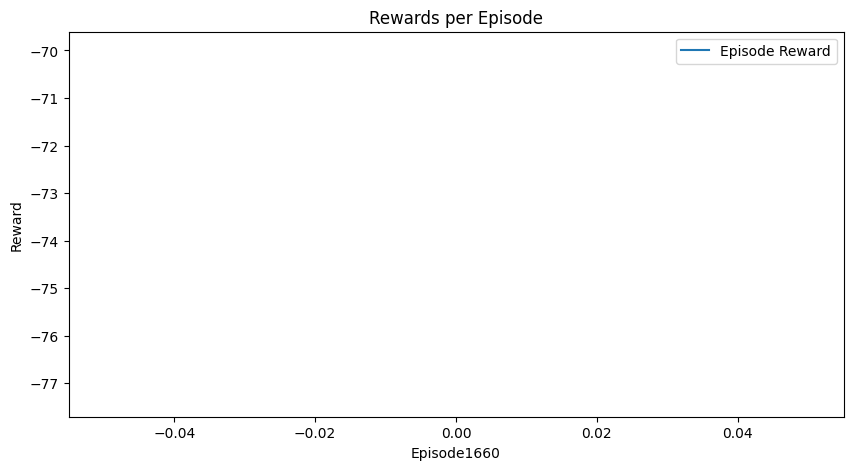

Episode 1670	Average Score: -71.72


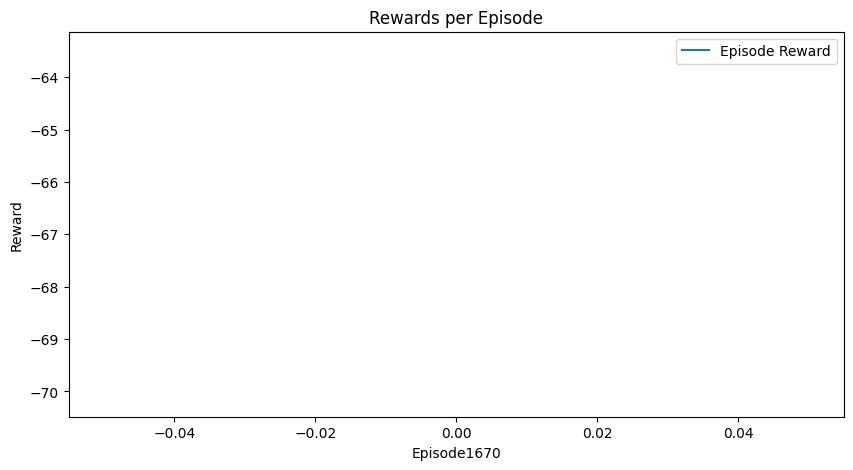

Episode 1680	Average Score: -69.66


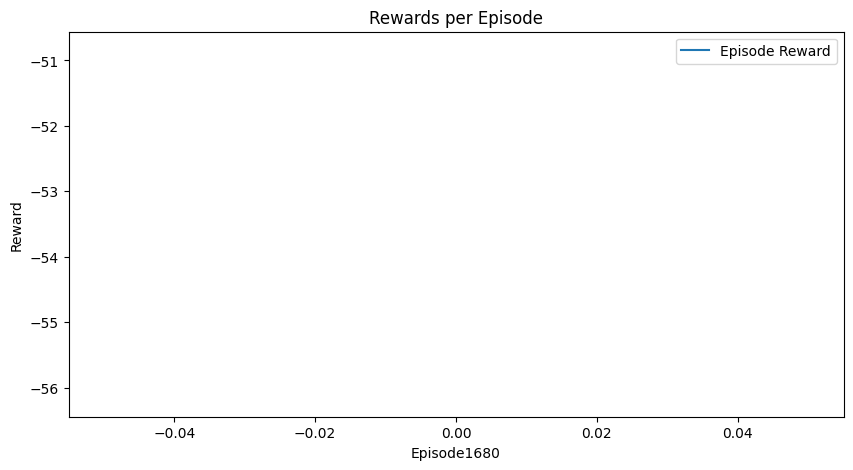

Episode 1690	Average Score: -62.02


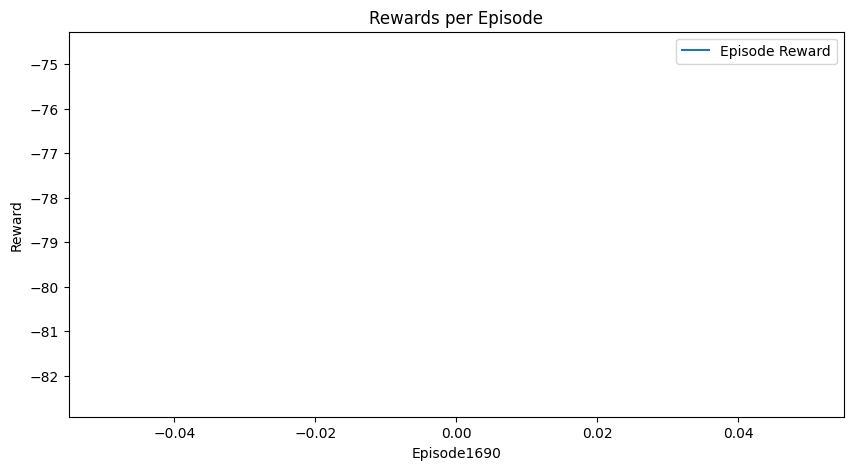

Episode 1700	Average Score: -64.53


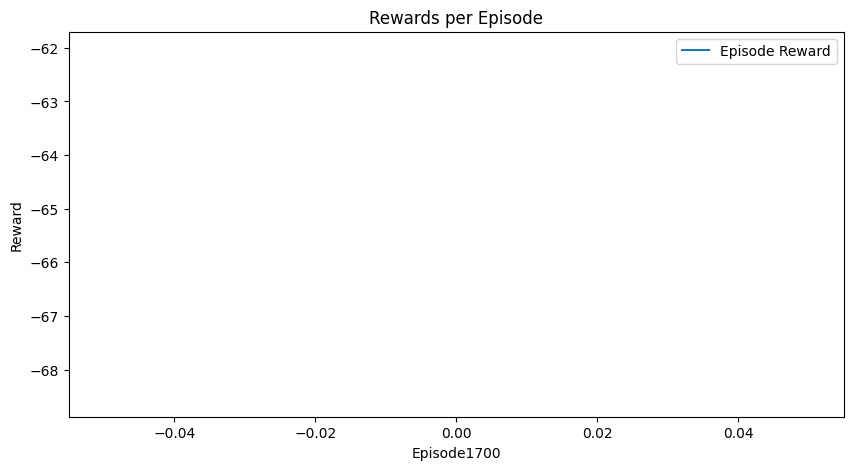

Episode 1710	Average Score: -33.54


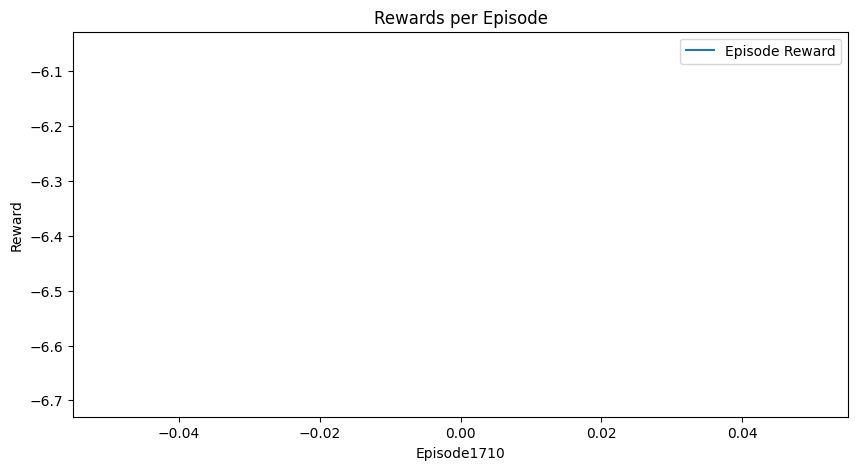

Episode 1720	Average Score: -48.48


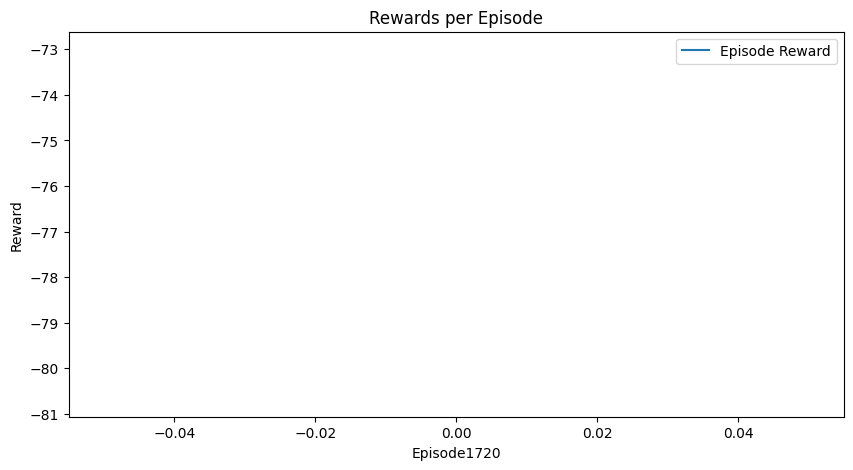

Episode 1730	Average Score: -47.17


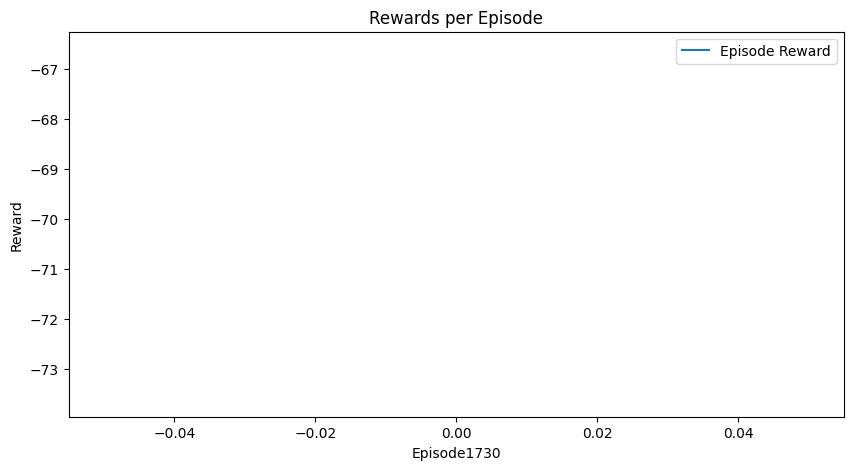

Episode 1740	Average Score: -65.17


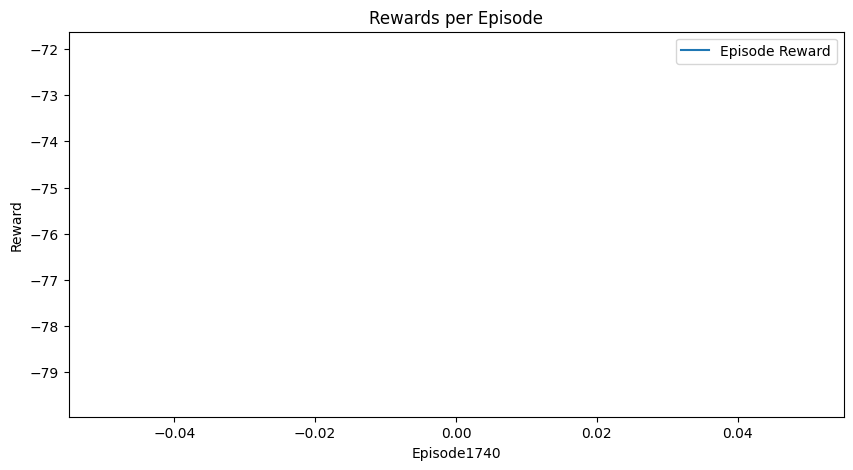

Episode 1750	Average Score: -50.92


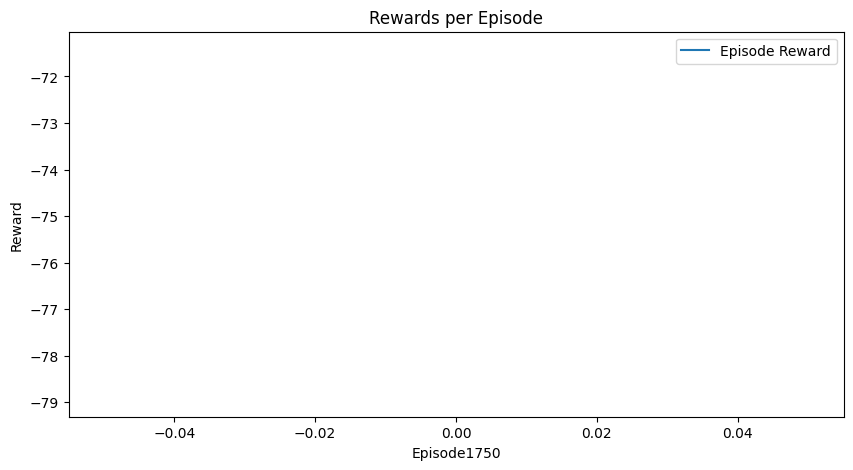

Episode 1760	Average Score: -54.53


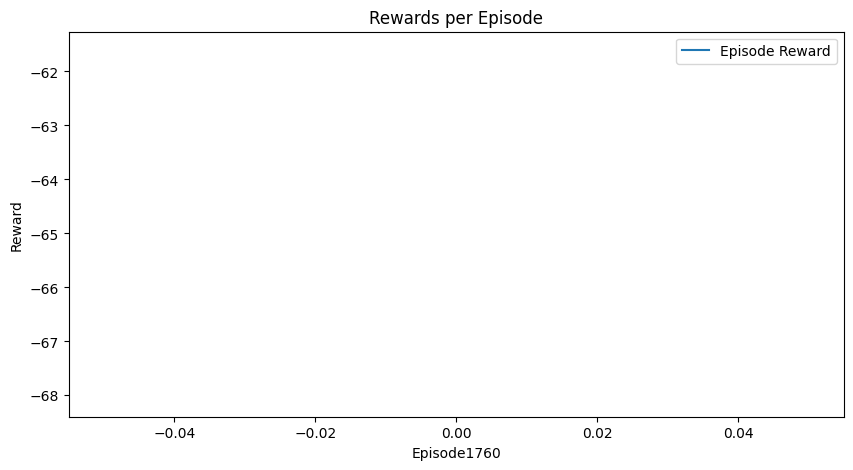

Episode 1770	Average Score: -39.63


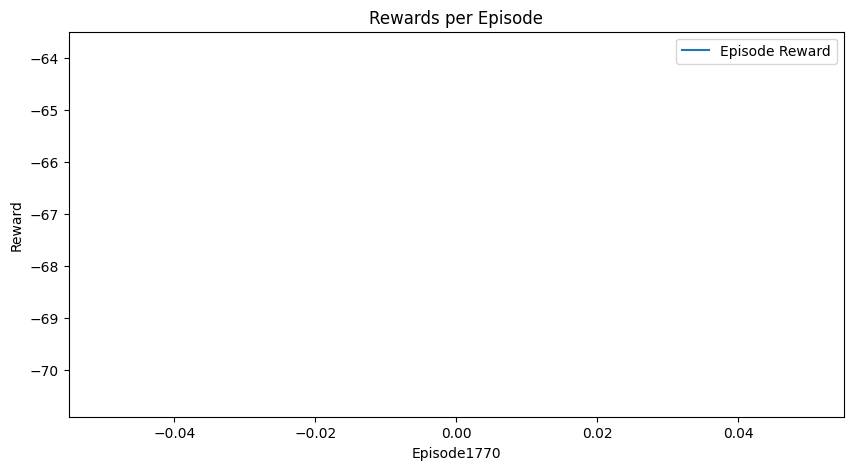

Episode 1780	Average Score: -71.88


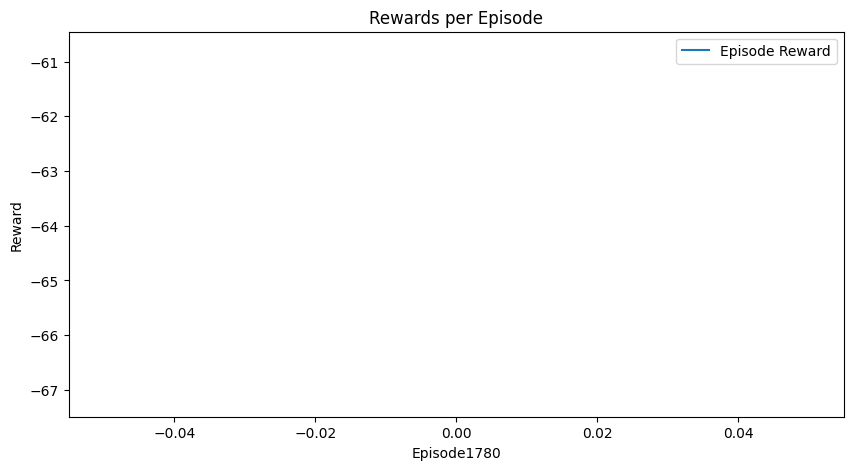

Episode 1790	Average Score: -51.37


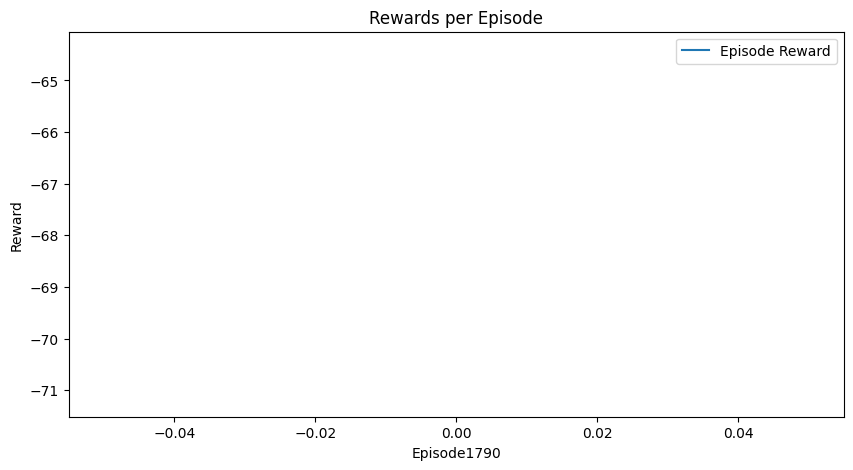

Episode 1800	Average Score: -46.19


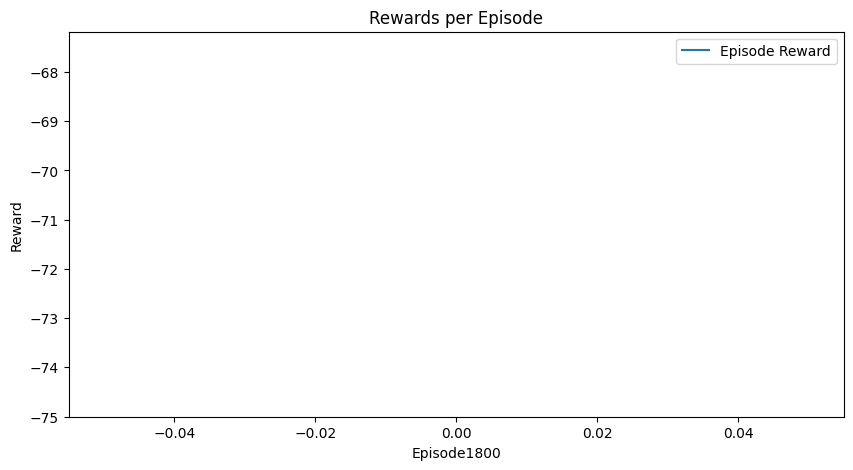

Episode 1810	Average Score: -48.13


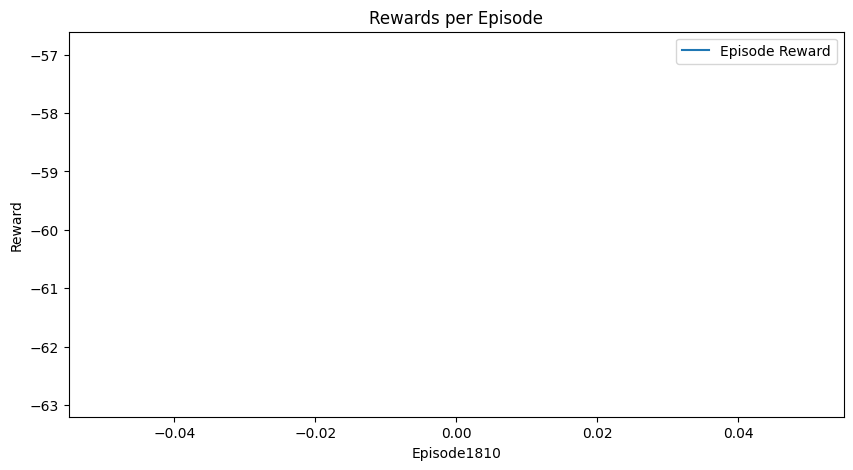

Episode 1820	Average Score: -58.76


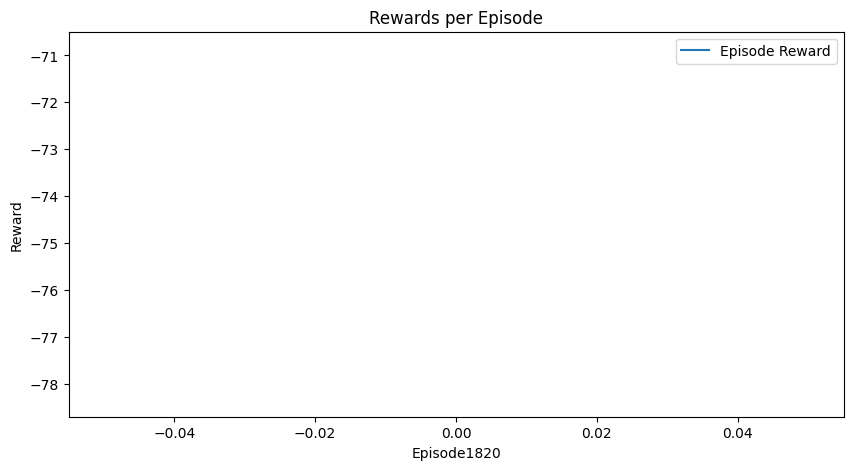

Episode 1830	Average Score: -54.92


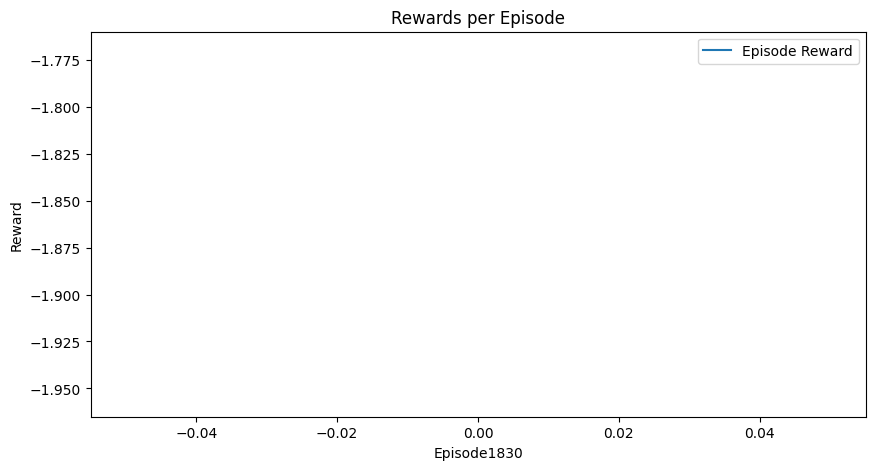

Episode 1840	Average Score: -46.64


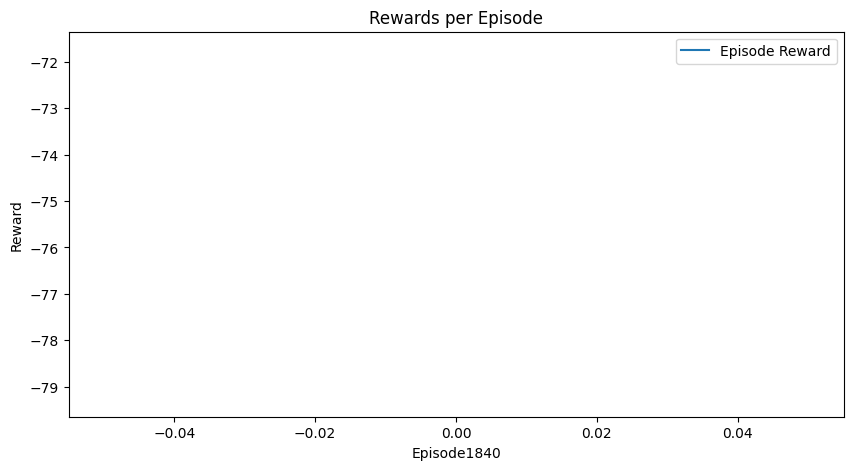

Episode 1850	Average Score: -39.54


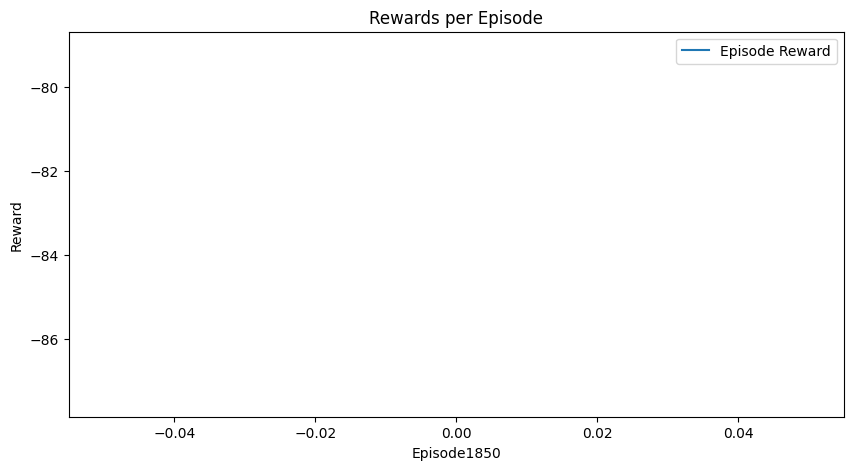

Episode 1860	Average Score: -53.48


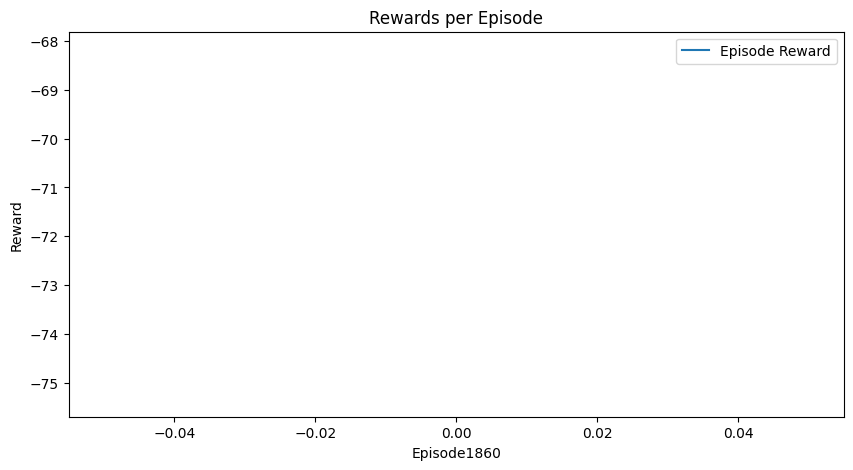

Episode 1870	Average Score: -60.39


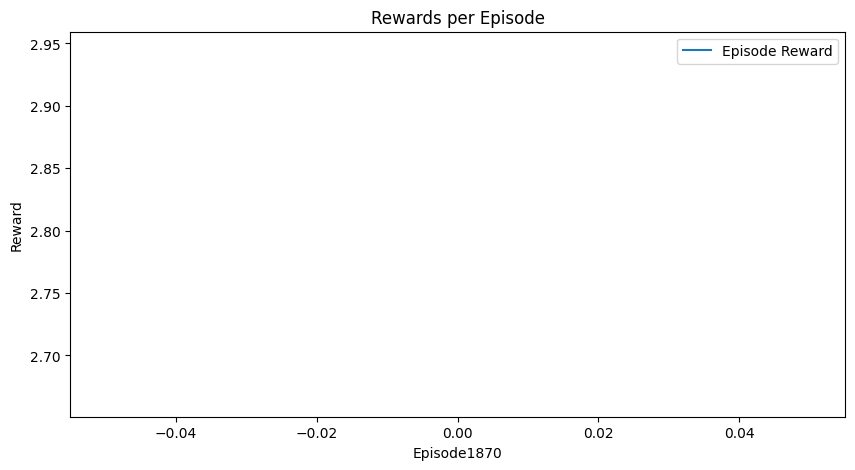

Episode 1880	Average Score: -49.82


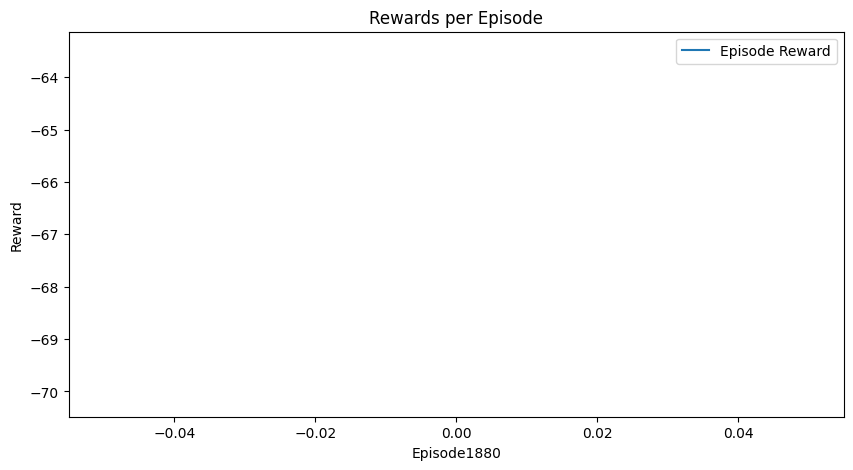

Episode 1890	Average Score: -54.27


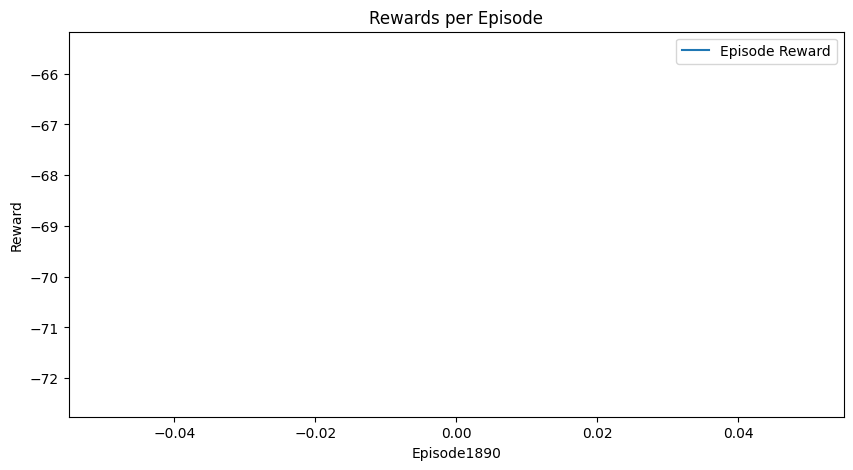

Episode 1900	Average Score: -69.36


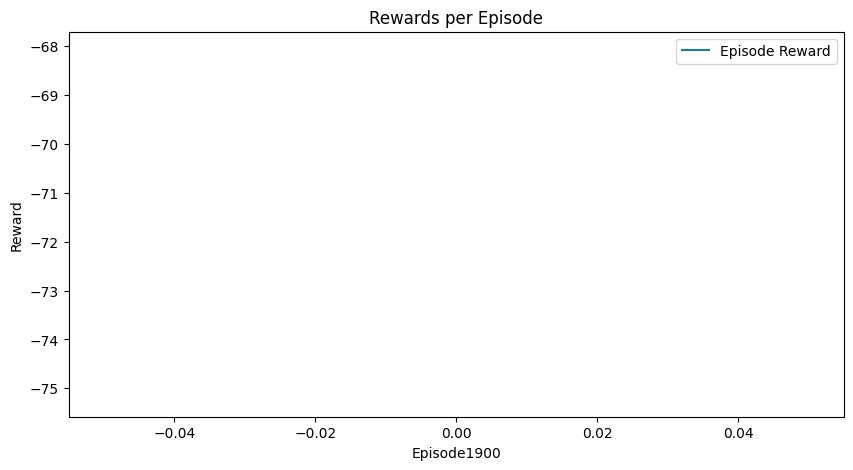

Episode 1910	Average Score: -58.68


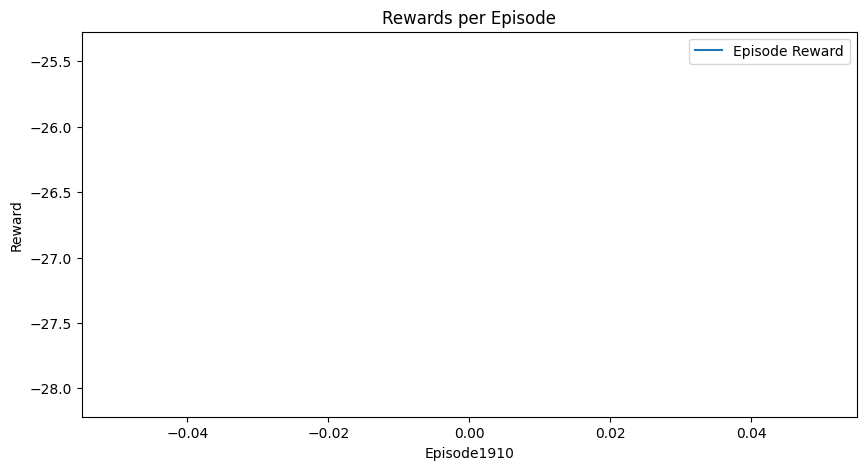

Episode 1920	Average Score: -56.61


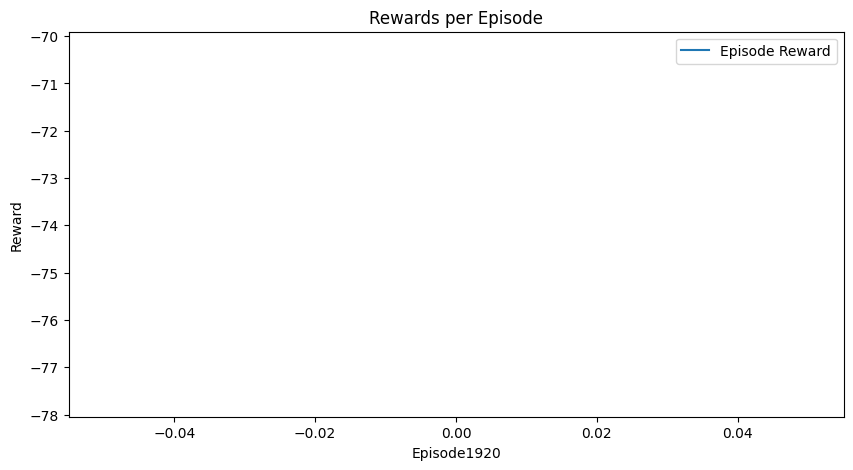

Episode 1930	Average Score: -44.90


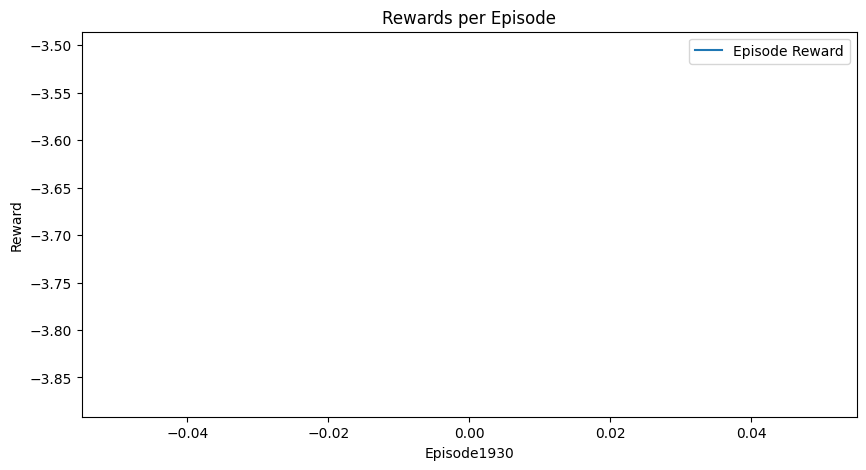

Episode 1940	Average Score: -70.33


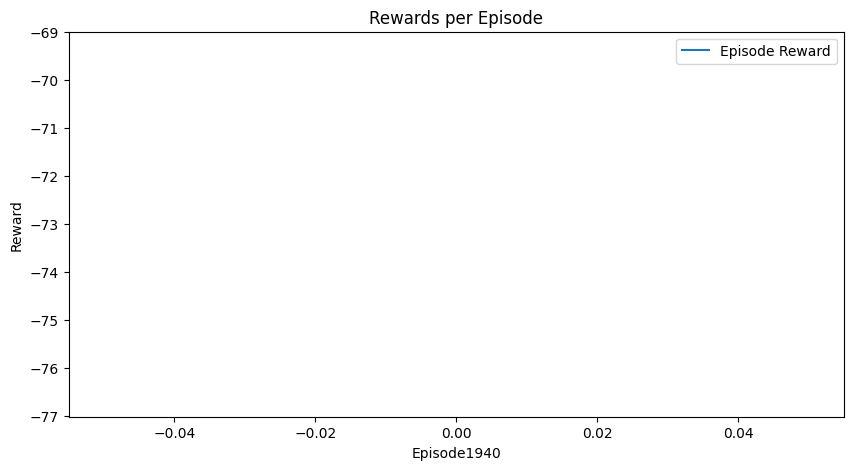

Episode 1950	Average Score: -43.43


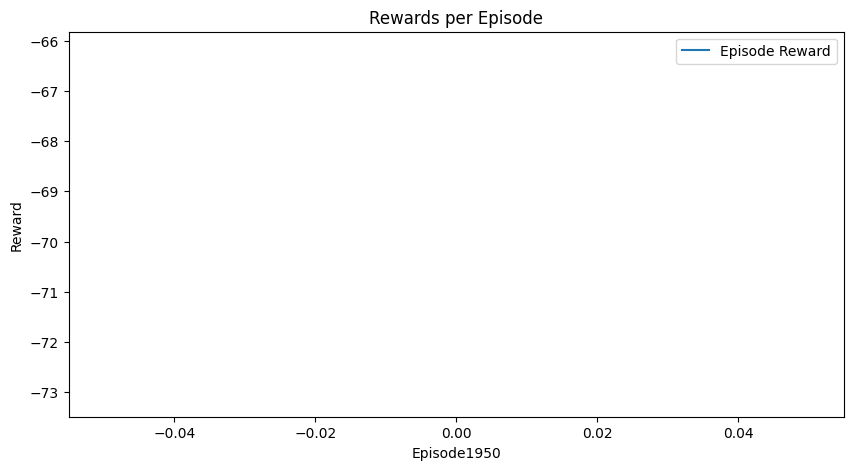

Episode 1960	Average Score: -71.24


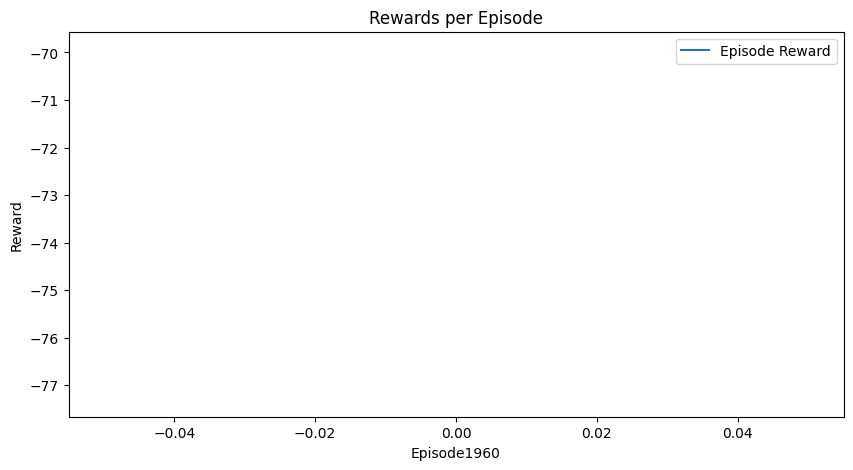

Episode 1970	Average Score: -40.75


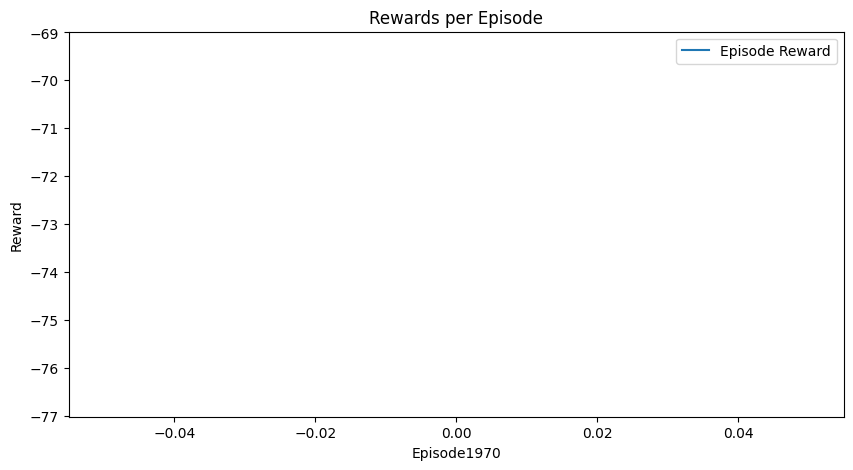

Episode 1980	Average Score: -44.59


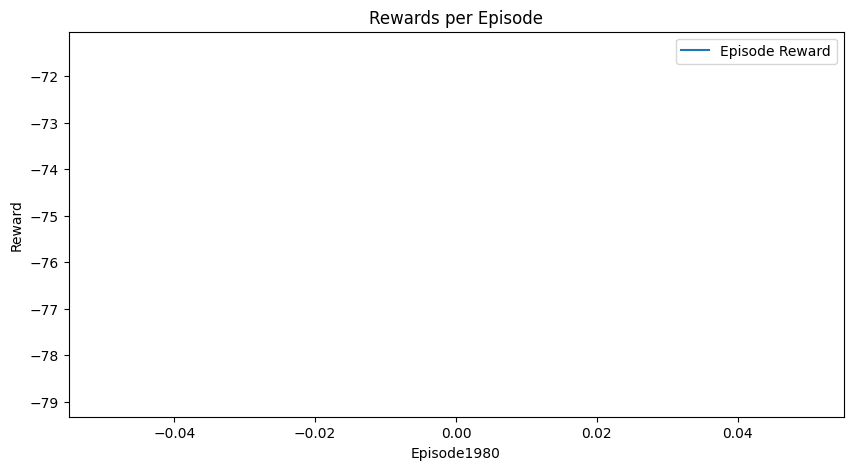

Episode 1990	Average Score: -45.23


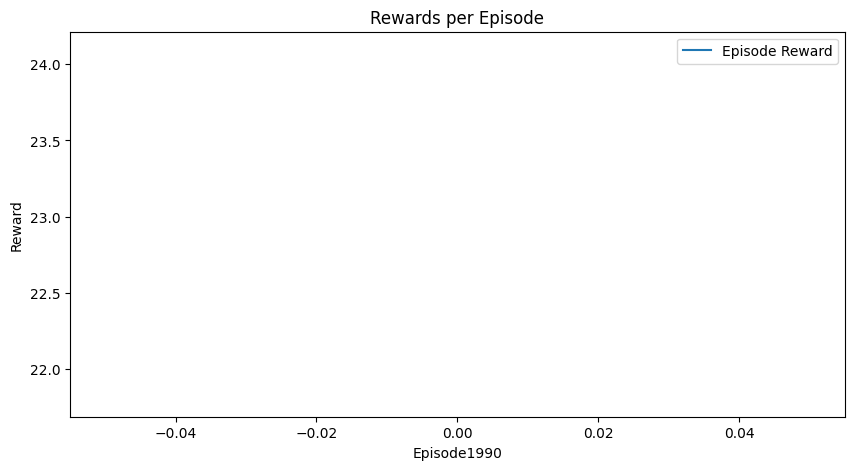

Episode 2000	Average Score: -23.84


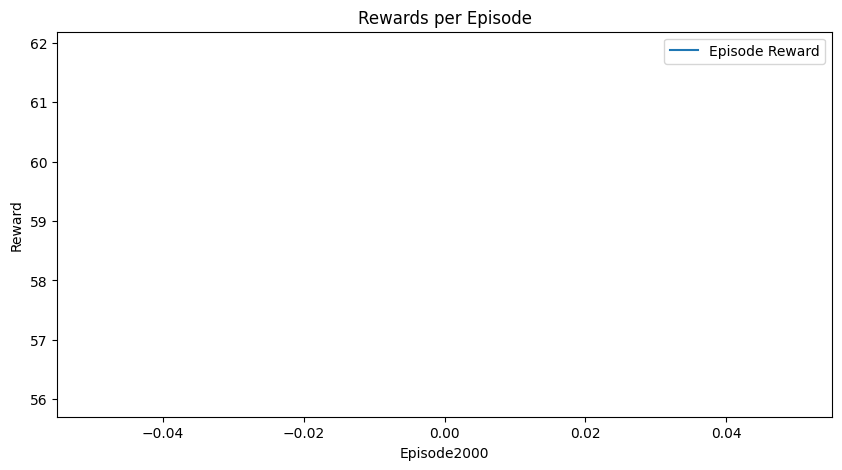

Episode 2010	Average Score: -51.66


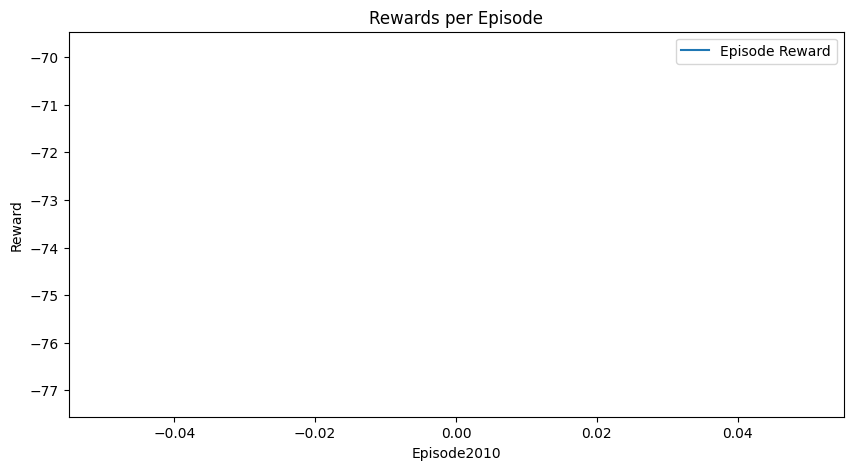

Episode 2020	Average Score: -31.77


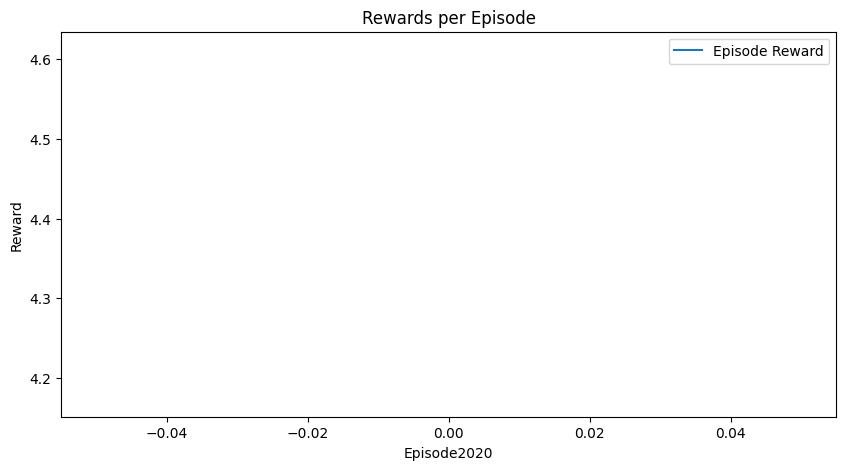

Episode 2030	Average Score: -56.39


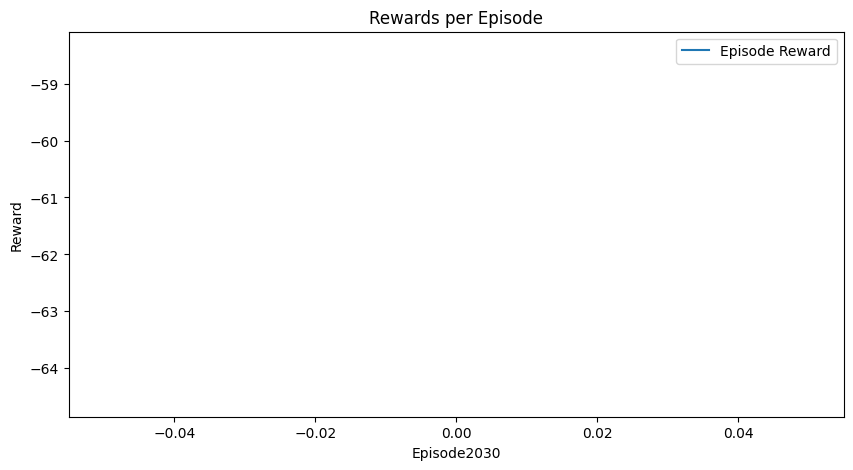

Episode 2040	Average Score: -34.42


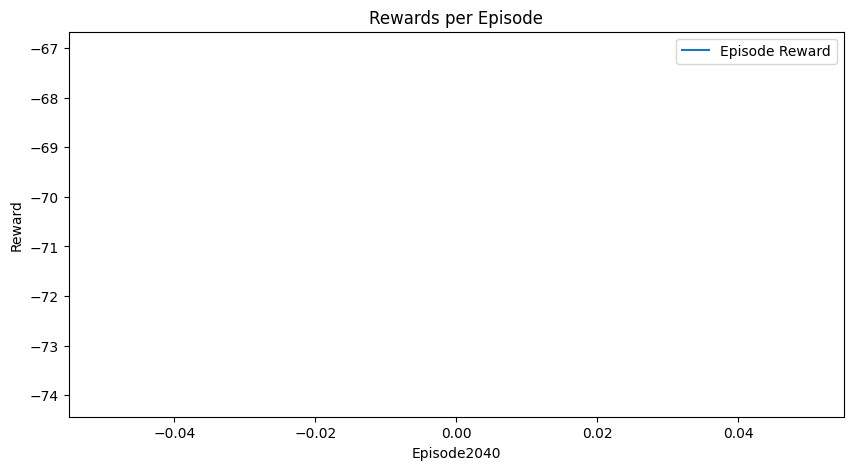

Episode 2050	Average Score: -49.87


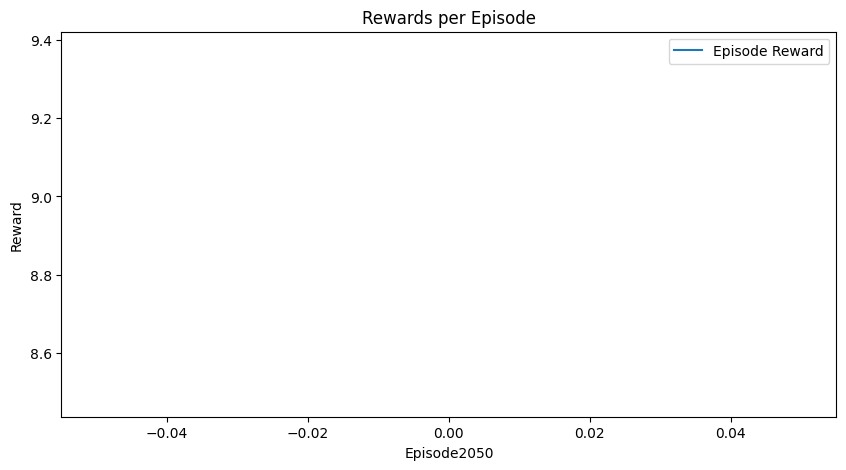

Episode 2060	Average Score: -44.78


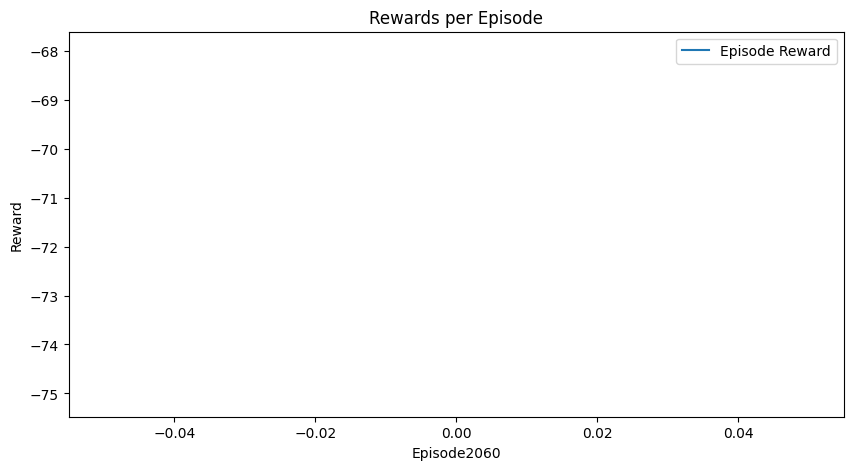

Episode 2070	Average Score: -58.59


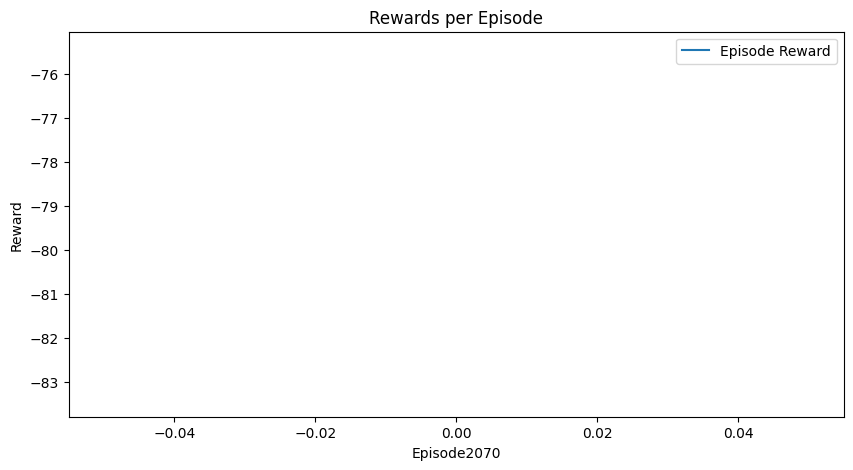

Episode 2080	Average Score: -54.00


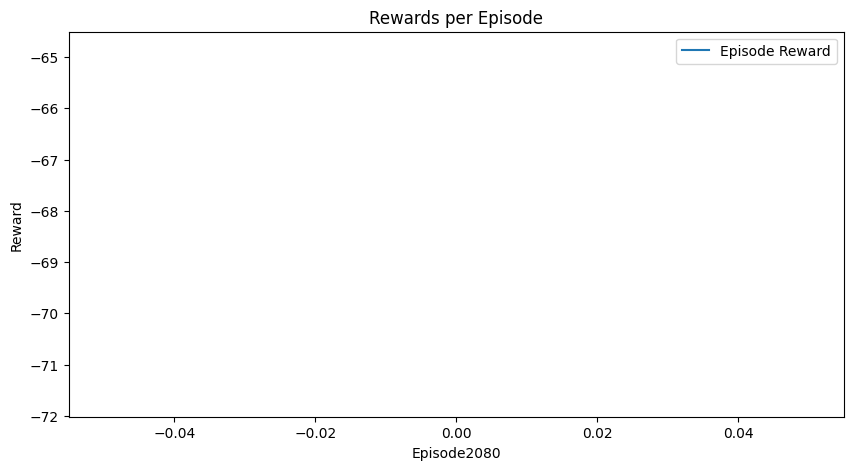

Episode 2090	Average Score: -43.68


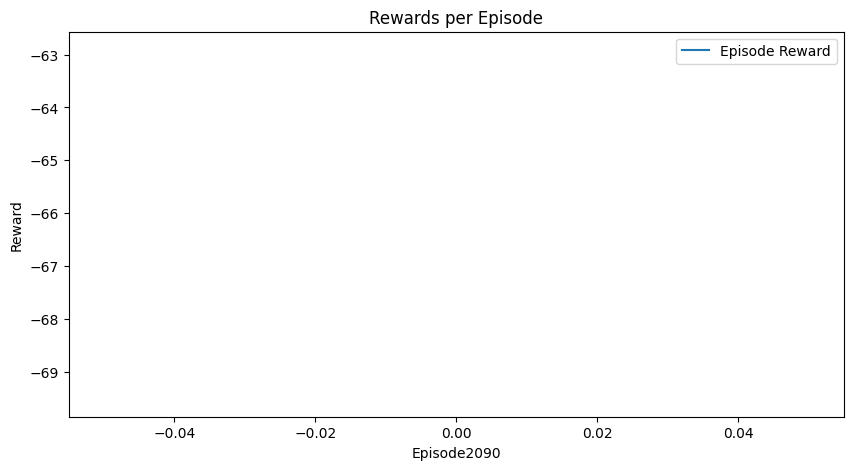

Episode 2100	Average Score: -42.72


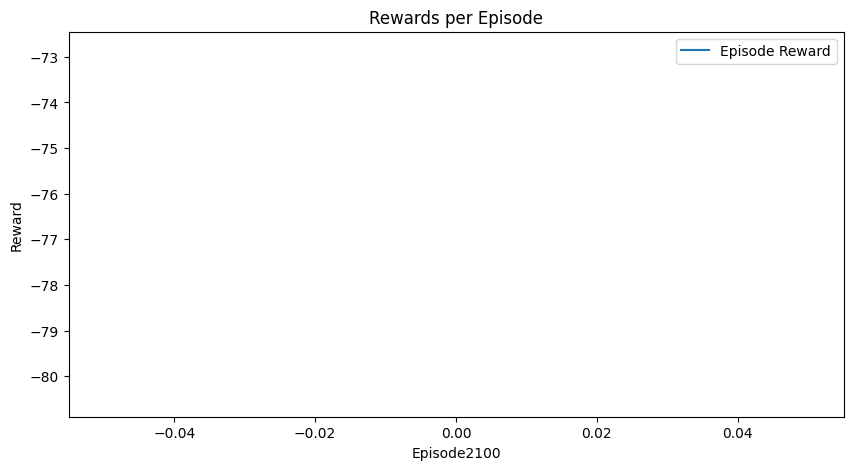

Episode 2110	Average Score: -59.93


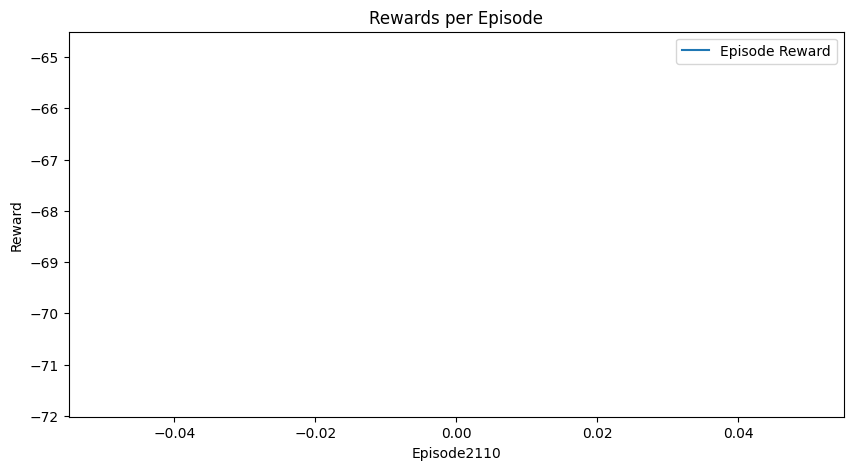

Episode 2120	Average Score: -59.36


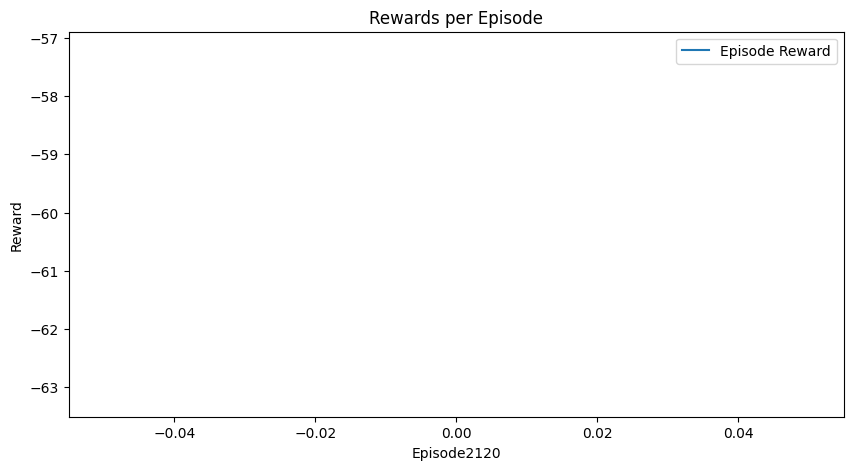

Episode 2130	Average Score: -70.56


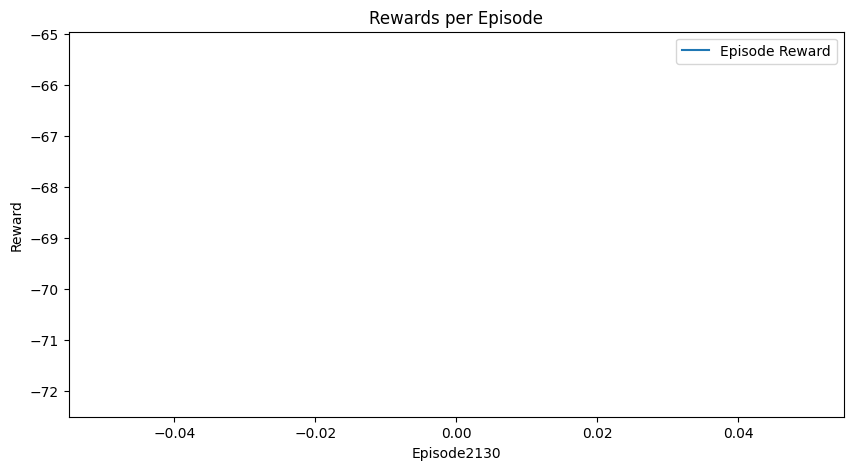

Episode 2140	Average Score: -52.09


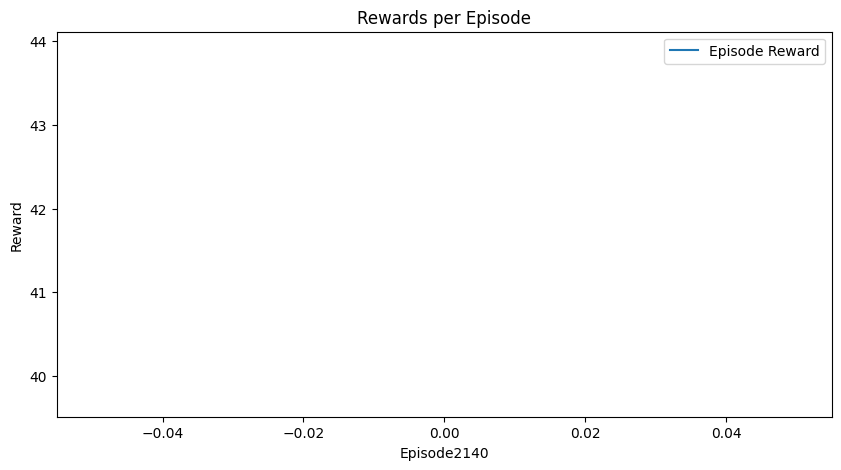

Episode 2150	Average Score: -68.31


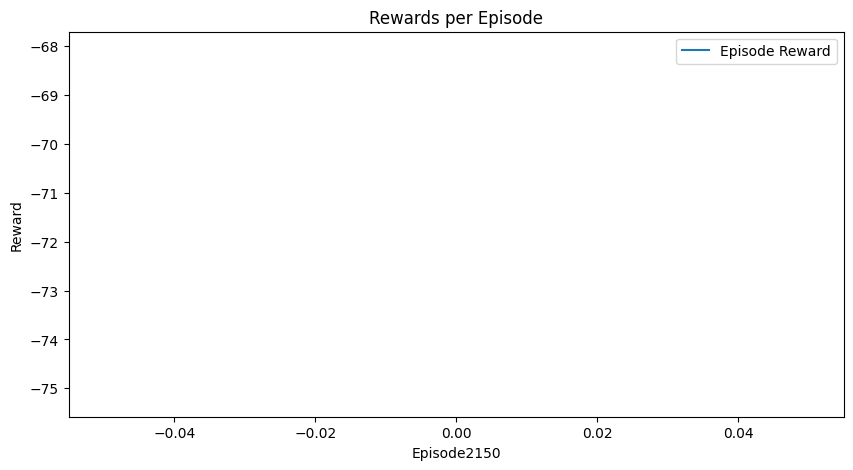

Episode 2160	Average Score: -35.39


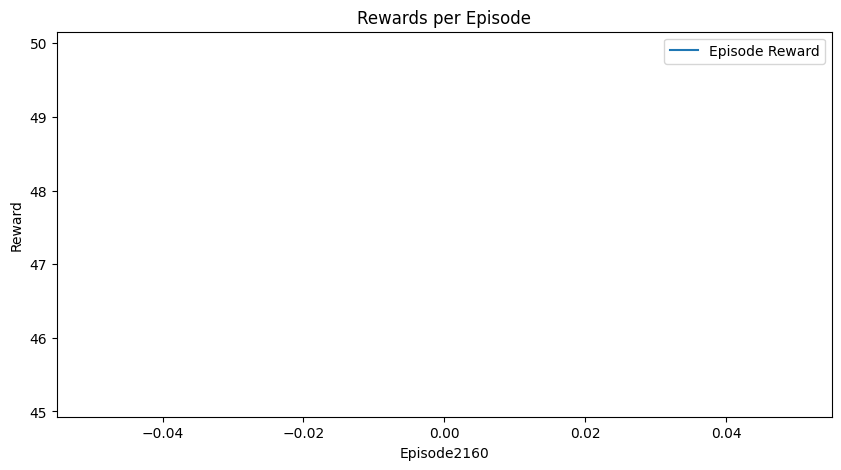

Episode 2170	Average Score: -46.39


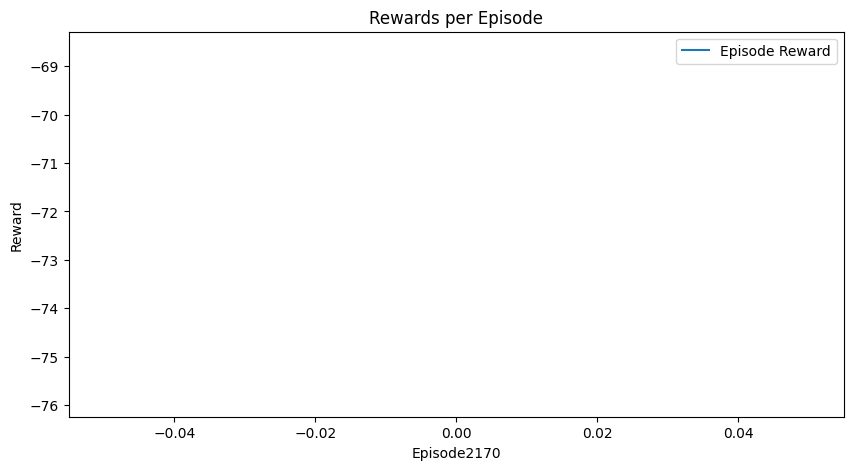

Episode 2180	Average Score: -37.08


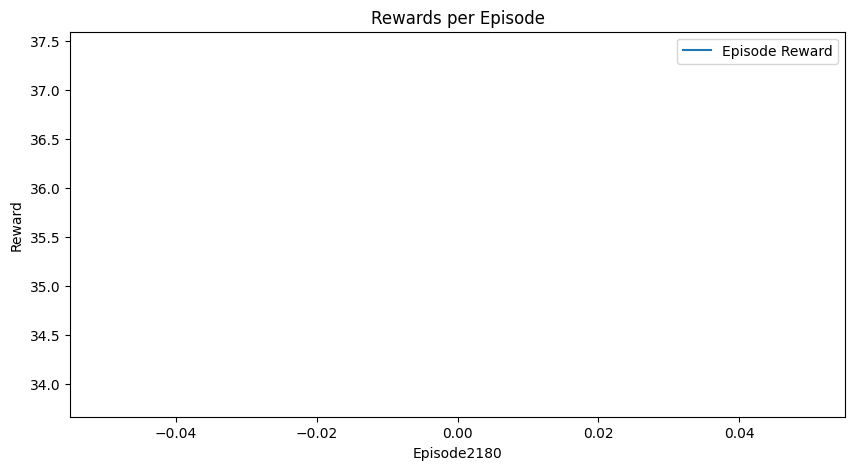

Episode 2190	Average Score: -53.40


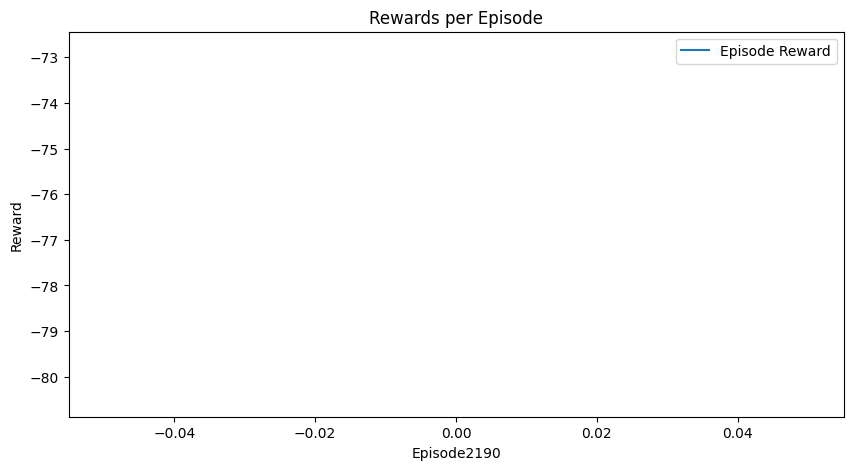

Episode 2200	Average Score: -35.64


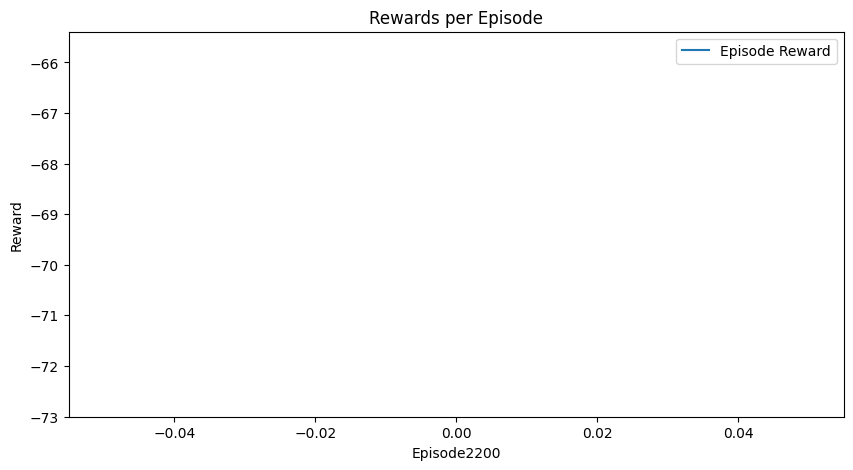

Episode 2210	Average Score: -61.77


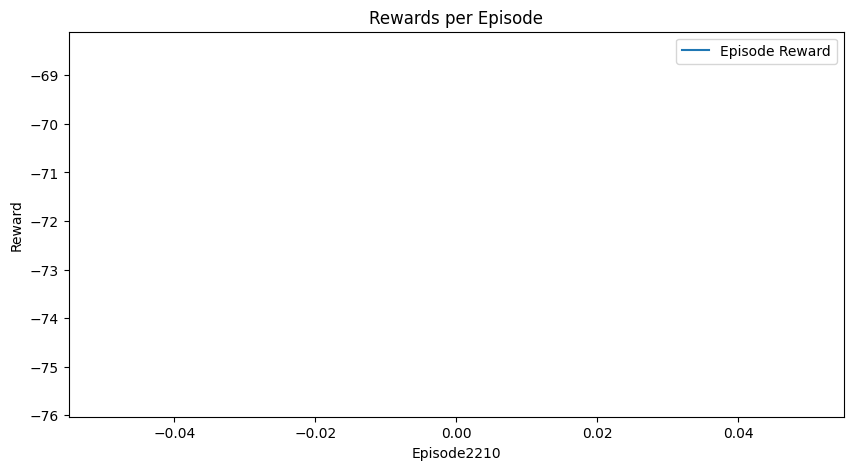

Episode 2220	Average Score: -56.15


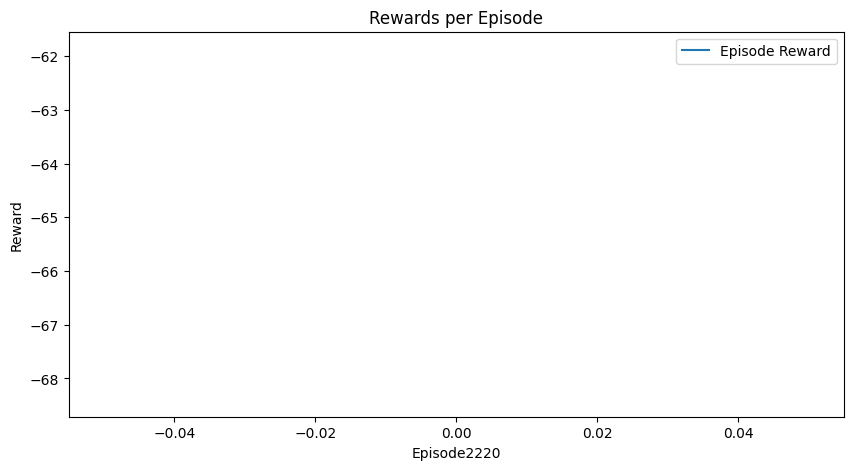

Episode 2230	Average Score: -45.58


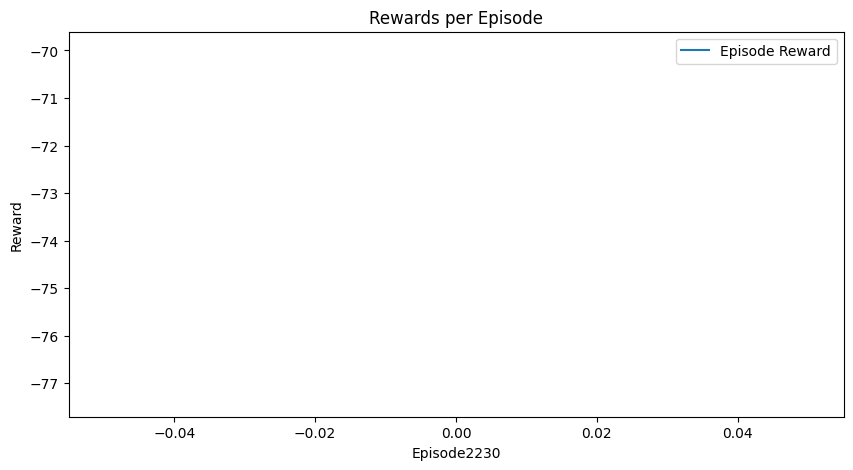

Episode 2240	Average Score: -64.83


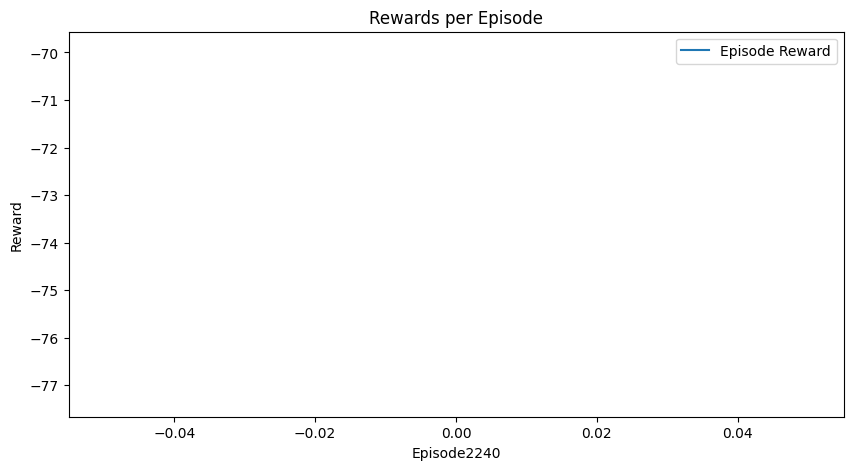

Episode 2250	Average Score: -52.23


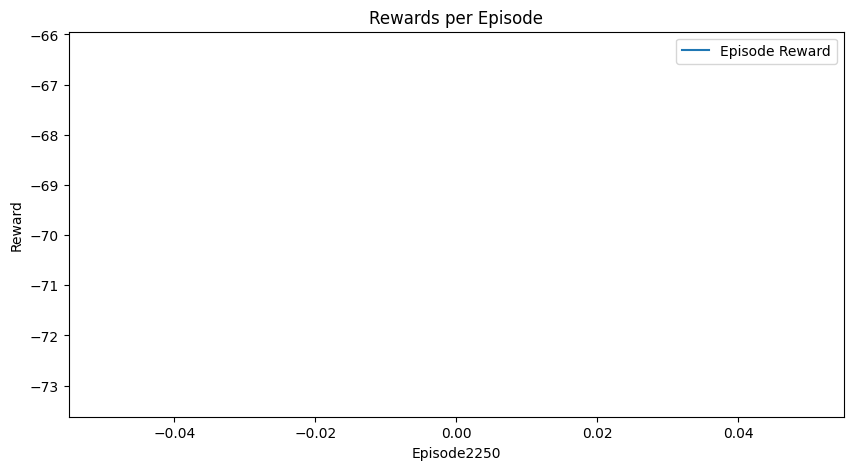

Episode 2260	Average Score: -61.07


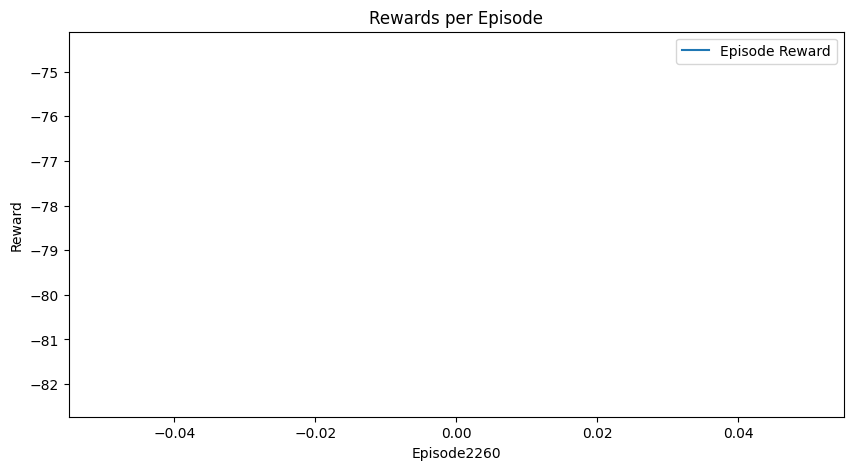

Episode 2270	Average Score: -47.55


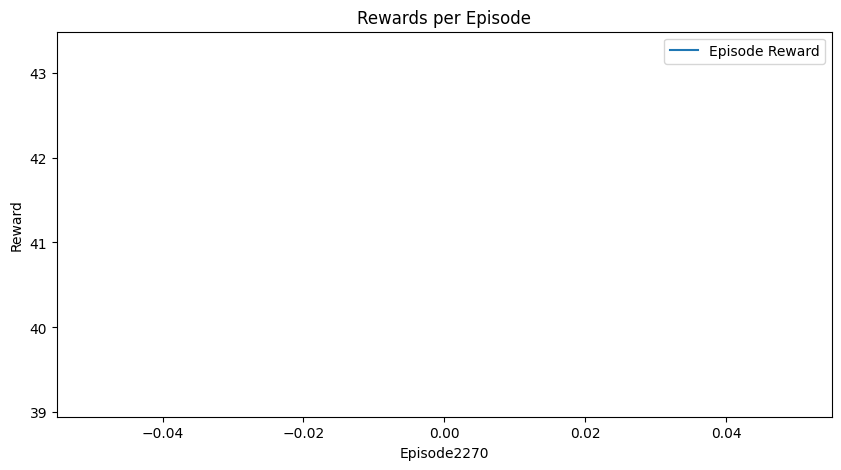

KeyboardInterrupt: 

In [72]:
from collections import deque
import time

MAX_EPISODES = 10000
gamma = 0.99
interval = 10
batch_size = 32
scores=[]
scores_window=deque(maxlen=interval)

start=time.time()

for episode in range(1, MAX_EPISODES+1):

    episode_reward = train(env, actor,critic, actor_optimizer,critic_optimizer, gamma, batch_size)


    scores.append(episode_reward)
    scores_window.append(episode_reward)


    # 주의: episode_reward가 400을 넘지 못해 checkpoint.pth가 저장되지 않을 수도 있습니다.
    # 매 K번 episode마다 checkpoint.pth를 저장해도 무방합니다.

    if episode % interval == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
        plot_rewards(episode_reward, episode)

    if episode % (5*interval)==0:
        torch.save(actor.state_dict(), 'actor{}.pt'.format(episode))
        torch.save(critic.state_dict(), 'critic{}.pt'.format(episode))
    if episode_reward>=400.0:
        print("END!!")
        print("It takes {} seconds".format(time.time()-start))
        torch.save(actor.state_dict(), 'actor.pt')
        torch.save(critic.state_dict(), 'critic.pt')
        break

Training!!

In [24]:
# history = {'Step': [], 'AvgReturn': []}
# (s,_)=env.reset()

# print(s.shape)
# while True:
#   s = torch.Tensor(s)
#   a=agent.select_action(s)
#   ns, r, done, truncated, info = env.step(a)
#   # Update
#   agent.process((s, a, r, ns, done))

#   s=ns

#   if done or truncated:
#     (s,_)=env.reset()

#   if agent.total_steps % eval_interval == 0:
#     rewards = evaluate()
#     history['Step'].append(agent.total_steps)
#     history['AvgReturn'].append(rewards)

#     clear_output()
#     plt.figure(figsize=(8, 5))
#     plt.plot(history['Step'], history['AvgReturn'], 'r-')
#     plt.xlabel('Step', fontsize=16)
#     plt.ylabel('AvgReturn', fontsize=16)
#     plt.xticks(fontsize=14)
#     plt.yticks(fontsize=14)
#     plt.grid(axis='y')
#     plt.show()

#     torch.save(agent.Q.state_dict(), 'dqn.pt')


#   if agent.total_steps > max_steps:
#     break

(4, 84, 84)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (288x9 and 2592x256)

# Visualize

In [ ]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim)
agent.Q.load_state_dict(torch.load("dqn.pt"))

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.select_action(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

In [ ]:
# Create animation
fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])
def animate(i):
    im.set_array(frames[i])
    return im,
anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())